SixHumpCamel synthetic function:

GP ERM versus STP nu = 3 ERM (winner)

https://www.sfu.ca/~ssurjano/camel6.html

In [1]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
### Inputs:

obj_func = 'SixHumpCamel'
n_test = 50 # test points
df = 3 # nu

util_loser = 'RegretMinimized'
util_winner = 'tRegretMinimized'
n_init = 5 # random initialisations

cov_func = squaredExponential()


In [3]:
### Objective function:

if obj_func == 'SixHumpCamel':
    
    # True y bounds:
    y_lb = -1.0316
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
# Constraints:
    lb_x1 = -3
    ub_x1 = +3
    
    lb_x2 = -2
    ub_x2 = +2
    
# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}
    
    max_iter = (10 * dim)*0 + 100  # iterations of Bayesian optimisation
    
# Test data:
    x1_test = np.linspace(lb_x1, ub_x1, n_test)
    x2_test = np.linspace(lb_x2, ub_x2, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return operator * ((4 - 2.1 * x1_training ** 2 + 1 / 3 * x1_training ** 4) * x1_training ** 2 +
                (x1_training * x2_training) + (-4 + 4 * x2_training ** 2) * x2_training ** 2)
    

In [4]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [5]:
### Set-seeds:

run_num_1 = 111
run_num_2 = 113
run_num_3 = 3333
run_num_4 = 444
run_num_5 = 5555
run_num_6 = 6
run_num_7 = 777
run_num_8 = 887
run_num_9 = 99
run_num_10 = 1000
run_num_11 = 1113
run_num_12 = 1234
run_num_13 = 2345
run_num_14 = 88
run_num_15 = 1556
run_num_16 = 1666
run_num_17 = 717
run_num_18 = 8
run_num_19 = 1998
run_num_20 = 2000


In [6]:
### Acquisition function - ERM:

class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-06, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'RegretMinimized': self.RegretMinimized,
            'tRegretMinimized': self.tRegretMinimized
        }

        self.f = mode_dict[mode]
   
    def RegretMinimized(self, tau, mean, std):
        
        z = (mean - y_global_orig - self.eps) / (std + self.eps)
        return z * (std + self.eps) * norm.cdf(z) + (std + self.eps) * norm.pdf(z)[0]
    
    def tRegretMinimized(self, tau, mean, std, nu=3.0):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return gamma * (std + self.eps) * t.cdf(gamma, df=nu) + (std + self.eps) * (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu)
    

In [7]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_loser_1 = GaussianProcess(cov_func)

loser_1 = GPGO(surrogate_loser_1, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.67302105 -1.32372098]. 	  -5.793449752432556 	 -0.8736935954900025
init   	 [-0.38364588  1.07704989]. 	  -0.8736935954900025 	 -0.8736935954900025
init   	 [-1.22804817 -1.40334817]. 	  -11.759316761133794 	 -0.8736935954900025
init   	 [-2.86513005 -0.31910203]. 	  -76.26436708944966 	 -0.8736935954900025
init   	 [-1.56790715 -0.64937523]. 	  -2.1371114994016214 	 -0.8736935954900025
1      	 [-0.93715312 -0.14094362]. 	  -2.1732366761917628 	 -0.8736935954900025
2      	 [-0.07304745  1.9144092 ]. 	  -38.94939404436368 	 -0.8736935954900025
3      	 [-0.78050993  0.72945565]. 	  -0.167569287879497 	 -0.167569287879497
4      	 [0.30116645 0.52574138]. 	  0.29590610486999536 	 0.29590610486999536
5      	 [-0.24800953  0.70022966]. 	  0.935121440318956 	 0.935121440318956
6      	 [1.5609464  0.14143977]. 	  -2.243079860045657 	 0.935121440318956
7      	 [ 1.98277411 -2.        ]. 	  -47.55707867715 	 0.93512144

99     	 [ 1.73673603 -0.96623492]. 	  -0.1807152065744506 	 1.0290480670839535
100    	 [-0.09590284  0.63470091]. 	  0.9865013931367435 	 1.0290480670839535


In [8]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_loser_2 = GaussianProcess(cov_func)

loser_2 = GPGO(surrogate_loser_2, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.11191296 -1.7043856 ]. 	  -24.175973303775706 	 -2.2733752808550527
init   	 [ 2.36959058 -0.25402581]. 	  -14.417173913696448 	 -2.2733752808550527
init   	 [-2.23393359  0.3034315 ]. 	  -8.078384314238003 	 -2.2733752808550527
init   	 [ 2.04282552 -0.2595178 ]. 	  -3.564649730949853 	 -2.2733752808550527
init   	 [1.17546336 0.73855239]. 	  -2.2733752808550527 	 -2.2733752808550527
1      	 [ 1.15696415 -0.34291717]. 	  -1.5792328485400045 	 -1.5792328485400045
2      	 [1.60259527 0.08121045]. 	  -2.1721691951550346 	 -1.5792328485400045
3      	 [0.72219245 1.74530995]. 	  -27.75337391833869 	 -1.5792328485400045
4      	 [-3. -2.]. 	  -162.89999999999998 	 -1.5792328485400045
5      	 [ 1.66202741 -0.63776504]. 	  -0.026098956189019362 	 -0.026098956189019362
6      	 [-0.03019684  0.24438903]. 	  0.22836934045908666 	 0.22836934045908666
7      	 [0.49745879 0.37247973]. 	  -0.5736356477870388 	 0.22836934045

98     	 [-1.77087388  0.75861102]. 	  0.14872796222869067 	 1.0303687102869248
99     	 [ 1.5261282 -0.8115012]. 	  0.0018335549230428239 	 1.0303687102869248
100    	 [-0.12819565  0.71412009]. 	  1.025978875259258 	 1.0303687102869248


In [9]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_loser_3 = GaussianProcess(cov_func)

loser_3 = GPGO(surrogate_loser_3, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.50945364 -1.5629949 ]. 	  -13.89572751148896 	 -0.027690663940903623
init   	 [-0.08327233 -0.00067529]. 	  -0.027690663940903623 	 -0.027690663940903623
init   	 [ 0.94265999 -1.05646116]. 	  -1.6525931811945593 	 -0.027690663940903623
init   	 [ 0.67676934 -1.52139039]. 	  -12.56543686771716 	 -0.027690663940903623
init   	 [ 1.27321378 -0.50975783]. 	  -0.9673942177133168 	 -0.027690663940903623
1      	 [ 0.55583856 -0.53062014]. 	  0.05886828563667812 	 0.05886828563667812
2      	 [-0.93812422  0.56405229]. 	  -0.7241197257913029 	 0.05886828563667812
3      	 [-3. -2.]. 	  -162.89999999999998 	 0.05886828563667812
4      	 [-0.35662755  0.6623391 ]. 	  0.7457243275072701 	 0.7457243275072701
5      	 [3. 2.]. 	  -162.89999999999998 	 0.7457243275072701
6      	 [-3.  2.]. 	  -150.89999999999998 	 0.7457243275072701
7      	 [-0.62328834  0.22953003]. 	  -0.9138615689602275 	 0.7457243275072701
8      	 [-0.19

99     	 [ 0.08281988 -0.70858959]. 	  1.0313298409369251 	 1.0313298409369251
100    	 [ 2.8492419  -0.03804816]. 	  -72.30079939605417 	 1.0313298409369251


In [10]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_loser_4 = GaussianProcess(cov_func)

loser_4 = GPGO(surrogate_loser_4, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.03616628 1.28517986]. 	  -11.164343885550666 	 -1.5094648555070385
init   	 [0.85324299 0.66889047]. 	  -1.5094648555070385 	 -1.5094648555070385
init   	 [-2.76516057 -1.73731045]. 	  -85.9872978949554 	 -1.5094648555070385
init   	 [-1.34099616 -0.73455799]. 	  -2.3318567753236477 	 -1.5094648555070385
init   	 [-1.83844553 -1.21162847]. 	  -7.376051913381579 	 -1.5094648555070385
1      	 [-1.01437897 -1.75256636]. 	  -29.483576565451546 	 -1.5094648555070385
2      	 [-1.91438989 -0.42850765]. 	  -3.0825209393641564 	 -1.5094648555070385
3      	 [ 3. -2.]. 	  -150.89999999999998 	 -1.5094648555070385
4      	 [-0.05640391  2.        ]. 	  -47.8998965367624 	 -1.5094648555070385
5      	 [1.00244671 0.20551426]. 	  -2.2814346947109962 	 -1.5094648555070385
6      	 [-2.96701333  1.47701968]. 	  -105.80292056646262 	 -1.5094648555070385
7      	 [-1.69152227 -0.76906951]. 	  -2.395299314041103 	 -1.509464855507038

98     	 [-1.79473501  1.46034985]. 	  -9.276890587165429 	 1.0289901281202716
99     	 [-0.38490882  1.11186483]. 	  -1.287859305303532 	 1.0289901281202716
100    	 [ 1.88937607 -0.95511048]. 	  -0.5568805346409538 	 1.0289901281202716


In [11]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_loser_5 = GaussianProcess(cov_func)

loser_5 = GPGO(surrogate_loser_5, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.34411965 0.16704251]. 	  -0.3937629170174044 	 0.3730261027784846
init   	 [ 0.3625427  -0.47180763]. 	  0.3730261027784846 	 0.3730261027784846
init   	 [-2.28543493  1.38399646]. 	  -14.95148366216595 	 0.3730261027784846
init   	 [1.43844967 1.72943026]. 	  -28.545251683089745 	 0.3730261027784846
init   	 [2.15596804 0.8324185 ]. 	  -7.6401968083208285 	 0.3730261027784846
1      	 [ 2.81160912 -0.08415915]. 	  -64.79173078590617 	 0.3730261027784846
2      	 [-0.23106522 -0.45348889]. 	  0.3410229294819404 	 0.3730261027784846
3      	 [-3. -2.]. 	  -162.89999999999998 	 0.3730261027784846
4      	 [ 0.0789118  -0.25498825]. 	  0.23846077990721387 	 0.3730261027784846
5      	 [ 0.12012353 -1.48392355]. 	  -10.466640607038924 	 0.3730261027784846
6      	 [0.90299428 0.07482027]. 	  -2.091365268965974 	 0.3730261027784846
7      	 [-0.74640357 -0.30672528]. 	  -1.5223368401391302 	 0.3730261027784846
8      	 [3

100    	 [-1.065235   -1.76307983]. 	  -30.41611267523959 	 1.0316186898180488


In [12]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_loser_6 = GaussianProcess(cov_func)

loser_6 = GPGO(surrogate_loser_6, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.35716091 -0.67208078]. 	  -11.995980169715628 	 0.3096187466378422
init   	 [ 1.92737474 -1.8332135 ]. 	  -31.167927894156623 	 0.3096187466378422
init   	 [-2.35405992  0.38020826]. 	  -13.013381745677465 	 0.3096187466378422
init   	 [ 0.17890417 -0.32477029]. 	  0.3096187466378422 	 0.3096187466378422
init   	 [-0.9875529   0.49007773]. 	  -0.9989196280666852 	 0.3096187466378422
1      	 [-0.12191844  0.49506843]. 	  0.741453601410202 	 0.741453601410202
2      	 [-0.37098235 -0.24344843]. 	  -0.3789004257898174 	 0.741453601410202
3      	 [-0.669951    1.49296697]. 	  -11.359290133322727 	 0.741453601410202
4      	 [0.64869573 0.24332304]. 	  -1.2712393080277513 	 0.741453601410202
5      	 [-0.18875744  0.20424528]. 	  0.05858970564507704 	 0.741453601410202
6      	 [-0.20392166 -1.33670575]. 	  -6.058546494320597 	 0.741453601410202
7      	 [0.41775451 1.05670176]. 	  -1.5982037606762858 	 0.7414536014102

100    	 [-0.07948172  0.62429612]. 	  0.9758103921078468 	 1.028185177802214


In [13]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_loser_7 = GaussianProcess(cov_func)

loser_7 = GPGO(surrogate_loser_7, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.08401759 -0.79057356]. 	  -5.778591021444629 	 -0.6139922708386365
init   	 [-2.62778151 -0.16055863]. 	  -37.56206986588009 	 -0.6139922708386365
init   	 [2.01152031 1.70798819]. 	  -29.692842569565112 	 -0.6139922708386365
init   	 [1.36193391 1.07398489]. 	  -4.49224583043401 	 -0.6139922708386365
init   	 [-1.3847696   0.57611717]. 	  -0.6139922708386365 	 -0.6139922708386365
1      	 [-1.33546514 -1.33946171]. 	  -9.833387638121035 	 -0.6139922708386365
2      	 [0.2838874  0.69494898]. 	  0.4926474344665255 	 0.4926474344665255
3      	 [1.34037633 0.15528739]. 	  -2.4550945739258507 	 0.4926474344665255
4      	 [-0.87185046  1.09262018]. 	  -1.946473086581968 	 0.4926474344665255
5      	 [-1.05617971  0.14038367]. 	  -2.086034244247926 	 0.4926474344665255
6      	 [0.72509872 0.89824793]. 	  -1.5989560308506285 	 0.4926474344665255
7      	 [-2.46851409 -1.80673456]. 	  -55.84426900955606 	 0.492647434466

99     	 [ 0.0800936  -0.70385952]. 	  1.0307170638615488 	 1.0307170638615488
100    	 [-0.13987136  0.65554394]. 	  0.9944900394745256 	 1.0307170638615488


In [14]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_loser_8 = GaussianProcess(cov_func)

loser_8 = GPGO(surrogate_loser_8, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.34300075 -1.83113994]. 	  -49.66879811482005 	 0.22190529745233212
init   	 [ 0.59815551 -0.80051718]. 	  0.22190529745233212 	 0.22190529745233212
init   	 [ 1.77967069 -0.5352155 ]. 	  -0.42351602320787596 	 0.22190529745233212
init   	 [ 2.28365006 -0.80863347]. 	  -8.27265764318726 	 0.22190529745233212
init   	 [-1.02538042  0.27486766]. 	  -1.710375599764969 	 0.22190529745233212
1      	 [1.29037445 0.20200115]. 	  -2.480997034389709 	 0.22190529745233212
2      	 [ 1.18473638 -0.80920456]. 	  -0.5361185956171156 	 0.22190529745233212
3      	 [ 1.745343   -0.14991732]. 	  -1.7709072181220349 	 0.22190529745233212
4      	 [-0.04553522 -0.2940538 ]. 	  0.294289344340327 	 0.294289344340327
5      	 [ 0.0496607  -0.88825695]. 	  0.7001745436561713 	 0.7001745436561713
6      	 [-1.53206188  1.32201802]. 	  -5.331602106816116 	 0.7001745436561713
7      	 [ 1.26057476 -0.42564457]. 	  -1.2610701939933218 	 0.70

99     	 [-0.08204208 -1.10118477]. 	  -1.1484120974862886 	 1.031555998209891
100    	 [-0.15130269  0.71868847]. 	  1.0171752939520076 	 1.031555998209891


In [15]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_loser_9 = GaussianProcess(cov_func)

loser_9 = GPGO(surrogate_loser_9, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.03367135 -0.0476864 ]. 	  -2.224696248130898 	 -2.224696248130898
init   	 [ 1.95297104 -1.87421445]. 	  -34.846635035334884 	 -2.224696248130898
init   	 [1.84829978 0.26246968]. 	  -2.674972725698239 	 -2.224696248130898
init   	 [-1.21426501 -1.81321712]. 	  -34.68894768245752 	 -2.224696248130898
init   	 [ 2.9437644  -1.97269707]. 	  -133.08463964627106 	 -2.224696248130898
1      	 [ 0.99919526 -1.87802298]. 	  -36.00572890352069 	 -2.224696248130898
2      	 [0.33113194 0.99935031]. 	  -0.7395127602691062 	 -0.7395127602691062
3      	 [-3.  2.]. 	  -150.89999999999998 	 -0.7395127602691062
4      	 [3. 2.]. 	  -162.89999999999998 	 -0.7395127602691062
5      	 [ 1.67002537 -0.17243671]. 	  -1.649161781835133 	 -0.7395127602691062
6      	 [1.12969368 0.43622179]. 	  -2.253883281745309 	 -0.7395127602691062
7      	 [-0.16570513  0.54535842]. 	  0.8179509003220468 	 0.8179509003220468
8      	 [-0.05751053  0

99     	 [-0.66300677  0.88183712]. 	  -0.10450903626885111 	 1.0309555339238001
100    	 [-0.17807022  0.64705619]. 	  0.9640356102682575 	 1.0309555339238001


In [16]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_loser_10 = GaussianProcess(cov_func)

loser_10 = GPGO(surrogate_loser_10, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.92153751 -1.53997223]. 	  -13.677695110590259 	 -6.372423095293032
init   	 [ 2.70169719 -0.07123439]. 	  -46.72852427361676 	 -6.372423095293032
init   	 [ 2.23484721 -1.15066928]. 	  -8.26768569212749 	 -6.372423095293032
init   	 [-2.75574225 -0.41122215]. 	  -55.82511776655432 	 -6.372423095293032
init   	 [-1.60120682  1.3669629 ]. 	  -6.372423095293032 	 -6.372423095293032
1      	 [ 2.58113859 -2.        ]. 	  -74.84682024424548 	 -6.372423095293032
2      	 [ 1.57470162 -0.81229953]. 	  0.08837188195077916 	 0.08837188195077916
3      	 [-0.16836986  2.        ]. 	  -47.774973884193805 	 0.08837188195077916
4      	 [-2.49962425  2.        ]. 	  -67.31814071799164 	 0.08837188195077916
5      	 [-1.21362495  0.74715066]. 	  -0.5077121230126085 	 0.08837188195077916
6      	 [-1.00460368 -1.88464791]. 	  -40.39026631870184 	 0.08837188195077916
7      	 [ 1.73224944 -0.97707968]. 	  -0.23468266608155064 	 0.0

99     	 [ 2.88993136 -1.21569296]. 	  -80.421519592609 	 1.0314294790796208
100    	 [2.95282291 0.70006488]. 	  -97.24887489921754 	 1.0314294790796208


In [17]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_loser_11 = GaussianProcess(cov_func)

loser_11 = GPGO(surrogate_loser_11, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.88621398 1.2849914 ]. 	  -88.29186392936245 	 -1.3768038348803564
init   	 [ 0.87536168 -0.30524795]. 	  -1.3768038348803564 	 -1.3768038348803564
init   	 [-1.78613413 -0.03237292]. 	  -2.2646252293989613 	 -1.3768038348803564
init   	 [-2.16865001 -0.18991586]. 	  -7.310805476408371 	 -1.3768038348803564
init   	 [-2.31759223 -1.98830205]. 	  -63.86369356519016 	 -1.3768038348803564
1      	 [-1.49201268  0.70463596]. 	  -0.12368954045433 	 -0.12368954045433
2      	 [-0.45308407 -0.03216398]. 	  -0.7459653765230012 	 -0.12368954045433
3      	 [ 1.05436088 -1.42426222]. 	  -9.153262547928108 	 -0.12368954045433
4      	 [-3.  2.]. 	  -150.89999999999998 	 -0.12368954045433
5      	 [-0.76594485  0.81298218]. 	  -0.17211557732865268 	 -0.12368954045433
6      	 [-1.25679659  0.44503189]. 	  -1.1977675868724482 	 -0.12368954045433
7      	 [-0.36294215  1.68137575]. 	  -20.54115923248786 	 -0.12368954045433
8      	

99     	 [-1.57141442  1.27918624]. 	  -4.246101476539559 	 1.0234080985991807
100    	 [ 2.92572179 -0.67351473]. 	  -86.47125216976039 	 1.0234080985991807


In [18]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_loser_12 = GaussianProcess(cov_func)

loser_12 = GPGO(surrogate_loser_12, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.8508833   0.48843508]. 	  -0.8285352707628978 	 0.04378866326980524
init   	 [-0.37363357  1.14143433]. 	  -1.670326523786612 	 0.04378866326980524
init   	 [ 1.67985485 -0.90962958]. 	  0.04378866326980524 	 0.04378866326980524
init   	 [-1.34121447  1.20748871]. 	  -3.3921424222614553 	 0.04378866326980524
init   	 [2.74883612 1.50373054]. 	  -69.67081810821485 	 0.04378866326980524
1      	 [ 1.36865588 -1.53139099]. 	  -12.837582610424613 	 0.04378866326980524
2      	 [ 2.01907328 -0.67017216]. 	  -1.6471745213009104 	 0.04378866326980524
3      	 [ 0.95632687 -0.32053923]. 	  -1.4814491220278343 	 0.04378866326980524
4      	 [-2.52185414 -0.42846579]. 	  -26.72553497150102 	 0.04378866326980524
5      	 [-1.03910342  0.3660143 ]. 	  -1.4458929377440608 	 0.04378866326980524
6      	 [-2.434201    1.15945148]. 	  -18.34577343196723 	 0.04378866326980524
7      	 [-1.47562192  0.5276854 ]. 	  -0.612066419130825

99     	 [-1.47616923 -1.88652854]. 	  -41.40825666775498 	 1.0247402765264615
100    	 [-0.6322706  -0.54470962]. 	  -0.7944667087506341 	 1.0247402765264615


In [19]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_loser_13 = GaussianProcess(cov_func)

loser_13 = GPGO(surrogate_loser_13, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.96386586 -0.34559739]. 	  -1.4171064314549415 	 -1.4171064314549415
init   	 [ 1.00861535 -1.08022631]. 	  -1.9362798876488938 	 -1.4171064314549415
init   	 [1.84607002 0.54727386]. 	  -2.606716488173805 	 -1.4171064314549415
init   	 [-1.96683689 -0.95845653]. 	  -4.9306493500188235 	 -1.4171064314549415
init   	 [ 2.49191994 -0.14873796]. 	  -23.22037861975103 	 -1.4171064314549415
1      	 [1.31005933 1.26173611]. 	  -7.787111565332043 	 -1.4171064314549415
2      	 [ 0.43242082 -2.        ]. 	  -47.81186343553399 	 -1.4171064314549415
3      	 [ 1.33270836 -0.88429756]. 	  -0.4870135931577916 	 -0.4870135931577916
4      	 [2.38805277 1.31001373]. 	  -24.381446893352688 	 -0.4870135931577916
5      	 [-3.  2.]. 	  -150.89999999999998 	 -0.4870135931577916
6      	 [-3. -2.]. 	  -162.89999999999998 	 -0.4870135931577916
7      	 [-1.46667321 -0.44283794]. 	  -2.223987287878843 	 -0.4870135931577916
8      	 [-1.

99     	 [ 1.79900006 -0.13919475]. 	  -1.9228507851187322 	 1.0314530828837465
100    	 [-0.02473527  0.77148006]. 	  0.9803981624053298 	 1.0314530828837465


In [20]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_loser_14 = GaussianProcess(cov_func)

loser_14 = GPGO(surrogate_loser_14, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.8853063  0.02859875]. 	  -2.0275945291834825 	 -2.0275945291834825
init   	 [0.17004828 1.58514082]. 	  -15.586853032333524 	 -2.0275945291834825
init   	 [1.19994714 0.85718841]. 	  -2.6498170273522446 	 -2.0275945291834825
init   	 [ 1.30403029 -1.10872215]. 	  -2.0500441913631415 	 -2.0275945291834825
init   	 [-1.94907286 -0.17263405]. 	  -3.38472265204694 	 -2.0275945291834825
1      	 [2.22212993 0.71391762]. 	  -9.267467852913526 	 -2.0275945291834825
2      	 [-3.  2.]. 	  -150.89999999999998 	 -2.0275945291834825
3      	 [-1.76631702 -0.9542249 ]. 	  -3.5211107459231856 	 -2.0275945291834825
4      	 [ 3. -2.]. 	  -150.89999999999998 	 -2.0275945291834825
5      	 [ 0.59863203 -1.33262018]. 	  -5.892789939167 	 -2.0275945291834825
6      	 [ 1.22521833 -0.55778933]. 	  -0.8592166103441335 	 -0.8592166103441335
7      	 [2.86493458 1.95006643]. 	  -123.89427694145698 	 -0.8592166103441335
8      	 [1.8440872

99     	 [ 2.69790981 -0.2587271 ]. 	  -45.45107101086421 	 1.0307291834318548
100    	 [-0.98991277 -1.91084742]. 	  -42.832123111171335 	 1.0307291834318548


In [21]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_loser_15 = GaussianProcess(cov_func)

loser_15 = GPGO(surrogate_loser_15, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.46729115 -0.97799468]. 	  -0.15324775214966774 	 -0.10477079024230418
init   	 [-1.48483878  0.83961742]. 	  -0.10477079024230418 	 -0.10477079024230418
init   	 [-0.31468582 -1.09222817]. 	  -1.6403350770531386 	 -0.10477079024230418
init   	 [-0.58974261  1.52903094]. 	  -12.761482581115207 	 -0.10477079024230418
init   	 [-0.3767192   1.51370072]. 	  -11.790964688915137 	 -0.10477079024230418
1      	 [-2.12826797  0.32652419]. 	  -4.934123393463919 	 -0.10477079024230418
2      	 [-0.88114718  0.18471356]. 	  -1.7011777695465604 	 -0.10477079024230418
3      	 [1.30747098 1.31648618]. 	  -9.17002452824579 	 -0.10477079024230418
4      	 [ 0.99645987 -1.97738227]. 	  -45.770750922776465 	 -0.10477079024230418
5      	 [ 0.46125796 -0.28130057]. 	  -0.3379606132854113 	 -0.10477079024230418
6      	 [ 0.25749526 -0.69779905]. 	  0.9229155845722549 	 0.9229155845722549
7      	 [ 0.98466881 -0.4899728 ]. 	  -0.9957

100    	 [ 0.15803657 -0.74048775]. 	  1.0090865496155785 	 1.031506611614352


In [22]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_loser_16 = GaussianProcess(cov_func)

loser_16 = GPGO(surrogate_loser_16, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.18368999 -0.73453599]. 	  -4.868217712547965 	 0.15481417016151777
init   	 [1.03290467 0.03164667]. 	  -2.310710708702905 	 0.15481417016151777
init   	 [ 1.68996256 -0.86527329]. 	  0.15481417016151777 	 0.15481417016151777
init   	 [-1.5977473   0.25519875]. 	  -1.420015353077075 	 0.15481417016151777
init   	 [2.25014619 0.87577168]. 	  -10.939300534748709 	 0.15481417016151777
1      	 [ 1.00985701 -1.38885985]. 	  -8.0135863880244 	 0.15481417016151777
2      	 [-3. -2.]. 	  -162.89999999999998 	 0.15481417016151777
3      	 [-1.49519072  1.00020557]. 	  -0.6773842439076193 	 0.15481417016151777
4      	 [-3.  2.]. 	  -150.89999999999998 	 0.15481417016151777
5      	 [-0.78766292  0.9890635 ]. 	  -0.8887681231591341 	 0.15481417016151777
6      	 [-0.97361154  1.11769552]. 	  -2.3458988599770754 	 0.15481417016151777
7      	 [-1.25461811  0.63257035]. 	  -0.6393902750501259 	 0.15481417016151777
8      	 [0.

99     	 [-2.12458244  1.61086327]. 	  -19.056246462062564 	 1.0311034228951594
100    	 [-0.01343013  0.6652738 ]. 	  0.9950293221425383 	 1.0311034228951594


In [23]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_loser_17 = GaussianProcess(cov_func)

loser_17 = GPGO(surrogate_loser_17, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.91094417 0.9220785 ]. 	  -2.3942909876906837 	 -0.5838248233399961
init   	 [-1.83979583  0.07870895]. 	  -2.2368016331814964 	 -0.5838248233399961
init   	 [1.0582996  1.21777949]. 	  -6.46789670014418 	 -0.5838248233399961
init   	 [0.20107719 1.63213672]. 	  -18.215840822341526 	 -0.5838248233399961
init   	 [-0.33911323 -0.97611116]. 	  -0.5838248233399961 	 -0.5838248233399961
1      	 [1.13213455 0.01299289]. 	  -2.3928963638963574 	 -0.5838248233399961
2      	 [0.47727594 0.30619857]. 	  -0.6124145357534219 	 -0.5838248233399961
3      	 [-0.85766014 -1.81420745]. 	  -33.66120969958933 	 -0.5838248233399961
4      	 [-0.24894107 -0.46100906]. 	  0.31477749397480403 	 0.31477749397480403
5      	 [ 0.3283862  -1.04779217]. 	  -0.49305340924925994 	 0.31477749397480403
6      	 [-3.          0.51148913]. 	  -106.59283053857072 	 0.31477749397480403
7      	 [-1.31704565 -0.20891068]. 	  -2.467738349647818 	 0.3

100    	 [0.78846872 1.53984025]. 	  -15.973491298829508 	 1.03156766146739


In [24]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_loser_18 = GaussianProcess(cov_func)

loser_18 = GPGO(surrogate_loser_18, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.24057642 1.87416265]. 	  -48.82879577505094 	 -0.03190064766213015
init   	 [2.21516724 0.12342277]. 	  -8.660623551418242 	 -0.03190064766213015
init   	 [-1.60363003 -1.95440478]. 	  -48.28332373939171 	 -0.03190064766213015
init   	 [-0.41718709 -0.39059456]. 	  -0.2801229037700297 	 -0.03190064766213015
init   	 [ 0.13604803 -0.08643282]. 	  -0.03190064766213015 	 -0.03190064766213015
1      	 [-0.7915585   0.36468929]. 	  -1.0139151812710225 	 -0.03190064766213015
2      	 [ 2.62087196 -1.3222448 ]. 	  -38.19228889832653 	 -0.03190064766213015
3      	 [-3.  2.]. 	  -150.89999999999998 	 -0.03190064766213015
4      	 [ 0.36487142 -0.61183585]. 	  0.6639918373230551 	 0.6639918373230551
5      	 [ 0.22539049 -0.69499916]. 	  0.9576657826671826 	 0.9576657826671826
6      	 [ 0.36708218 -1.22260349]. 	  -3.011070611645343 	 0.9576657826671826
7      	 [-0.16577965  1.85141002]. 	  -33.08758207573004 	 0.9576657826

99     	 [ 2.93228413 -1.23583275]. 	  -90.62857274863212 	 1.0299440415408652
100    	 [-0.29463268  1.09391463]. 	  -0.9506042993461121 	 1.0299440415408652


In [25]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_loser_19 = GaussianProcess(cov_func)

loser_19 = GPGO(surrogate_loser_19, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.35667346 1.04596796]. 	  -1.260209694806778 	 -1.260209694806778
init   	 [-1.53281067  1.08675788]. 	  -1.318361654110369 	 -1.260209694806778
init   	 [-0.87316751  1.1867896 ]. 	  -3.241714295197782 	 -1.260209694806778
init   	 [-0.92399987 -0.22450226]. 	  -2.107788234046822 	 -1.260209694806778
init   	 [-1.18017846 -0.23154432]. 	  -2.468366013151972 	 -1.260209694806778
1      	 [-2.6937212   1.50277262]. 	  -53.123940891052406 	 -1.260209694806778
2      	 [1.1791765  0.66235955]. 	  -2.1938988924775304 	 -1.260209694806778
3      	 [-1.35556192  0.5882584 ]. 	  -0.624963540344051 	 -0.624963540344051
4      	 [-0.14296728 -1.09287656]. 	  -1.1657794508744628 	 -0.624963540344051
5      	 [0.99535331 1.90215572]. 	  -42.01173315105823 	 -0.624963540344051
6      	 [0.45523383 0.25106708]. 	  -0.6197773365429832 	 -0.6197773365429832
7      	 [0.44021484 0.65955151]. 	  -0.005958538267673119 	 -0.005958538267

98     	 [-2.21651463  0.47165672]. 	  -6.754605027893274 	 1.0283906665434865
99     	 [-2.96590443  1.52060883]. 	  -107.20873029801652 	 1.0283906665434865
100    	 [ 0.15531981 -0.63170859]. 	  0.9620783809565833 	 1.0283906665434865


In [26]:
### Bayesian optimization runs (x20): 'Loser' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_loser_20 = GaussianProcess(cov_func)

loser_20 = GPGO(surrogate_loser_20, Acquisition_new(util_loser), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
loser_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.42310371 0.25811502]. 	  -0.5111512856704337 	 0.9146183273252478
init   	 [-0.069349   -0.65408899]. 	  0.9146183273252478 	 0.9146183273252478
init   	 [-0.74479093  0.12814348]. 	  -1.4695211123708676 	 0.9146183273252478
init   	 [-2.59136227  0.33811624]. 	  -31.819735064764004 	 0.9146183273252478
init   	 [-1.57261342 -1.35697367]. 	  -10.421507729581124 	 0.9146183273252478
1      	 [-0.1410994  -0.15343052]. 	  -0.008508372031263561 	 0.9146183273252478
2      	 [ 0.5005314  -1.42718009]. 	  -8.608756717094366 	 0.9146183273252478
3      	 [1.38215761 0.87577001]. 	  -2.7970299264195067 	 0.9146183273252478
4      	 [-0.39610392  1.66004094]. 	  -19.273014065521274 	 0.9146183273252478
5      	 [1.02776732 0.0387556 ]. 	  -2.3087827753134285 	 0.9146183273252478
6      	 [-0.4732578 -0.7758918]. 	  -0.20311220017100673 	 0.9146183273252478
7      	 [3. 2.]. 	  -162.89999999999998 	 0.9146183273252478
8      

100    	 [-1.05347936  1.81735804]. 	  -30.816346862556998 	 1.0313277428674157


In [27]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_winner_1 = tStudentProcess(cov_func, nu = df)

winner_1 = GPGO(surrogate_winner_1, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.67302105 -1.32372098]. 	  -5.793449752432556 	 -0.8736935954900025
init   	 [-0.38364588  1.07704989]. 	  -0.8736935954900025 	 -0.8736935954900025
init   	 [-1.22804817 -1.40334817]. 	  -11.759316761133794 	 -0.8736935954900025
init   	 [-2.86513005 -0.31910203]. 	  -76.26436708944966 	 -0.8736935954900025
init   	 [-1.56790715 -0.64937523]. 	  -2.1371114994016214 	 -0.8736935954900025
1      	 [-0.72039453 -0.1371268 ]. 	  -1.5818597673824353 	 -0.8736935954900025
2      	 [1.59677188 2.        ]. 	  -53.26548510953384 	 -0.8736935954900025
3      	 [ 2.90216003 -2.        ]. 	  -126.07597340186048 	 -0.8736935954900025
4      	 [-1.73176739  2.        ]. 	  -46.63607340504773 	 -0.8736935954900025
5      	 [3.         0.55568107]. 	  -109.71330134504963 	 -0.8736935954900025
6      	 [-3. -2.]. 	  -162.89999999999998 	 -0.8736935954900025
7      	 [0.77475837 0.22202288]. 	  -1.7010179825560732 	 -0.8736935954900

99     	 [2.43537279 1.23607838]. 	  -25.634379278665175 	 1.0312137012431786
100    	 [-0.01501596  0.66646933]. 	  0.9966429847841853 	 1.0312137012431786


In [28]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_winner_2 = tStudentProcess(cov_func, nu = df)

winner_2 = GPGO(surrogate_winner_2, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.11191296 -1.7043856 ]. 	  -24.175973303775706 	 -2.2733752808550527
init   	 [ 2.36959058 -0.25402581]. 	  -14.417173913696448 	 -2.2733752808550527
init   	 [-2.23393359  0.3034315 ]. 	  -8.078384314238003 	 -2.2733752808550527
init   	 [ 2.04282552 -0.2595178 ]. 	  -3.564649730949853 	 -2.2733752808550527
init   	 [1.17546336 0.73855239]. 	  -2.2733752808550527 	 -2.2733752808550527
1      	 [ 0.91048109 -0.47911169]. 	  -0.9190273225763074 	 -0.9190273225763074
2      	 [-3. -2.]. 	  -162.89999999999998 	 -0.9190273225763074
3      	 [-3.  2.]. 	  -150.89999999999998 	 -0.9190273225763074
4      	 [3. 2.]. 	  -162.89999999999998 	 -0.9190273225763074
5      	 [-0.21670941  2.        ]. 	  -47.74983598557856 	 -0.9190273225763074
6      	 [-0.27502883 -2.        ]. 	  -48.840750107054184 	 -0.9190273225763074
7      	 [-0.88986235  0.04014283]. 	  -1.973997644811896 	 -0.9190273225763074
8      	 [ 3. -2.]. 	  -15

99     	 [ 0.09061134 -0.7247068 ]. 	  1.0304262235653805 	 1.0312499748105015
100    	 [-0.12819303  0.71412082]. 	  1.0259796566477326 	 1.0312499748105015


In [29]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_winner_3 = tStudentProcess(cov_func, nu = df)

winner_3 = GPGO(surrogate_winner_3, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.50945364 -1.5629949 ]. 	  -13.89572751148896 	 -0.027690663940903623
init   	 [-0.08327233 -0.00067529]. 	  -0.027690663940903623 	 -0.027690663940903623
init   	 [ 0.94265999 -1.05646116]. 	  -1.6525931811945593 	 -0.027690663940903623
init   	 [ 0.67676934 -1.52139039]. 	  -12.56543686771716 	 -0.027690663940903623
init   	 [ 1.27321378 -0.50975783]. 	  -0.9673942177133168 	 -0.027690663940903623
1      	 [-3.  2.]. 	  -150.89999999999998 	 -0.027690663940903623
2      	 [-3. -2.]. 	  -162.89999999999998 	 -0.027690663940903623
3      	 [3. 2.]. 	  -162.89999999999998 	 -0.027690663940903623
4      	 [-0.0249632  2.       ]. 	  -47.95256543425552 	 -0.027690663940903623
5      	 [ 3. -2.]. 	  -150.89999999999998 	 -0.027690663940903623
6      	 [-1.55326789 -0.0196059 ]. 	  -2.1369196826613903 	 -0.027690663940903623
7      	 [-0.93925784 -1.20619265]. 	  -5.903557026656928 	 -0.027690663940903623
8      	 [ 3.   

99     	 [ 0.09032666 -0.66916024]. 	  1.017037375151285 	 1.0312338890510895
100    	 [-0.15428449  0.73478311]. 	  1.012966195220642 	 1.0312338890510895


In [30]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_winner_4 = tStudentProcess(cov_func, nu = df)

winner_4 = GPGO(surrogate_winner_4, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.03616628 1.28517986]. 	  -11.164343885550666 	 -1.5094648555070385
init   	 [0.85324299 0.66889047]. 	  -1.5094648555070385 	 -1.5094648555070385
init   	 [-2.76516057 -1.73731045]. 	  -85.9872978949554 	 -1.5094648555070385
init   	 [-1.34099616 -0.73455799]. 	  -2.3318567753236477 	 -1.5094648555070385
init   	 [-1.83844553 -1.21162847]. 	  -7.376051913381579 	 -1.5094648555070385
1      	 [-0.68325498 -2.        ]. 	  -50.810105208838905 	 -1.5094648555070385
2      	 [-3.  2.]. 	  -150.89999999999998 	 -1.5094648555070385
3      	 [ 3. -2.]. 	  -150.89999999999998 	 -1.5094648555070385
4      	 [-0.08025519  2.        ]. 	  -47.86516616714019 	 -1.5094648555070385
5      	 [3. 2.]. 	  -162.89999999999998 	 -1.5094648555070385
6      	 [2.00724342 0.1157433 ]. 	  -4.007282736606023 	 -1.5094648555070385
7      	 [-2.45109398 -0.07998463]. 	  -20.687217684023878 	 -1.5094648555070385
8      	 [ 0.84833026 -1.056300

99     	 [-0.08611814  0.73715326]. 	  1.0263998224967552 	 1.0310099518756812
100    	 [ 0.21893797 -0.7083782 ]. 	  0.9681309481090786 	 1.0310099518756812


In [31]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_winner_5 = tStudentProcess(cov_func, nu = df)

winner_5 = GPGO(surrogate_winner_5, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.34411965 0.16704251]. 	  -0.3937629170174044 	 0.3730261027784846
init   	 [ 0.3625427  -0.47180763]. 	  0.3730261027784846 	 0.3730261027784846
init   	 [-2.28543493  1.38399646]. 	  -14.95148366216595 	 0.3730261027784846
init   	 [1.43844967 1.72943026]. 	  -28.545251683089745 	 0.3730261027784846
init   	 [2.15596804 0.8324185 ]. 	  -7.6401968083208285 	 0.3730261027784846
1      	 [ 3.        -0.5503718]. 	  -106.4042638451189 	 0.3730261027784846
2      	 [-3. -2.]. 	  -162.89999999999998 	 0.3730261027784846
3      	 [3. 2.]. 	  -162.89999999999998 	 0.3730261027784846
4      	 [-0.08702235 -2.        ]. 	  -48.20421596514376 	 0.3730261027784846
5      	 [-0.61993404  2.        ]. 	  -48.00615507341331 	 0.3730261027784846
6      	 [1.37725607 0.26844065]. 	  -2.4087434117698567 	 0.3730261027784846
7      	 [-1.19623361 -0.13211485]. 	  -2.489924456621763 	 0.3730261027784846
8      	 [-3.          0.3299255

100    	 [ 0.04596611 -0.70970594]. 	  1.024126015197628 	 1.0313072931071396


In [32]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_winner_6 = tStudentProcess(cov_func, nu = df)

winner_6 = GPGO(surrogate_winner_6, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.35716091 -0.67208078]. 	  -11.995980169715628 	 0.3096187466378422
init   	 [ 1.92737474 -1.8332135 ]. 	  -31.167927894156623 	 0.3096187466378422
init   	 [-2.35405992  0.38020826]. 	  -13.013381745677465 	 0.3096187466378422
init   	 [ 0.17890417 -0.32477029]. 	  0.3096187466378422 	 0.3096187466378422
init   	 [-0.9875529   0.49007773]. 	  -0.9989196280666852 	 0.3096187466378422
1      	 [0.47232795 1.55555584]. 	  -15.268111041797926 	 0.3096187466378422
2      	 [-1.18826513 -2.        ]. 	  -52.77605505456779 	 0.3096187466378422
3      	 [3. 2.]. 	  -162.89999999999998 	 0.3096187466378422
4      	 [-3.  2.]. 	  -150.89999999999998 	 0.3096187466378422
5      	 [-3.         -1.02429781]. 	  -112.17931455038413 	 0.3096187466378422
6      	 [1.29446478 0.23244537]. 	  -2.470960975748472 	 0.3096187466378422
7      	 [-0.79137868  2.        ]. 	  -48.18056831357767 	 0.3096187466378422
8      	 [ 0.41348088 -2

100    	 [-0.18561225  0.76066626]. 	  0.981140165812911 	 1.0316110565948287


In [33]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_winner_7 = tStudentProcess(cov_func, nu = df)

winner_7 = GPGO(surrogate_winner_7, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.08401759 -0.79057356]. 	  -5.778591021444629 	 -0.6139922708386365
init   	 [-2.62778151 -0.16055863]. 	  -37.56206986588009 	 -0.6139922708386365
init   	 [2.01152031 1.70798819]. 	  -29.692842569565112 	 -0.6139922708386365
init   	 [1.36193391 1.07398489]. 	  -4.49224583043401 	 -0.6139922708386365
init   	 [-1.3847696   0.57611717]. 	  -0.6139922708386365 	 -0.6139922708386365
1      	 [-0.9736695  -1.34854278]. 	  -9.45625907282596 	 -0.6139922708386365
2      	 [-0.02554478  0.8483251 ]. 	  0.826066925197582 	 0.826066925197582
3      	 [ 1.61290002 -0.41879724]. 	  -0.8084418752138337 	 0.826066925197582
4      	 [-2.53360083 -2.        ]. 	  -80.38003956701601 	 0.826066925197582
5      	 [ 3. -2.]. 	  -150.89999999999998 	 0.826066925197582
6      	 [-1.22546383  2.        ]. 	  -47.948982407544506 	 0.826066925197582
7      	 [-1.00470459 -0.28067667]. 	  -2.2324851549499027 	 0.826066925197582
8      	 [ 

100    	 [ 0.09281098 -0.75487039]. 	  1.0162558291442374 	 1.0302367283457867


In [34]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_winner_8 = tStudentProcess(cov_func, nu = df)

winner_8 = GPGO(surrogate_winner_8, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.34300075 -1.83113994]. 	  -49.66879811482005 	 0.22190529745233212
init   	 [ 0.59815551 -0.80051718]. 	  0.22190529745233212 	 0.22190529745233212
init   	 [ 1.77967069 -0.5352155 ]. 	  -0.42351602320787596 	 0.22190529745233212
init   	 [ 2.28365006 -0.80863347]. 	  -8.27265764318726 	 0.22190529745233212
init   	 [-1.02538042  0.27486766]. 	  -1.710375599764969 	 0.22190529745233212
1      	 [1.23488019 1.00139261]. 	  -3.6461654249610436 	 0.22190529745233212
2      	 [-2.66503756  2.        ]. 	  -84.57225600623991 	 0.22190529745233212
3      	 [3. 2.]. 	  -162.89999999999998 	 0.22190529745233212
4      	 [-0.02537424  2.        ]. 	  -47.95182606642032 	 0.22190529745233212
5      	 [ 1.30122342 -2.        ]. 	  -47.767905520046746 	 0.22190529745233212
6      	 [0.49095106 0.20941717]. 	  -0.7818806892519532 	 0.22190529745233212
7      	 [-0.67572108 -1.08951613]. 	  -3.0446478971235504 	 0.221905297452332

99     	 [ 0.10769652 -0.69183863]. 	  1.0265715560801818 	 1.0316179327958976
100    	 [-0.15130273  0.71868843]. 	  1.0171752764539281 	 1.0316179327958976


In [35]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_winner_9 = tStudentProcess(cov_func, nu = df)

winner_9 = GPGO(surrogate_winner_9, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.03367135 -0.0476864 ]. 	  -2.224696248130898 	 -2.224696248130898
init   	 [ 1.95297104 -1.87421445]. 	  -34.846635035334884 	 -2.224696248130898
init   	 [1.84829978 0.26246968]. 	  -2.674972725698239 	 -2.224696248130898
init   	 [-1.21426501 -1.81321712]. 	  -34.68894768245752 	 -2.224696248130898
init   	 [ 2.9437644  -1.97269707]. 	  -133.08463964627106 	 -2.224696248130898
1      	 [ 0.73251566 -2.        ]. 	  -48.128156061922354 	 -2.224696248130898
2      	 [-1.02771758  2.        ]. 	  -48.21944538560117 	 -2.224696248130898
3      	 [3. 2.]. 	  -162.89999999999998 	 -2.224696248130898
4      	 [-3.        -0.0103161]. 	  -108.93052266704689 	 -2.224696248130898
5      	 [-3. -2.]. 	  -162.89999999999998 	 -2.224696248130898
6      	 [-3.  2.]. 	  -150.89999999999998 	 -2.224696248130898
7      	 [0.6543289 2.       ]. 	  -50.66245466830957 	 -2.224696248130898
8      	 [-0.74528823 -0.02026764]. 	  -1.644

99     	 [-0.00451792  0.67292641]. 	  0.994058533467118 	 1.0314224128009926
100    	 [-0.07577489  0.70926496]. 	  1.0308089344968259 	 1.0314224128009926


In [36]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_winner_10 = tStudentProcess(cov_func, nu = df)

winner_10 = GPGO(surrogate_winner_10, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.92153751 -1.53997223]. 	  -13.677695110590259 	 -6.372423095293032
init   	 [ 2.70169719 -0.07123439]. 	  -46.72852427361676 	 -6.372423095293032
init   	 [ 2.23484721 -1.15066928]. 	  -8.26768569212749 	 -6.372423095293032
init   	 [-2.75574225 -0.41122215]. 	  -55.82511776655432 	 -6.372423095293032
init   	 [-1.60120682  1.3669629 ]. 	  -6.372423095293032 	 -6.372423095293032
1      	 [0.39317266 2.        ]. 	  -49.355733082732876 	 -6.372423095293032
2      	 [ 3. -2.]. 	  -150.90000000000023 	 -6.372423095293032
3      	 [-3.  2.]. 	  -150.89999999999998 	 -6.372423095293032
4      	 [-0.70445603  0.21865018]. 	  -1.1724809119341668 	 -1.1724809119341668
5      	 [-1.3514984 -2.       ]. 	  -53.03429626097272 	 -1.1724809119341668
6      	 [ 1.36558106 -0.45226916]. 	  -1.0496496376034106 	 -1.0496496376034106
7      	 [3. 2.]. 	  -162.89999999999998 	 -1.0496496376034106
8      	 [-3. -2.]. 	  -162.8999999999

99     	 [ 0.17268579 -0.62480854]. 	  0.9424114583102275 	 1.029212221179088
100    	 [-0.17685913  0.74269685]. 	  0.9976308552644034 	 1.029212221179088


In [37]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_winner_11 = tStudentProcess(cov_func, nu = df)

winner_11 = GPGO(surrogate_winner_11, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.88621398 1.2849914 ]. 	  -88.29186392936245 	 -1.3768038348803564
init   	 [ 0.87536168 -0.30524795]. 	  -1.3768038348803564 	 -1.3768038348803564
init   	 [-1.78613413 -0.03237292]. 	  -2.2646252293989613 	 -1.3768038348803564
init   	 [-2.16865001 -0.18991586]. 	  -7.310805476408371 	 -1.3768038348803564
init   	 [-2.31759223 -1.98830205]. 	  -63.86369356519016 	 -1.3768038348803564
1      	 [-2.45083335  1.96417842]. 	  -59.78831185140723 	 -1.3768038348803564
2      	 [ 2.61846243 -2.        ]. 	  -78.9062929875011 	 -1.3768038348803564
3      	 [0.05567862 1.3625647 ]. 	  -6.449511031629841 	 -1.3768038348803564
4      	 [ 0.07997966 -2.        ]. 	  -47.865541823636015 	 -1.3768038348803564
5      	 [-0.30820891  0.03007353]. 	  -0.34842372060568827 	 -0.34842372060568827
6      	 [1.01630722 2.        ]. 	  -52.291074672843436 	 -0.34842372060568827
7      	 [-0.91490464  1.00170776]. 	  -1.1695770777948553 	 

100    	 [ 0.12923911 -0.68838691]. 	  1.0200100905668963 	 1.031500969033141


In [38]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_winner_12 = tStudentProcess(cov_func, nu = df)

winner_12 = GPGO(surrogate_winner_12, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.8508833   0.48843508]. 	  -0.8285352707628978 	 0.04378866326980524
init   	 [-0.37363357  1.14143433]. 	  -1.670326523786612 	 0.04378866326980524
init   	 [ 1.67985485 -0.90962958]. 	  0.04378866326980524 	 0.04378866326980524
init   	 [-1.34121447  1.20748871]. 	  -3.3921424222614553 	 0.04378866326980524
init   	 [2.74883612 1.50373054]. 	  -69.67081810821485 	 0.04378866326980524
1      	 [-0.5327144  -1.69780704]. 	  -23.584236348688943 	 0.04378866326980524
2      	 [ 3. -2.]. 	  -150.89999999999998 	 0.04378866326980524
3      	 [ 0.82044571 -0.16502666]. 	  -1.6013055754874577 	 0.04378866326980524
4      	 [-3. -2.]. 	  -162.89999999999998 	 0.04378866326980524
5      	 [-3.  2.]. 	  -150.89999999999998 	 0.04378866326980524
6      	 [ 0.82353531 -2.        ]. 	  -48.2038206923064 	 0.04378866326980524
7      	 [-0.89848645 -0.16423642]. 	  -2.078493732319299 	 0.04378866326980524
8      	 [0.79263062 2.  

99     	 [2.34908946 0.85660284]. 	  -15.368459249286992 	 1.0295201613669394
100    	 [ 0.06506194 -0.73850993]. 	  1.0229107496281786 	 1.0295201613669394


In [39]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_winner_13 = tStudentProcess(cov_func, nu = df)

winner_13 = GPGO(surrogate_winner_13, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.96386586 -0.34559739]. 	  -1.4171064314549415 	 -1.4171064314549415
init   	 [ 1.00861535 -1.08022631]. 	  -1.9362798876488938 	 -1.4171064314549415
init   	 [1.84607002 0.54727386]. 	  -2.606716488173805 	 -1.4171064314549415
init   	 [-1.96683689 -0.95845653]. 	  -4.9306493500188235 	 -1.4171064314549415
init   	 [ 2.49191994 -0.14873796]. 	  -23.22037861975103 	 -1.4171064314549415
1      	 [1.16128915 1.46788954]. 	  -14.049427408245991 	 -1.4171064314549415
2      	 [-3.  2.]. 	  -150.89999999999998 	 -1.4171064314549415
3      	 [3. 2.]. 	  -162.89999999999998 	 -1.4171064314549415
4      	 [-0.47754629 -2.        ]. 	  -49.762033109950636 	 -1.4171064314549415
5      	 [-3. -2.]. 	  -162.89999999999998 	 -1.4171064314549415
6      	 [-1.2511983   0.05425908]. 	  -2.3146144831338 	 -1.4171064314549415
7      	 [ 3. -2.]. 	  -150.89999999999998 	 -1.4171064314549415
8      	 [-0.41873306  2.        ]. 	  -47.80

100    	 [ 0.12666447 -0.74501594]. 	  1.0186092147053856 	 1.031440225304449


In [40]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_winner_14 = tStudentProcess(cov_func, nu = df)

winner_14 = GPGO(surrogate_winner_14, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.8853063  0.02859875]. 	  -2.0275945291834825 	 -2.0275945291834825
init   	 [0.17004828 1.58514082]. 	  -15.586853032333524 	 -2.0275945291834825
init   	 [1.19994714 0.85718841]. 	  -2.6498170273522446 	 -2.0275945291834825
init   	 [ 1.30403029 -1.10872215]. 	  -2.0500441913631415 	 -2.0275945291834825
init   	 [-1.94907286 -0.17263405]. 	  -3.38472265204694 	 -2.0275945291834825
1      	 [2.73748894 0.77072872]. 	  -53.46849010500125 	 -2.0275945291834825
2      	 [-3.  2.]. 	  -150.89999999999998 	 -2.0275945291834825
3      	 [-3. -2.]. 	  -162.89999999999998 	 -2.0275945291834825
4      	 [ 3. -2.]. 	  -150.89999999999998 	 -2.0275945291834825
5      	 [-0.01747262 -2.        ]. 	  -48.036166216672946 	 -2.0275945291834825
6      	 [-0.81681395  0.17582325]. 	  -1.5695032993544962 	 -1.5695032993544962
7      	 [1.69482052 2.        ]. 	  -53.452565210305266 	 -1.5695032993544962
8      	 [-1.03067577  2.      

100    	 [ 0.13389289 -0.68482471]. 	  1.016809181397658 	 1.0309714902558629


In [41]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_winner_15 = tStudentProcess(cov_func, nu = df)

winner_15 = GPGO(surrogate_winner_15, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.46729115 -0.97799468]. 	  -0.15324775214966774 	 -0.10477079024230418
init   	 [-1.48483878  0.83961742]. 	  -0.10477079024230418 	 -0.10477079024230418
init   	 [-0.31468582 -1.09222817]. 	  -1.6403350770531386 	 -0.10477079024230418
init   	 [-0.58974261  1.52903094]. 	  -12.761482581115207 	 -0.10477079024230418
init   	 [-0.3767192   1.51370072]. 	  -11.790964688915137 	 -0.10477079024230418
1      	 [-2.32351982  0.24401532]. 	  -12.047879630437892 	 -0.10477079024230418
2      	 [1.60331857 1.01087507]. 	  -3.777929898000541 	 -0.10477079024230418
3      	 [ 2.48192459 -2.        ]. 	  -65.9045473449595 	 -0.10477079024230418
4      	 [-3. -2.]. 	  -162.89999999999998 	 -0.10477079024230418
5      	 [-3.  2.]. 	  -150.89999999999998 	 -0.10477079024230418
6      	 [3. 2.]. 	  -162.89999999999998 	 -0.10477079024230418
7      	 [0.74730006 0.25831192]. 	  -1.5808942589070887 	 -0.10477079024230418
8      	 [ 2.

100    	 [-0.08838807  0.70064181]. 	  1.0304752701954767 	 1.0315994795679801


In [42]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_winner_16 = tStudentProcess(cov_func, nu = df)

winner_16 = GPGO(surrogate_winner_16, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.18368999 -0.73453599]. 	  -4.868217712547965 	 0.15481417016151777
init   	 [1.03290467 0.03164667]. 	  -2.310710708702905 	 0.15481417016151777
init   	 [ 1.68996256 -0.86527329]. 	  0.15481417016151777 	 0.15481417016151777
init   	 [-1.5977473   0.25519875]. 	  -1.420015353077075 	 0.15481417016151777
init   	 [2.25014619 0.87577168]. 	  -10.939300534748709 	 0.15481417016151777
1      	 [ 0.86068927 -1.53224454]. 	  -13.284524015138361 	 0.15481417016151777
2      	 [-3. -2.]. 	  -162.89999999999998 	 0.15481417016151777
3      	 [-3.  2.]. 	  -150.89999999999998 	 0.15481417016151777
4      	 [0.13130272 2.        ]. 	  -48.330944576227665 	 0.15481417016151777
5      	 [ 3. -2.]. 	  -150.89999999999998 	 0.15481417016151777
6      	 [-0.6741605  -0.80338779]. 	  -1.041694446005319 	 0.15481417016151777
7      	 [3. 2.]. 	  -162.89999999999998 	 0.15481417016151777
8      	 [-0.63293078 -2.        ]. 	  -50.552

In [43]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_winner_17 = tStudentProcess(cov_func, nu = df)

winner_17 = GPGO(surrogate_winner_17, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.91094417 0.9220785 ]. 	  -2.3942909876906837 	 -0.5838248233399961
init   	 [-1.83979583  0.07870895]. 	  -2.2368016331814964 	 -0.5838248233399961
init   	 [1.0582996  1.21777949]. 	  -6.46789670014418 	 -0.5838248233399961
init   	 [0.20107719 1.63213672]. 	  -18.215840822341526 	 -0.5838248233399961
init   	 [-0.33911323 -0.97611116]. 	  -0.5838248233399961 	 -0.5838248233399961
1      	 [ 1.30830276 -0.13870529]. 	  -2.1087542553073133 	 -0.5838248233399961
2      	 [-3. -2.]. 	  -162.89999999999998 	 -0.5838248233399961
3      	 [-3.          1.96112072]. 	  -146.7993538695235 	 -0.5838248233399961
4      	 [ 3. -2.]. 	  -150.89999999999998 	 -0.5838248233399961
5      	 [3. 2.]. 	  -162.89999999999998 	 -0.5838248233399961
6      	 [ 0.52542348 -2.        ]. 	  -47.900395324868 	 -0.5838248233399961
7      	 [-0.69486879  0.20135114]. 	  -1.1837985868562728 	 -0.5838248233399961
8      	 [ 3.00000000e+00 -6.200

99     	 [-0.07983721  0.68805205]. 	  1.0266945521834698 	 1.0311585683591444
100    	 [-0.00300818  0.74691197]. 	  0.9888114289826113 	 1.0311585683591444


In [44]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_winner_18 = tStudentProcess(cov_func, nu = df)

winner_18 = GPGO(surrogate_winner_18, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.24057642 1.87416265]. 	  -48.82879577505094 	 -0.03190064766213015
init   	 [2.21516724 0.12342277]. 	  -8.660623551418242 	 -0.03190064766213015
init   	 [-1.60363003 -1.95440478]. 	  -48.28332373939171 	 -0.03190064766213015
init   	 [-0.41718709 -0.39059456]. 	  -0.2801229037700297 	 -0.03190064766213015
init   	 [ 0.13604803 -0.08643282]. 	  -0.03190064766213015 	 -0.03190064766213015
1      	 [-1.57325339  1.20401448]. 	  -2.802921326312851 	 -0.03190064766213015
2      	 [ 3. -2.]. 	  -150.89999999999998 	 -0.03190064766213015
3      	 [-3.  2.]. 	  -150.89999999999998 	 -0.03190064766213015
4      	 [-0.29941428  2.        ]. 	  -47.74312970464237 	 -0.03190064766213015
5      	 [-1.98892409 -0.00677659]. 	  -3.6089286920451014 	 -0.03190064766213015
6      	 [ 0.47000471 -2.        ]. 	  -47.84472416723246 	 -0.03190064766213015
7      	 [-0.95858101  0.51724208]. 	  -0.8813518415232754 	 -0.03190064766213015

99     	 [ 0.16412417 -0.78238338]. 	  0.9718913336630965 	 1.0314400876247753
100    	 [ 0.19876235 -0.78240516]. 	  0.9504263232284851 	 1.0314400876247753


In [45]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_winner_19 = tStudentProcess(cov_func, nu = df)

winner_19 = GPGO(surrogate_winner_19, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.35667346 1.04596796]. 	  -1.260209694806778 	 -1.260209694806778
init   	 [-1.53281067  1.08675788]. 	  -1.318361654110369 	 -1.260209694806778
init   	 [-0.87316751  1.1867896 ]. 	  -3.241714295197782 	 -1.260209694806778
init   	 [-0.92399987 -0.22450226]. 	  -2.107788234046822 	 -1.260209694806778
init   	 [-1.18017846 -0.23154432]. 	  -2.468366013151972 	 -1.260209694806778
1      	 [-2.88325144  1.59592108]. 	  -90.78621502734951 	 -1.260209694806778
2      	 [ 1.47406719 -0.32331975]. 	  -1.3452237810694556 	 -1.260209694806778
3      	 [1.94579017 1.98345773]. 	  -53.16421047498187 	 -1.260209694806778
4      	 [ 3. -2.]. 	  -150.89999999999998 	 -1.260209694806778
5      	 [-3. -2.]. 	  -162.89999999999998 	 -1.260209694806778
6      	 [ 0.11085325 -2.        ]. 	  -47.82713078289238 	 -1.260209694806778
7      	 [3.         0.46093431]. 	  -109.61351892597119 	 -1.260209694806778
8      	 [ 0.60155071 -0.111

100    	 [-0.12882035  0.58819145]. 	  0.9150671156057304 	 1.0301391349648283


In [46]:
### Bayesian optimization runs (x20): 'Winner' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_winner_20 = tStudentProcess(cov_func, nu = df)

winner_20 = GPGO(surrogate_winner_20, Acquisition_new(util_winner), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
winner_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.42310371 0.25811502]. 	  -0.5111512856704337 	 0.9146183273252478
init   	 [-0.069349   -0.65408899]. 	  0.9146183273252478 	 0.9146183273252478
init   	 [-0.74479093  0.12814348]. 	  -1.4695211123708676 	 0.9146183273252478
init   	 [-2.59136227  0.33811624]. 	  -31.819735064764004 	 0.9146183273252478
init   	 [-1.57261342 -1.35697367]. 	  -10.421507729581124 	 0.9146183273252478
1      	 [ 3. -2.]. 	  -150.89999999999998 	 0.9146183273252478
2      	 [3. 2.]. 	  -162.89999999999998 	 0.9146183273252478
3      	 [-0.59070905  2.        ]. 	  -47.972802467374706 	 0.9146183273252478
4      	 [-3. -2.]. 	  -162.89999999999998 	 0.9146183273252478
5      	 [-0.38611543 -2.        ]. 	  -49.323000515409404 	 0.9146183273252478
6      	 [-3.  2.]. 	  -150.89999999999998 	 0.9146183273252478
7      	 [ 1.73364608 -0.18317544]. 	  -1.6549679932987365 	 0.9146183273252478
8      	 [0.9268859 2.       ]. 	  -51.951634377543

100    	 [ 0.00980733 -0.63124974]. 	  0.9645778609519519 	 1.0314911776236342


In [47]:
### Training regret minimization: run number = 1

loser_output_1 = np.append(np.max(loser_1.GP.y[0:n_init]),loser_1.GP.y[n_init:(n_init+max_iter)]) 
winner_output_1 = np.append(np.max(winner_1.GP.y[0:n_init]),winner_1.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_1 = np.log(y_global_orig - loser_output_1)
regret_winner_1 = np.log(y_global_orig - winner_output_1)

train_regret_loser_1 = min_max_array(regret_loser_1)
train_regret_winner_1 = min_max_array(regret_winner_1)

min_train_regret_loser_1 = min(train_regret_loser_1)
min_train_regret_winner_1 = min(train_regret_winner_1)

min_train_regret_loser_1, min_train_regret_winner_1


(-5.970904200660691, -7.858899506465735)

In [48]:
### Training regret minimization: run number = 2

loser_output_2 = np.append(np.max(loser_2.GP.y[0:n_init]),loser_2.GP.y[n_init:(n_init+max_iter)]) 
winner_output_2 = np.append(np.max(winner_2.GP.y[0:n_init]),winner_2.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_2 = np.log(y_global_orig - loser_output_2)
regret_winner_2 = np.log(y_global_orig - winner_output_2)

train_regret_loser_2 = min_max_array(regret_loser_2)
train_regret_winner_2 = min_max_array(regret_winner_2)

min_train_regret_loser_2 = min(train_regret_loser_2)
min_train_regret_winner_2 = min(train_regret_winner_2)

min_train_regret_loser_2, min_train_regret_winner_2


(-6.699693111723787, -7.957505436074646)

In [49]:
### Training regret minimization: run number = 3

loser_output_3 = np.append(np.max(loser_3.GP.y[0:n_init]),loser_3.GP.y[n_init:(n_init+max_iter)]) 
winner_output_3 = np.append(np.max(winner_3.GP.y[0:n_init]),winner_3.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_3 = np.log(y_global_orig - loser_output_3)
regret_winner_3 = np.log(y_global_orig - winner_output_3)

train_regret_loser_3 = min_max_array(regret_loser_3)
train_regret_winner_3 = min_max_array(regret_winner_3)

min_train_regret_loser_3 = min(train_regret_loser_3)
min_train_regret_winner_3 = min(train_regret_winner_3)

min_train_regret_loser_3, min_train_regret_winner_3


(-8.216499649930707, -7.912574131400304)

In [50]:
### Training regret minimization: run number = 4

loser_output_4 = np.append(np.max(loser_4.GP.y[0:n_init]),loser_4.GP.y[n_init:(n_init+max_iter)]) 
winner_output_4 = np.append(np.max(winner_4.GP.y[0:n_init]),winner_4.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_4 = np.log(y_global_orig - loser_output_4)
regret_winner_4 = np.log(y_global_orig - winner_output_4)

train_regret_loser_4 = min_max_array(regret_loser_4)
train_regret_winner_4 = min_max_array(regret_winner_4)

min_train_regret_loser_4 = min(train_regret_loser_4)
min_train_regret_winner_4 = min(train_regret_winner_4)

min_train_regret_loser_4, min_train_regret_winner_4


(-5.948454147079031, -7.43530645774878)

In [51]:
### Training regret minimization: run number = 5

loser_output_5 = np.append(np.max(loser_5.GP.y[0:n_init]),loser_5.GP.y[n_init:(n_init+max_iter)]) 
winner_output_5 = np.append(np.max(winner_5.GP.y[0:n_init]),winner_5.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_5 = np.log(y_global_orig - loser_output_5)
regret_winner_5 = np.log(y_global_orig - winner_output_5)

train_regret_loser_5 = min_max_array(regret_loser_5)
train_regret_winner_5 = min_max_array(regret_winner_5)

min_train_regret_loser_5 = min(train_regret_loser_5)
min_train_regret_winner_5 = min(train_regret_winner_5)

min_train_regret_loser_5, min_train_regret_winner_5


(-8.655941354427242, -8.136338815310955)

In [52]:
### Training regret minimization: run number = 6

loser_output_6 = np.append(np.max(loser_6.GP.y[0:n_init]),loser_6.GP.y[n_init:(n_init+max_iter)]) 
winner_output_6 = np.append(np.max(winner_6.GP.y[0:n_init]),winner_6.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_6 = np.log(y_global_orig - loser_output_6)
regret_winner_6 = np.log(y_global_orig - winner_output_6)

train_regret_loser_6 = min_max_array(regret_loser_6)
train_regret_winner_6 = min_max_array(regret_winner_6)

min_train_regret_loser_6 = min(train_regret_loser_6)
min_train_regret_winner_6 = min(train_regret_winner_6)

min_train_regret_loser_6, min_train_regret_winner_6


(-5.679629852384771, -6.7456323338565465)

In [53]:
### Training regret minimization: run number = 7

loser_output_7 = np.append(np.max(loser_7.GP.y[0:n_init]),loser_7.GP.y[n_init:(n_init+max_iter)]) 
winner_output_7 = np.append(np.max(winner_7.GP.y[0:n_init]),winner_7.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_7 = np.log(y_global_orig - loser_output_7)
regret_winner_7 = np.log(y_global_orig - winner_output_7)

train_regret_loser_7 = min_max_array(regret_loser_7)
train_regret_winner_7 = min_max_array(regret_winner_7)

min_train_regret_loser_7 = min(train_regret_loser_7)
min_train_regret_winner_7 = min(train_regret_winner_7)

min_train_regret_loser_7, min_train_regret_winner_7


(-7.032257683360543, -6.597867840027261)

In [54]:
### Training regret minimization: run number = 8

loser_output_8 = np.append(np.max(loser_8.GP.y[0:n_init]),loser_8.GP.y[n_init:(n_init+max_iter)]) 
winner_output_8 = np.append(np.max(winner_8.GP.y[0:n_init]),winner_8.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_8 = np.log(y_global_orig - loser_output_8)
regret_winner_8 = np.log(y_global_orig - winner_output_8)

train_regret_loser_8 = min_max_array(regret_loser_8)
train_regret_winner_8 = min_max_array(regret_winner_8)

min_train_regret_loser_8 = min(train_regret_loser_8)
min_train_regret_winner_8 = min(train_regret_winner_8)

min_train_regret_loser_8, min_train_regret_winner_8


(-10.031280240575756, -6.6115847244845565)

In [55]:
### Training regret minimization: run number = 9

loser_output_9 = np.append(np.max(loser_9.GP.y[0:n_init]),loser_9.GP.y[n_init:(n_init+max_iter)]) 
winner_output_9 = np.append(np.max(winner_9.GP.y[0:n_init]),winner_9.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_9 = np.log(y_global_orig - loser_output_9)
regret_winner_9 = np.log(y_global_orig - winner_output_9)

train_regret_loser_9 = min_max_array(regret_loser_9)
train_regret_winner_9 = min_max_array(regret_winner_9)

min_train_regret_loser_9 = min(train_regret_loser_9)
min_train_regret_winner_9 = min(train_regret_winner_9)

min_train_regret_loser_9, min_train_regret_winner_9


(-7.347088372812169, -8.63604880766433)

In [56]:
### Training regret minimization: run number = 10

loser_output_10 = np.append(np.max(loser_10.GP.y[0:n_init]),loser_10.GP.y[n_init:(n_init+max_iter)]) 
winner_output_10 = np.append(np.max(winner_10.GP.y[0:n_init]),winner_10.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_10 = np.log(y_global_orig - loser_output_10)
regret_winner_10 = np.log(y_global_orig - winner_output_10)

train_regret_loser_10 = min_max_array(regret_loser_10)
train_regret_winner_10 = min_max_array(regret_winner_10)

min_train_regret_loser_10 = min(train_regret_loser_10)
min_train_regret_winner_10 = min(train_regret_winner_10)

min_train_regret_loser_10, min_train_regret_winner_10


(-8.676652568596023, -6.037391708799952)

In [57]:
### Training regret minimization: run number = 11

loser_output_11 = np.append(np.max(loser_11.GP.y[0:n_init]),loser_11.GP.y[n_init:(n_init+max_iter)]) 
winner_output_11 = np.append(np.max(winner_11.GP.y[0:n_init]),winner_11.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_11 = np.log(y_global_orig - loser_output_11)
regret_winner_11 = np.log(y_global_orig - winner_output_11)

train_regret_loser_11 = min_max_array(regret_loser_11)
train_regret_winner_11 = min_max_array(regret_winner_11)

min_train_regret_loser_11 = min(train_regret_loser_11)
min_train_regret_winner_11 = min(train_regret_winner_11)

min_train_regret_loser_11, min_train_regret_winner_11


(-4.80460924679021, -9.220077960183275)

In [58]:
### Training regret minimization: run number = 12

loser_output_12 = np.append(np.max(loser_12.GP.y[0:n_init]),loser_12.GP.y[n_init:(n_init+max_iter)]) 
winner_output_12 = np.append(np.max(winner_12.GP.y[0:n_init]),winner_12.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_12 = np.log(y_global_orig - loser_output_12)
regret_winner_12 = np.log(y_global_orig - winner_output_12)

train_regret_loser_12 = min_max_array(regret_loser_12)
train_regret_winner_12 = min_max_array(regret_winner_12)

min_train_regret_loser_12 = min(train_regret_loser_12)
min_train_regret_winner_12 = min(train_regret_winner_12)

min_train_regret_loser_12, min_train_regret_winner_12


(-4.982088148036611, -6.1754649685376855)

In [59]:
### Training regret minimization: run number = 13

loser_output_13 = np.append(np.max(loser_13.GP.y[0:n_init]),loser_13.GP.y[n_init:(n_init+max_iter)]) 
winner_output_13 = np.append(np.max(winner_13.GP.y[0:n_init]),winner_13.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_13 = np.log(y_global_orig - loser_output_13)
regret_winner_13 = np.log(y_global_orig - winner_output_13)

train_regret_loser_13 = min_max_array(regret_loser_13)
train_regret_winner_13 = min_max_array(regret_winner_13)

min_train_regret_loser_13 = min(train_regret_loser_13)
min_train_regret_winner_13 = min(train_regret_winner_13)

min_train_regret_loser_13, min_train_regret_winner_13


(-8.825641965209888, -8.741745887915192)

In [60]:
### Training regret minimization: run number = 14

loser_output_14 = np.append(np.max(loser_14.GP.y[0:n_init]),loser_14.GP.y[n_init:(n_init+max_iter)]) 
winner_output_14 = np.append(np.max(winner_14.GP.y[0:n_init]),winner_14.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_14 = np.log(y_global_orig - loser_output_14)
regret_winner_14 = np.log(y_global_orig - winner_output_14)

train_regret_loser_14 = min_max_array(regret_loser_14)
train_regret_winner_14 = min_max_array(regret_winner_14)

min_train_regret_loser_14 = min(train_regret_loser_14)
min_train_regret_winner_14 = min(train_regret_winner_14)

min_train_regret_loser_14, min_train_regret_winner_14


(-7.04607920243526, -7.372159026255912)

In [61]:
### Training regret minimization: run number = 15

loser_output_15 = np.append(np.max(loser_15.GP.y[0:n_init]),loser_15.GP.y[n_init:(n_init+max_iter)]) 
winner_output_15 = np.append(np.max(winner_15.GP.y[0:n_init]),winner_15.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_15 = np.log(y_global_orig - loser_output_15)
regret_winner_15 = np.log(y_global_orig - winner_output_15)

train_regret_loser_15 = min_max_array(regret_loser_15)
train_regret_winner_15 = min_max_array(regret_winner_15)

min_train_regret_loser_15 = min(train_regret_loser_15)
min_train_regret_winner_15 = min(train_regret_winner_15)

min_train_regret_loser_15, min_train_regret_winner_15


(-9.278743571125627, -14.468606562754937)

In [62]:
### Training regret minimization: run number = 16

loser_output_16 = np.append(np.max(loser_16.GP.y[0:n_init]),loser_16.GP.y[n_init:(n_init+max_iter)]) 
winner_output_16 = np.append(np.max(winner_16.GP.y[0:n_init]),winner_16.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_16 = np.log(y_global_orig - loser_output_16)
regret_winner_16 = np.log(y_global_orig - winner_output_16)

train_regret_loser_16 = min_max_array(regret_loser_16)
train_regret_winner_16 = min_max_array(regret_winner_16)

min_train_regret_loser_16 = min(train_regret_loser_16)
min_train_regret_winner_16 = min(train_regret_winner_16)

min_train_regret_loser_16, min_train_regret_winner_16


(-7.607771789777762, -9.661088268717132)

In [63]:
### Training regret minimization: run number = 17

loser_output_17 = np.append(np.max(loser_17.GP.y[0:n_init]),loser_17.GP.y[n_init:(n_init+max_iter)]) 
winner_output_17 = np.append(np.max(winner_17.GP.y[0:n_init]),winner_17.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_17 = np.log(y_global_orig - loser_output_17)
regret_winner_17 = np.log(y_global_orig - winner_output_17)

train_regret_loser_17 = min_max_array(regret_loser_17)
train_regret_winner_17 = min_max_array(regret_winner_17)

min_train_regret_loser_17 = min(train_regret_loser_17)
min_train_regret_winner_17 = min(train_regret_winner_17)

min_train_regret_loser_17, min_train_regret_winner_17


(-10.339251078685901, -7.72548738375732)

In [64]:
### Training regret minimization: run number = 18

loser_output_18 = np.append(np.max(loser_18.GP.y[0:n_init]),loser_18.GP.y[n_init:(n_init+max_iter)]) 
winner_output_18 = np.append(np.max(winner_18.GP.y[0:n_init]),winner_18.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_18 = np.log(y_global_orig - loser_output_18)
regret_winner_18 = np.log(y_global_orig - winner_output_18)

train_regret_loser_18 = min_max_array(regret_loser_18)
train_regret_winner_18 = min_max_array(regret_winner_18)

min_train_regret_loser_18 = min(train_regret_loser_18)
min_train_regret_winner_18 = min(train_regret_winner_18)

min_train_regret_loser_18, min_train_regret_winner_18


(-6.403375308397165, -8.740884547593609)

In [65]:
### Training regret minimization: run number = 19

loser_output_19 = np.append(np.max(loser_19.GP.y[0:n_init]),loser_19.GP.y[n_init:(n_init+max_iter)]) 
winner_output_19 = np.append(np.max(winner_19.GP.y[0:n_init]),winner_19.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_19 = np.log(y_global_orig - loser_output_19)
regret_winner_19 = np.log(y_global_orig - winner_output_19)

train_regret_loser_19 = min_max_array(regret_loser_19)
train_regret_winner_19 = min_max_array(regret_winner_19)

min_train_regret_loser_19 = min(train_regret_loser_19)
min_train_regret_winner_19 = min(train_regret_winner_19)

min_train_regret_loser_19, min_train_regret_winner_19


(-5.741692009347558, -6.528726528871048)

In [66]:
### Training regret minimization: run number = 20

loser_output_20 = np.append(np.max(loser_20.GP.y[0:n_init]),loser_20.GP.y[n_init:(n_init+max_iter)]) 
winner_output_20 = np.append(np.max(winner_20.GP.y[0:n_init]),winner_20.GP.y[n_init:(n_init+max_iter)]) 

regret_loser_20 = np.log(y_global_orig - loser_output_20)
regret_winner_20 = np.log(y_global_orig - winner_output_20)

train_regret_loser_20 = min_max_array(regret_loser_20)
train_regret_winner_20 = min_max_array(regret_winner_20)

min_train_regret_loser_20 = min(train_regret_loser_20)
min_train_regret_winner_20 = min(train_regret_winner_20)

min_train_regret_loser_20, min_train_regret_winner_20


(-8.208763597837319, -9.125793579560927)

In [67]:
# Iteration1 :

slice1 = 0

loser1 = [train_regret_loser_1[slice1],
       train_regret_loser_2[slice1],
       train_regret_loser_3[slice1],
       train_regret_loser_4[slice1],
       train_regret_loser_5[slice1],
       train_regret_loser_6[slice1],
       train_regret_loser_7[slice1],
       train_regret_loser_8[slice1],
       train_regret_loser_9[slice1],
       train_regret_loser_10[slice1],
       train_regret_loser_11[slice1],
       train_regret_loser_12[slice1],
       train_regret_loser_13[slice1],
       train_regret_loser_14[slice1],
       train_regret_loser_15[slice1],
       train_regret_loser_16[slice1],
       train_regret_loser_17[slice1],
       train_regret_loser_18[slice1],
       train_regret_loser_19[slice1],
       train_regret_loser_20[slice1]]

winner1 = [train_regret_winner_1[slice1],
       train_regret_winner_2[slice1],
       train_regret_winner_3[slice1],
       train_regret_winner_4[slice1],
       train_regret_winner_5[slice1],
       train_regret_winner_6[slice1],
       train_regret_winner_7[slice1],
       train_regret_winner_8[slice1],
       train_regret_winner_9[slice1],
       train_regret_winner_10[slice1],
       train_regret_winner_11[slice1],
       train_regret_winner_12[slice1],
       train_regret_winner_13[slice1],
       train_regret_winner_14[slice1],
       train_regret_winner_15[slice1],
       train_regret_winner_16[slice1],
       train_regret_winner_17[slice1],
       train_regret_winner_18[slice1],
       train_regret_winner_19[slice1],
       train_regret_winner_20[slice1]]

loser1_results = pd.DataFrame(loser1).sort_values(by=[0], ascending=False)
winner1_results = pd.DataFrame(winner1).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser1 = np.asarray(loser1_results[4:5][0])[0]
median_loser1 = np.asarray(loser1_results[9:10][0])[0]
upper_loser1 = np.asarray(loser1_results[14:15][0])[0]

lower_winner1 = np.asarray(winner1_results[4:5][0])[0]
median_winner1 = np.asarray(winner1_results[9:10][0])[0]
upper_winner1 = np.asarray(winner1_results[14:15][0])[0]


In [68]:
# Iteration11 :

slice11 = 10

loser11 = [train_regret_loser_1[slice11],
       train_regret_loser_2[slice11],
       train_regret_loser_3[slice11],
       train_regret_loser_4[slice11],
       train_regret_loser_5[slice11],
       train_regret_loser_6[slice11],
       train_regret_loser_7[slice11],
       train_regret_loser_8[slice11],
       train_regret_loser_9[slice11],
       train_regret_loser_10[slice11],
       train_regret_loser_11[slice11],
       train_regret_loser_12[slice11],
       train_regret_loser_13[slice11],
       train_regret_loser_14[slice11],
       train_regret_loser_15[slice11],
       train_regret_loser_16[slice11],
       train_regret_loser_17[slice11],
       train_regret_loser_18[slice11],
       train_regret_loser_19[slice11],
       train_regret_loser_20[slice11]]

winner11 = [train_regret_winner_1[slice11],
       train_regret_winner_2[slice11],
       train_regret_winner_3[slice11],
       train_regret_winner_4[slice11],
       train_regret_winner_5[slice11],
       train_regret_winner_6[slice11],
       train_regret_winner_7[slice11],
       train_regret_winner_8[slice11],
       train_regret_winner_9[slice11],
       train_regret_winner_10[slice11],
       train_regret_winner_11[slice11],
       train_regret_winner_12[slice11],
       train_regret_winner_13[slice11],
       train_regret_winner_14[slice11],
       train_regret_winner_15[slice11],
       train_regret_winner_16[slice11],
       train_regret_winner_17[slice11],
       train_regret_winner_18[slice11],
       train_regret_winner_19[slice11],
       train_regret_winner_20[slice11]]

loser11_results = pd.DataFrame(loser11).sort_values(by=[0], ascending=False)
winner11_results = pd.DataFrame(winner11).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser11 = np.asarray(loser11_results[4:5][0])[0]
median_loser11 = np.asarray(loser11_results[9:10][0])[0]
upper_loser11 = np.asarray(loser11_results[14:15][0])[0]

lower_winner11 = np.asarray(winner11_results[4:5][0])[0]
median_winner11 = np.asarray(winner11_results[9:10][0])[0]
upper_winner11 = np.asarray(winner11_results[14:15][0])[0]


In [69]:
# Iteration21 :

slice21 = 20

loser21 = [train_regret_loser_1[slice21],
       train_regret_loser_2[slice21],
       train_regret_loser_3[slice21],
       train_regret_loser_4[slice21],
       train_regret_loser_5[slice21],
       train_regret_loser_6[slice21],
       train_regret_loser_7[slice21],
       train_regret_loser_8[slice21],
       train_regret_loser_9[slice21],
       train_regret_loser_10[slice21],
       train_regret_loser_11[slice21],
       train_regret_loser_12[slice21],
       train_regret_loser_13[slice21],
       train_regret_loser_14[slice21],
       train_regret_loser_15[slice21],
       train_regret_loser_16[slice21],
       train_regret_loser_17[slice21],
       train_regret_loser_18[slice21],
       train_regret_loser_19[slice21],
       train_regret_loser_20[slice21]]

winner21 = [train_regret_winner_1[slice21],
       train_regret_winner_2[slice21],
       train_regret_winner_3[slice21],
       train_regret_winner_4[slice21],
       train_regret_winner_5[slice21],
       train_regret_winner_6[slice21],
       train_regret_winner_7[slice21],
       train_regret_winner_8[slice21],
       train_regret_winner_9[slice21],
       train_regret_winner_10[slice21],
       train_regret_winner_11[slice21],
       train_regret_winner_12[slice21],
       train_regret_winner_13[slice21],
       train_regret_winner_14[slice21],
       train_regret_winner_15[slice21],
       train_regret_winner_16[slice21],
       train_regret_winner_17[slice21],
       train_regret_winner_18[slice21],
       train_regret_winner_19[slice21],
       train_regret_winner_20[slice21]]

loser21_results = pd.DataFrame(loser21).sort_values(by=[0], ascending=False)
winner21_results = pd.DataFrame(winner21).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser21 = np.asarray(loser21_results[4:5][0])[0]
median_loser21 = np.asarray(loser21_results[9:10][0])[0]
upper_loser21 = np.asarray(loser21_results[14:15][0])[0]

lower_winner21 = np.asarray(winner21_results[4:5][0])[0]
median_winner21 = np.asarray(winner21_results[9:10][0])[0]
upper_winner21 = np.asarray(winner21_results[14:15][0])[0]


In [70]:
# Iteration31 :

slice31 = 30

loser31 = [train_regret_loser_1[slice31],
       train_regret_loser_2[slice31],
       train_regret_loser_3[slice31],
       train_regret_loser_4[slice31],
       train_regret_loser_5[slice31],
       train_regret_loser_6[slice31],
       train_regret_loser_7[slice31],
       train_regret_loser_8[slice31],
       train_regret_loser_9[slice31],
       train_regret_loser_10[slice31],
       train_regret_loser_11[slice31],
       train_regret_loser_12[slice31],
       train_regret_loser_13[slice31],
       train_regret_loser_14[slice31],
       train_regret_loser_15[slice31],
       train_regret_loser_16[slice31],
       train_regret_loser_17[slice31],
       train_regret_loser_18[slice31],
       train_regret_loser_19[slice31],
       train_regret_loser_20[slice31]]

winner31 = [train_regret_winner_1[slice31],
       train_regret_winner_2[slice31],
       train_regret_winner_3[slice31],
       train_regret_winner_4[slice31],
       train_regret_winner_5[slice31],
       train_regret_winner_6[slice31],
       train_regret_winner_7[slice31],
       train_regret_winner_8[slice31],
       train_regret_winner_9[slice31],
       train_regret_winner_10[slice31],
       train_regret_winner_11[slice31],
       train_regret_winner_12[slice31],
       train_regret_winner_13[slice31],
       train_regret_winner_14[slice31],
       train_regret_winner_15[slice31],
       train_regret_winner_16[slice31],
       train_regret_winner_17[slice31],
       train_regret_winner_18[slice31],
       train_regret_winner_19[slice31],
       train_regret_winner_20[slice31]]

loser31_results = pd.DataFrame(loser31).sort_values(by=[0], ascending=False)
winner31_results = pd.DataFrame(winner31).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser31 = np.asarray(loser31_results[4:5][0])[0]
median_loser31 = np.asarray(loser31_results[9:10][0])[0]
upper_loser31 = np.asarray(loser31_results[14:15][0])[0]

lower_winner31 = np.asarray(winner31_results[4:5][0])[0]
median_winner31 = np.asarray(winner31_results[9:10][0])[0]
upper_winner31 = np.asarray(winner31_results[14:15][0])[0]


In [71]:
# Iteration41 :

slice41 = 40

loser41 = [train_regret_loser_1[slice41],
       train_regret_loser_2[slice41],
       train_regret_loser_3[slice41],
       train_regret_loser_4[slice41],
       train_regret_loser_5[slice41],
       train_regret_loser_6[slice41],
       train_regret_loser_7[slice41],
       train_regret_loser_8[slice41],
       train_regret_loser_9[slice41],
       train_regret_loser_10[slice41],
       train_regret_loser_11[slice41],
       train_regret_loser_12[slice41],
       train_regret_loser_13[slice41],
       train_regret_loser_14[slice41],
       train_regret_loser_15[slice41],
       train_regret_loser_16[slice41],
       train_regret_loser_17[slice41],
       train_regret_loser_18[slice41],
       train_regret_loser_19[slice41],
       train_regret_loser_20[slice41]]

winner41 = [train_regret_winner_1[slice41],
       train_regret_winner_2[slice41],
       train_regret_winner_3[slice41],
       train_regret_winner_4[slice41],
       train_regret_winner_5[slice41],
       train_regret_winner_6[slice41],
       train_regret_winner_7[slice41],
       train_regret_winner_8[slice41],
       train_regret_winner_9[slice41],
       train_regret_winner_10[slice41],
       train_regret_winner_11[slice41],
       train_regret_winner_12[slice41],
       train_regret_winner_13[slice41],
       train_regret_winner_14[slice41],
       train_regret_winner_15[slice41],
       train_regret_winner_16[slice41],
       train_regret_winner_17[slice41],
       train_regret_winner_18[slice41],
       train_regret_winner_19[slice41],
       train_regret_winner_20[slice41]]

loser41_results = pd.DataFrame(loser41).sort_values(by=[0], ascending=False)
winner41_results = pd.DataFrame(winner41).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser41 = np.asarray(loser41_results[4:5][0])[0]
median_loser41 = np.asarray(loser41_results[9:10][0])[0]
upper_loser41 = np.asarray(loser41_results[14:15][0])[0]

lower_winner41 = np.asarray(winner41_results[4:5][0])[0]
median_winner41 = np.asarray(winner41_results[9:10][0])[0]
upper_winner41 = np.asarray(winner41_results[14:15][0])[0]


In [72]:
# Iteration51 :

slice51 = 50

loser51 = [train_regret_loser_1[slice51],
       train_regret_loser_2[slice51],
       train_regret_loser_3[slice51],
       train_regret_loser_4[slice51],
       train_regret_loser_5[slice51],
       train_regret_loser_6[slice51],
       train_regret_loser_7[slice51],
       train_regret_loser_8[slice51],
       train_regret_loser_9[slice51],
       train_regret_loser_10[slice51],
       train_regret_loser_11[slice51],
       train_regret_loser_12[slice51],
       train_regret_loser_13[slice51],
       train_regret_loser_14[slice51],
       train_regret_loser_15[slice51],
       train_regret_loser_16[slice51],
       train_regret_loser_17[slice51],
       train_regret_loser_18[slice51],
       train_regret_loser_19[slice51],
       train_regret_loser_20[slice51]]

winner51 = [train_regret_winner_1[slice51],
       train_regret_winner_2[slice51],
       train_regret_winner_3[slice51],
       train_regret_winner_4[slice51],
       train_regret_winner_5[slice51],
       train_regret_winner_6[slice51],
       train_regret_winner_7[slice51],
       train_regret_winner_8[slice51],
       train_regret_winner_9[slice51],
       train_regret_winner_10[slice51],
       train_regret_winner_11[slice51],
       train_regret_winner_12[slice51],
       train_regret_winner_13[slice51],
       train_regret_winner_14[slice51],
       train_regret_winner_15[slice51],
       train_regret_winner_16[slice51],
       train_regret_winner_17[slice51],
       train_regret_winner_18[slice51],
       train_regret_winner_19[slice51],
       train_regret_winner_20[slice51]]

loser51_results = pd.DataFrame(loser51).sort_values(by=[0], ascending=False)
winner51_results = pd.DataFrame(winner51).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser51 = np.asarray(loser51_results[4:5][0])[0]
median_loser51 = np.asarray(loser51_results[9:10][0])[0]
upper_loser51 = np.asarray(loser51_results[14:15][0])[0]

lower_winner51 = np.asarray(winner51_results[4:5][0])[0]
median_winner51 = np.asarray(winner51_results[9:10][0])[0]
upper_winner51 = np.asarray(winner51_results[14:15][0])[0]


In [73]:
# Iteration61 :

slice61 = 60

loser61 = [train_regret_loser_1[slice61],
       train_regret_loser_2[slice61],
       train_regret_loser_3[slice61],
       train_regret_loser_4[slice61],
       train_regret_loser_5[slice61],
       train_regret_loser_6[slice61],
       train_regret_loser_7[slice61],
       train_regret_loser_8[slice61],
       train_regret_loser_9[slice61],
       train_regret_loser_10[slice61],
       train_regret_loser_11[slice61],
       train_regret_loser_12[slice61],
       train_regret_loser_13[slice61],
       train_regret_loser_14[slice61],
       train_regret_loser_15[slice61],
       train_regret_loser_16[slice61],
       train_regret_loser_17[slice61],
       train_regret_loser_18[slice61],
       train_regret_loser_19[slice61],
       train_regret_loser_20[slice61]]

winner61 = [train_regret_winner_1[slice61],
       train_regret_winner_2[slice61],
       train_regret_winner_3[slice61],
       train_regret_winner_4[slice61],
       train_regret_winner_5[slice61],
       train_regret_winner_6[slice61],
       train_regret_winner_7[slice61],
       train_regret_winner_8[slice61],
       train_regret_winner_9[slice61],
       train_regret_winner_10[slice61],
       train_regret_winner_11[slice61],
       train_regret_winner_12[slice61],
       train_regret_winner_13[slice61],
       train_regret_winner_14[slice61],
       train_regret_winner_15[slice61],
       train_regret_winner_16[slice61],
       train_regret_winner_17[slice61],
       train_regret_winner_18[slice61],
       train_regret_winner_19[slice61],
       train_regret_winner_20[slice61]]

loser61_results = pd.DataFrame(loser61).sort_values(by=[0], ascending=False)
winner61_results = pd.DataFrame(winner61).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser61 = np.asarray(loser61_results[4:5][0])[0]
median_loser61 = np.asarray(loser61_results[9:10][0])[0]
upper_loser61 = np.asarray(loser61_results[14:15][0])[0]

lower_winner61 = np.asarray(winner61_results[4:5][0])[0]
median_winner61 = np.asarray(winner61_results[9:10][0])[0]
upper_winner61 = np.asarray(winner61_results[14:15][0])[0]


In [74]:
# Iteration71 :

slice71 = 70

loser71 = [train_regret_loser_1[slice71],
       train_regret_loser_2[slice71],
       train_regret_loser_3[slice71],
       train_regret_loser_4[slice71],
       train_regret_loser_5[slice71],
       train_regret_loser_6[slice71],
       train_regret_loser_7[slice71],
       train_regret_loser_8[slice71],
       train_regret_loser_9[slice71],
       train_regret_loser_10[slice71],
       train_regret_loser_11[slice71],
       train_regret_loser_12[slice71],
       train_regret_loser_13[slice71],
       train_regret_loser_14[slice71],
       train_regret_loser_15[slice71],
       train_regret_loser_16[slice71],
       train_regret_loser_17[slice71],
       train_regret_loser_18[slice71],
       train_regret_loser_19[slice71],
       train_regret_loser_20[slice71]]

winner71 = [train_regret_winner_1[slice71],
       train_regret_winner_2[slice71],
       train_regret_winner_3[slice71],
       train_regret_winner_4[slice71],
       train_regret_winner_5[slice71],
       train_regret_winner_6[slice71],
       train_regret_winner_7[slice71],
       train_regret_winner_8[slice71],
       train_regret_winner_9[slice71],
       train_regret_winner_10[slice71],
       train_regret_winner_11[slice71],
       train_regret_winner_12[slice71],
       train_regret_winner_13[slice71],
       train_regret_winner_14[slice71],
       train_regret_winner_15[slice71],
       train_regret_winner_16[slice71],
       train_regret_winner_17[slice71],
       train_regret_winner_18[slice71],
       train_regret_winner_19[slice71],
       train_regret_winner_20[slice71]]

loser71_results = pd.DataFrame(loser71).sort_values(by=[0], ascending=False)
winner71_results = pd.DataFrame(winner71).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser71 = np.asarray(loser71_results[4:5][0])[0]
median_loser71 = np.asarray(loser71_results[9:10][0])[0]
upper_loser71 = np.asarray(loser71_results[14:15][0])[0]

lower_winner71 = np.asarray(winner71_results[4:5][0])[0]
median_winner71 = np.asarray(winner71_results[9:10][0])[0]
upper_winner71 = np.asarray(winner71_results[14:15][0])[0]


In [75]:
# Iteration81 :

slice81 = 80

loser81 = [train_regret_loser_1[slice81],
       train_regret_loser_2[slice81],
       train_regret_loser_3[slice81],
       train_regret_loser_4[slice81],
       train_regret_loser_5[slice81],
       train_regret_loser_6[slice81],
       train_regret_loser_7[slice81],
       train_regret_loser_8[slice81],
       train_regret_loser_9[slice81],
       train_regret_loser_10[slice81],
       train_regret_loser_11[slice81],
       train_regret_loser_12[slice81],
       train_regret_loser_13[slice81],
       train_regret_loser_14[slice81],
       train_regret_loser_15[slice81],
       train_regret_loser_16[slice81],
       train_regret_loser_17[slice81],
       train_regret_loser_18[slice81],
       train_regret_loser_19[slice81],
       train_regret_loser_20[slice81]]

winner81 = [train_regret_winner_1[slice81],
       train_regret_winner_2[slice81],
       train_regret_winner_3[slice81],
       train_regret_winner_4[slice81],
       train_regret_winner_5[slice81],
       train_regret_winner_6[slice81],
       train_regret_winner_7[slice81],
       train_regret_winner_8[slice81],
       train_regret_winner_9[slice81],
       train_regret_winner_10[slice81],
       train_regret_winner_11[slice81],
       train_regret_winner_12[slice81],
       train_regret_winner_13[slice81],
       train_regret_winner_14[slice81],
       train_regret_winner_15[slice81],
       train_regret_winner_16[slice81],
       train_regret_winner_17[slice81],
       train_regret_winner_18[slice81],
       train_regret_winner_19[slice81],
       train_regret_winner_20[slice81]]

loser81_results = pd.DataFrame(loser81).sort_values(by=[0], ascending=False)
winner81_results = pd.DataFrame(winner81).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser81 = np.asarray(loser81_results[4:5][0])[0]
median_loser81 = np.asarray(loser81_results[9:10][0])[0]
upper_loser81 = np.asarray(loser81_results[14:15][0])[0]

lower_winner81 = np.asarray(winner81_results[4:5][0])[0]
median_winner81 = np.asarray(winner81_results[9:10][0])[0]
upper_winner81 = np.asarray(winner81_results[14:15][0])[0]


In [76]:
# Iteration91 :

slice91 = 90

loser91 = [train_regret_loser_1[slice91],
       train_regret_loser_2[slice91],
       train_regret_loser_3[slice91],
       train_regret_loser_4[slice91],
       train_regret_loser_5[slice91],
       train_regret_loser_6[slice91],
       train_regret_loser_7[slice91],
       train_regret_loser_8[slice91],
       train_regret_loser_9[slice91],
       train_regret_loser_10[slice91],
       train_regret_loser_11[slice91],
       train_regret_loser_12[slice91],
       train_regret_loser_13[slice91],
       train_regret_loser_14[slice91],
       train_regret_loser_15[slice91],
       train_regret_loser_16[slice91],
       train_regret_loser_17[slice91],
       train_regret_loser_18[slice91],
       train_regret_loser_19[slice91],
       train_regret_loser_20[slice91]]

winner91 = [train_regret_winner_1[slice91],
       train_regret_winner_2[slice91],
       train_regret_winner_3[slice91],
       train_regret_winner_4[slice91],
       train_regret_winner_5[slice91],
       train_regret_winner_6[slice91],
       train_regret_winner_7[slice91],
       train_regret_winner_8[slice91],
       train_regret_winner_9[slice91],
       train_regret_winner_10[slice91],
       train_regret_winner_11[slice91],
       train_regret_winner_12[slice91],
       train_regret_winner_13[slice91],
       train_regret_winner_14[slice91],
       train_regret_winner_15[slice91],
       train_regret_winner_16[slice91],
       train_regret_winner_17[slice91],
       train_regret_winner_18[slice91],
       train_regret_winner_19[slice91],
       train_regret_winner_20[slice91]]

loser91_results = pd.DataFrame(loser91).sort_values(by=[0], ascending=False)
winner91_results = pd.DataFrame(winner91).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser91 = np.asarray(loser91_results[4:5][0])[0]
median_loser91 = np.asarray(loser91_results[9:10][0])[0]
upper_loser91 = np.asarray(loser91_results[14:15][0])[0]

lower_winner91 = np.asarray(winner91_results[4:5][0])[0]
median_winner91 = np.asarray(winner91_results[9:10][0])[0]
upper_winner91 = np.asarray(winner91_results[14:15][0])[0]


In [77]:
# Iteration101 :

slice101 = 100

loser101 = [train_regret_loser_1[slice101],
       train_regret_loser_2[slice101],
       train_regret_loser_3[slice101],
       train_regret_loser_4[slice101],
       train_regret_loser_5[slice101],
       train_regret_loser_6[slice101],
       train_regret_loser_7[slice101],
       train_regret_loser_8[slice101],
       train_regret_loser_9[slice101],
       train_regret_loser_10[slice101],
       train_regret_loser_11[slice101],
       train_regret_loser_12[slice101],
       train_regret_loser_13[slice101],
       train_regret_loser_14[slice101],
       train_regret_loser_15[slice101],
       train_regret_loser_16[slice101],
       train_regret_loser_17[slice101],
       train_regret_loser_18[slice101],
       train_regret_loser_19[slice101],
       train_regret_loser_20[slice101]]

winner101 = [train_regret_winner_1[slice101],
       train_regret_winner_2[slice101],
       train_regret_winner_3[slice101],
       train_regret_winner_4[slice101],
       train_regret_winner_5[slice101],
       train_regret_winner_6[slice101],
       train_regret_winner_7[slice101],
       train_regret_winner_8[slice101],
       train_regret_winner_9[slice101],
       train_regret_winner_10[slice101],
       train_regret_winner_11[slice101],
       train_regret_winner_12[slice101],
       train_regret_winner_13[slice101],
       train_regret_winner_14[slice101],
       train_regret_winner_15[slice101],
       train_regret_winner_16[slice101],
       train_regret_winner_17[slice101],
       train_regret_winner_18[slice101],
       train_regret_winner_19[slice101],
       train_regret_winner_20[slice101]]

loser101_results = pd.DataFrame(loser101).sort_values(by=[0], ascending=False)
winner101_results = pd.DataFrame(winner101).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser101 = np.asarray(loser101_results[4:5][0])[0]
median_loser101 = np.asarray(loser101_results[9:10][0])[0]
upper_loser101 = np.asarray(loser101_results[14:15][0])[0]

lower_winner101 = np.asarray(winner101_results[4:5][0])[0]
median_winner101 = np.asarray(winner101_results[9:10][0])[0]
upper_winner101 = np.asarray(winner101_results[14:15][0])[0]


In [78]:
# Iteration2 :

slice2 = 1

loser2 = [train_regret_loser_1[slice2],
       train_regret_loser_2[slice2],
       train_regret_loser_3[slice2],
       train_regret_loser_4[slice2],
       train_regret_loser_5[slice2],
       train_regret_loser_6[slice2],
       train_regret_loser_7[slice2],
       train_regret_loser_8[slice2],
       train_regret_loser_9[slice2],
       train_regret_loser_10[slice2],
       train_regret_loser_11[slice2],
       train_regret_loser_12[slice2],
       train_regret_loser_13[slice2],
       train_regret_loser_14[slice2],
       train_regret_loser_15[slice2],
       train_regret_loser_16[slice2],
       train_regret_loser_17[slice2],
       train_regret_loser_18[slice2],
       train_regret_loser_19[slice2],
       train_regret_loser_20[slice2]]

winner2 = [train_regret_winner_1[slice2],
       train_regret_winner_2[slice2],
       train_regret_winner_3[slice2],
       train_regret_winner_4[slice2],
       train_regret_winner_5[slice2],
       train_regret_winner_6[slice2],
       train_regret_winner_7[slice2],
       train_regret_winner_8[slice2],
       train_regret_winner_9[slice2],
       train_regret_winner_10[slice2],
       train_regret_winner_11[slice2],
       train_regret_winner_12[slice2],
       train_regret_winner_13[slice2],
       train_regret_winner_14[slice2],
       train_regret_winner_15[slice2],
       train_regret_winner_16[slice2],
       train_regret_winner_17[slice2],
       train_regret_winner_18[slice2],
       train_regret_winner_19[slice2],
       train_regret_winner_20[slice2]]

loser2_results = pd.DataFrame(loser2).sort_values(by=[0], ascending=False)
winner2_results = pd.DataFrame(winner2).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser2 = np.asarray(loser2_results[4:5][0])[0]
median_loser2 = np.asarray(loser2_results[9:10][0])[0]
upper_loser2 = np.asarray(loser2_results[14:15][0])[0]

lower_winner2 = np.asarray(winner2_results[4:5][0])[0]
median_winner2 = np.asarray(winner2_results[9:10][0])[0]
upper_winner2 = np.asarray(winner2_results[14:15][0])[0]


In [79]:
# Iteration12 :

slice12 = 11

loser12 = [train_regret_loser_1[slice12],
       train_regret_loser_2[slice12],
       train_regret_loser_3[slice12],
       train_regret_loser_4[slice12],
       train_regret_loser_5[slice12],
       train_regret_loser_6[slice12],
       train_regret_loser_7[slice12],
       train_regret_loser_8[slice12],
       train_regret_loser_9[slice12],
       train_regret_loser_10[slice12],
       train_regret_loser_11[slice12],
       train_regret_loser_12[slice12],
       train_regret_loser_13[slice12],
       train_regret_loser_14[slice12],
       train_regret_loser_15[slice12],
       train_regret_loser_16[slice12],
       train_regret_loser_17[slice12],
       train_regret_loser_18[slice12],
       train_regret_loser_19[slice12],
       train_regret_loser_20[slice12]]

winner12 = [train_regret_winner_1[slice12],
       train_regret_winner_2[slice12],
       train_regret_winner_3[slice12],
       train_regret_winner_4[slice12],
       train_regret_winner_5[slice12],
       train_regret_winner_6[slice12],
       train_regret_winner_7[slice12],
       train_regret_winner_8[slice12],
       train_regret_winner_9[slice12],
       train_regret_winner_10[slice12],
       train_regret_winner_11[slice12],
       train_regret_winner_12[slice12],
       train_regret_winner_13[slice12],
       train_regret_winner_14[slice12],
       train_regret_winner_15[slice12],
       train_regret_winner_16[slice12],
       train_regret_winner_17[slice12],
       train_regret_winner_18[slice12],
       train_regret_winner_19[slice12],
       train_regret_winner_20[slice12]]

loser12_results = pd.DataFrame(loser12).sort_values(by=[0], ascending=False)
winner12_results = pd.DataFrame(winner12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser12 = np.asarray(loser12_results[4:5][0])[0]
median_loser12 = np.asarray(loser12_results[9:10][0])[0]
upper_loser12 = np.asarray(loser12_results[14:15][0])[0]

lower_winner12 = np.asarray(winner12_results[4:5][0])[0]
median_winner12 = np.asarray(winner12_results[9:10][0])[0]
upper_winner12 = np.asarray(winner12_results[14:15][0])[0]


In [80]:
# Iteration22 :

slice22 = 21

loser22 = [train_regret_loser_1[slice22],
       train_regret_loser_2[slice22],
       train_regret_loser_3[slice22],
       train_regret_loser_4[slice22],
       train_regret_loser_5[slice22],
       train_regret_loser_6[slice22],
       train_regret_loser_7[slice22],
       train_regret_loser_8[slice22],
       train_regret_loser_9[slice22],
       train_regret_loser_10[slice22],
       train_regret_loser_11[slice22],
       train_regret_loser_12[slice22],
       train_regret_loser_13[slice22],
       train_regret_loser_14[slice22],
       train_regret_loser_15[slice22],
       train_regret_loser_16[slice22],
       train_regret_loser_17[slice22],
       train_regret_loser_18[slice22],
       train_regret_loser_19[slice22],
       train_regret_loser_20[slice22]]

winner22 = [train_regret_winner_1[slice22],
       train_regret_winner_2[slice22],
       train_regret_winner_3[slice22],
       train_regret_winner_4[slice22],
       train_regret_winner_5[slice22],
       train_regret_winner_6[slice22],
       train_regret_winner_7[slice22],
       train_regret_winner_8[slice22],
       train_regret_winner_9[slice22],
       train_regret_winner_10[slice22],
       train_regret_winner_11[slice22],
       train_regret_winner_12[slice22],
       train_regret_winner_13[slice22],
       train_regret_winner_14[slice22],
       train_regret_winner_15[slice22],
       train_regret_winner_16[slice22],
       train_regret_winner_17[slice22],
       train_regret_winner_18[slice22],
       train_regret_winner_19[slice22],
       train_regret_winner_20[slice22]]

loser22_results = pd.DataFrame(loser22).sort_values(by=[0], ascending=False)
winner22_results = pd.DataFrame(winner22).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser22 = np.asarray(loser22_results[4:5][0])[0]
median_loser22 = np.asarray(loser22_results[9:10][0])[0]
upper_loser22 = np.asarray(loser22_results[14:15][0])[0]

lower_winner22 = np.asarray(winner22_results[4:5][0])[0]
median_winner22 = np.asarray(winner22_results[9:10][0])[0]
upper_winner22 = np.asarray(winner22_results[14:15][0])[0]


In [81]:
# Iteration32 :

slice32 = 31

loser32 = [train_regret_loser_1[slice32],
       train_regret_loser_2[slice32],
       train_regret_loser_3[slice32],
       train_regret_loser_4[slice32],
       train_regret_loser_5[slice32],
       train_regret_loser_6[slice32],
       train_regret_loser_7[slice32],
       train_regret_loser_8[slice32],
       train_regret_loser_9[slice32],
       train_regret_loser_10[slice32],
       train_regret_loser_11[slice32],
       train_regret_loser_12[slice32],
       train_regret_loser_13[slice32],
       train_regret_loser_14[slice32],
       train_regret_loser_15[slice32],
       train_regret_loser_16[slice32],
       train_regret_loser_17[slice32],
       train_regret_loser_18[slice32],
       train_regret_loser_19[slice32],
       train_regret_loser_20[slice32]]

winner32 = [train_regret_winner_1[slice32],
       train_regret_winner_2[slice32],
       train_regret_winner_3[slice32],
       train_regret_winner_4[slice32],
       train_regret_winner_5[slice32],
       train_regret_winner_6[slice32],
       train_regret_winner_7[slice32],
       train_regret_winner_8[slice32],
       train_regret_winner_9[slice32],
       train_regret_winner_10[slice32],
       train_regret_winner_11[slice32],
       train_regret_winner_12[slice32],
       train_regret_winner_13[slice32],
       train_regret_winner_14[slice32],
       train_regret_winner_15[slice32],
       train_regret_winner_16[slice32],
       train_regret_winner_17[slice32],
       train_regret_winner_18[slice32],
       train_regret_winner_19[slice32],
       train_regret_winner_20[slice32]]

loser32_results = pd.DataFrame(loser32).sort_values(by=[0], ascending=False)
winner32_results = pd.DataFrame(winner32).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser32 = np.asarray(loser32_results[4:5][0])[0]
median_loser32 = np.asarray(loser32_results[9:10][0])[0]
upper_loser32 = np.asarray(loser32_results[14:15][0])[0]

lower_winner32 = np.asarray(winner32_results[4:5][0])[0]
median_winner32 = np.asarray(winner32_results[9:10][0])[0]
upper_winner32 = np.asarray(winner32_results[14:15][0])[0]


In [82]:
# Iteration42 :

slice42 = 41

loser42 = [train_regret_loser_1[slice42],
       train_regret_loser_2[slice42],
       train_regret_loser_3[slice42],
       train_regret_loser_4[slice42],
       train_regret_loser_5[slice42],
       train_regret_loser_6[slice42],
       train_regret_loser_7[slice42],
       train_regret_loser_8[slice42],
       train_regret_loser_9[slice42],
       train_regret_loser_10[slice42],
       train_regret_loser_11[slice42],
       train_regret_loser_12[slice42],
       train_regret_loser_13[slice42],
       train_regret_loser_14[slice42],
       train_regret_loser_15[slice42],
       train_regret_loser_16[slice42],
       train_regret_loser_17[slice42],
       train_regret_loser_18[slice42],
       train_regret_loser_19[slice42],
       train_regret_loser_20[slice42]]

winner42 = [train_regret_winner_1[slice42],
       train_regret_winner_2[slice42],
       train_regret_winner_3[slice42],
       train_regret_winner_4[slice42],
       train_regret_winner_5[slice42],
       train_regret_winner_6[slice42],
       train_regret_winner_7[slice42],
       train_regret_winner_8[slice42],
       train_regret_winner_9[slice42],
       train_regret_winner_10[slice42],
       train_regret_winner_11[slice42],
       train_regret_winner_12[slice42],
       train_regret_winner_13[slice42],
       train_regret_winner_14[slice42],
       train_regret_winner_15[slice42],
       train_regret_winner_16[slice42],
       train_regret_winner_17[slice42],
       train_regret_winner_18[slice42],
       train_regret_winner_19[slice42],
       train_regret_winner_20[slice42]]

loser42_results = pd.DataFrame(loser42).sort_values(by=[0], ascending=False)
winner42_results = pd.DataFrame(winner42).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser42 = np.asarray(loser42_results[4:5][0])[0]
median_loser42 = np.asarray(loser42_results[9:10][0])[0]
upper_loser42 = np.asarray(loser42_results[14:15][0])[0]

lower_winner42 = np.asarray(winner42_results[4:5][0])[0]
median_winner42 = np.asarray(winner42_results[9:10][0])[0]
upper_winner42 = np.asarray(winner42_results[14:15][0])[0]


In [83]:
# Iteration52 :

slice52 = 51

loser52 = [train_regret_loser_1[slice52],
       train_regret_loser_2[slice52],
       train_regret_loser_3[slice52],
       train_regret_loser_4[slice52],
       train_regret_loser_5[slice52],
       train_regret_loser_6[slice52],
       train_regret_loser_7[slice52],
       train_regret_loser_8[slice52],
       train_regret_loser_9[slice52],
       train_regret_loser_10[slice52],
       train_regret_loser_11[slice52],
       train_regret_loser_12[slice52],
       train_regret_loser_13[slice52],
       train_regret_loser_14[slice52],
       train_regret_loser_15[slice52],
       train_regret_loser_16[slice52],
       train_regret_loser_17[slice52],
       train_regret_loser_18[slice52],
       train_regret_loser_19[slice52],
       train_regret_loser_20[slice52]]

winner52 = [train_regret_winner_1[slice52],
       train_regret_winner_2[slice52],
       train_regret_winner_3[slice52],
       train_regret_winner_4[slice52],
       train_regret_winner_5[slice52],
       train_regret_winner_6[slice52],
       train_regret_winner_7[slice52],
       train_regret_winner_8[slice52],
       train_regret_winner_9[slice52],
       train_regret_winner_10[slice52],
       train_regret_winner_11[slice52],
       train_regret_winner_12[slice52],
       train_regret_winner_13[slice52],
       train_regret_winner_14[slice52],
       train_regret_winner_15[slice52],
       train_regret_winner_16[slice52],
       train_regret_winner_17[slice52],
       train_regret_winner_18[slice52],
       train_regret_winner_19[slice52],
       train_regret_winner_20[slice52]]

loser52_results = pd.DataFrame(loser52).sort_values(by=[0], ascending=False)
winner52_results = pd.DataFrame(winner52).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser52 = np.asarray(loser52_results[4:5][0])[0]
median_loser52 = np.asarray(loser52_results[9:10][0])[0]
upper_loser52 = np.asarray(loser52_results[14:15][0])[0]

lower_winner52 = np.asarray(winner52_results[4:5][0])[0]
median_winner52 = np.asarray(winner52_results[9:10][0])[0]
upper_winner52 = np.asarray(winner52_results[14:15][0])[0]


In [84]:
# Iteration62 :

slice62 = 61

loser62 = [train_regret_loser_1[slice62],
       train_regret_loser_2[slice62],
       train_regret_loser_3[slice62],
       train_regret_loser_4[slice62],
       train_regret_loser_5[slice62],
       train_regret_loser_6[slice62],
       train_regret_loser_7[slice62],
       train_regret_loser_8[slice62],
       train_regret_loser_9[slice62],
       train_regret_loser_10[slice62],
       train_regret_loser_11[slice62],
       train_regret_loser_12[slice62],
       train_regret_loser_13[slice62],
       train_regret_loser_14[slice62],
       train_regret_loser_15[slice62],
       train_regret_loser_16[slice62],
       train_regret_loser_17[slice62],
       train_regret_loser_18[slice62],
       train_regret_loser_19[slice62],
       train_regret_loser_20[slice62]]

winner62 = [train_regret_winner_1[slice62],
       train_regret_winner_2[slice62],
       train_regret_winner_3[slice62],
       train_regret_winner_4[slice62],
       train_regret_winner_5[slice62],
       train_regret_winner_6[slice62],
       train_regret_winner_7[slice62],
       train_regret_winner_8[slice62],
       train_regret_winner_9[slice62],
       train_regret_winner_10[slice62],
       train_regret_winner_11[slice62],
       train_regret_winner_12[slice62],
       train_regret_winner_13[slice62],
       train_regret_winner_14[slice62],
       train_regret_winner_15[slice62],
       train_regret_winner_16[slice62],
       train_regret_winner_17[slice62],
       train_regret_winner_18[slice62],
       train_regret_winner_19[slice62],
       train_regret_winner_20[slice62]]

loser62_results = pd.DataFrame(loser62).sort_values(by=[0], ascending=False)
winner62_results = pd.DataFrame(winner62).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser62 = np.asarray(loser62_results[4:5][0])[0]
median_loser62 = np.asarray(loser62_results[9:10][0])[0]
upper_loser62 = np.asarray(loser62_results[14:15][0])[0]

lower_winner62 = np.asarray(winner62_results[4:5][0])[0]
median_winner62 = np.asarray(winner62_results[9:10][0])[0]
upper_winner62 = np.asarray(winner62_results[14:15][0])[0]


In [85]:
# Iteration72 :

slice72 = 71

loser72 = [train_regret_loser_1[slice72],
       train_regret_loser_2[slice72],
       train_regret_loser_3[slice72],
       train_regret_loser_4[slice72],
       train_regret_loser_5[slice72],
       train_regret_loser_6[slice72],
       train_regret_loser_7[slice72],
       train_regret_loser_8[slice72],
       train_regret_loser_9[slice72],
       train_regret_loser_10[slice72],
       train_regret_loser_11[slice72],
       train_regret_loser_12[slice72],
       train_regret_loser_13[slice72],
       train_regret_loser_14[slice72],
       train_regret_loser_15[slice72],
       train_regret_loser_16[slice72],
       train_regret_loser_17[slice72],
       train_regret_loser_18[slice72],
       train_regret_loser_19[slice72],
       train_regret_loser_20[slice72]]

winner72 = [train_regret_winner_1[slice72],
       train_regret_winner_2[slice72],
       train_regret_winner_3[slice72],
       train_regret_winner_4[slice72],
       train_regret_winner_5[slice72],
       train_regret_winner_6[slice72],
       train_regret_winner_7[slice72],
       train_regret_winner_8[slice72],
       train_regret_winner_9[slice72],
       train_regret_winner_10[slice72],
       train_regret_winner_11[slice72],
       train_regret_winner_12[slice72],
       train_regret_winner_13[slice72],
       train_regret_winner_14[slice72],
       train_regret_winner_15[slice72],
       train_regret_winner_16[slice72],
       train_regret_winner_17[slice72],
       train_regret_winner_18[slice72],
       train_regret_winner_19[slice72],
       train_regret_winner_20[slice72]]

loser72_results = pd.DataFrame(loser72).sort_values(by=[0], ascending=False)
winner72_results = pd.DataFrame(winner72).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser72 = np.asarray(loser72_results[4:5][0])[0]
median_loser72 = np.asarray(loser72_results[9:10][0])[0]
upper_loser72 = np.asarray(loser72_results[14:15][0])[0]

lower_winner72 = np.asarray(winner72_results[4:5][0])[0]
median_winner72 = np.asarray(winner72_results[9:10][0])[0]
upper_winner72 = np.asarray(winner72_results[14:15][0])[0]


In [86]:
# Iteration82 :

slice82 = 81

loser82 = [train_regret_loser_1[slice82],
       train_regret_loser_2[slice82],
       train_regret_loser_3[slice82],
       train_regret_loser_4[slice82],
       train_regret_loser_5[slice82],
       train_regret_loser_6[slice82],
       train_regret_loser_7[slice82],
       train_regret_loser_8[slice82],
       train_regret_loser_9[slice82],
       train_regret_loser_10[slice82],
       train_regret_loser_11[slice82],
       train_regret_loser_12[slice82],
       train_regret_loser_13[slice82],
       train_regret_loser_14[slice82],
       train_regret_loser_15[slice82],
       train_regret_loser_16[slice82],
       train_regret_loser_17[slice82],
       train_regret_loser_18[slice82],
       train_regret_loser_19[slice82],
       train_regret_loser_20[slice82]]

winner82 = [train_regret_winner_1[slice82],
       train_regret_winner_2[slice82],
       train_regret_winner_3[slice82],
       train_regret_winner_4[slice82],
       train_regret_winner_5[slice82],
       train_regret_winner_6[slice82],
       train_regret_winner_7[slice82],
       train_regret_winner_8[slice82],
       train_regret_winner_9[slice82],
       train_regret_winner_10[slice82],
       train_regret_winner_11[slice82],
       train_regret_winner_12[slice82],
       train_regret_winner_13[slice82],
       train_regret_winner_14[slice82],
       train_regret_winner_15[slice82],
       train_regret_winner_16[slice82],
       train_regret_winner_17[slice82],
       train_regret_winner_18[slice82],
       train_regret_winner_19[slice82],
       train_regret_winner_20[slice82]]

loser82_results = pd.DataFrame(loser82).sort_values(by=[0], ascending=False)
winner82_results = pd.DataFrame(winner82).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser82 = np.asarray(loser82_results[4:5][0])[0]
median_loser82 = np.asarray(loser82_results[9:10][0])[0]
upper_loser82 = np.asarray(loser82_results[14:15][0])[0]

lower_winner82 = np.asarray(winner82_results[4:5][0])[0]
median_winner82 = np.asarray(winner82_results[9:10][0])[0]
upper_winner82 = np.asarray(winner82_results[14:15][0])[0]


In [87]:
# Iteration92 :

slice92 = 91

loser92 = [train_regret_loser_1[slice92],
       train_regret_loser_2[slice92],
       train_regret_loser_3[slice92],
       train_regret_loser_4[slice92],
       train_regret_loser_5[slice92],
       train_regret_loser_6[slice92],
       train_regret_loser_7[slice92],
       train_regret_loser_8[slice92],
       train_regret_loser_9[slice92],
       train_regret_loser_10[slice92],
       train_regret_loser_11[slice92],
       train_regret_loser_12[slice92],
       train_regret_loser_13[slice92],
       train_regret_loser_14[slice92],
       train_regret_loser_15[slice92],
       train_regret_loser_16[slice92],
       train_regret_loser_17[slice92],
       train_regret_loser_18[slice92],
       train_regret_loser_19[slice92],
       train_regret_loser_20[slice92]]

winner92 = [train_regret_winner_1[slice92],
       train_regret_winner_2[slice92],
       train_regret_winner_3[slice92],
       train_regret_winner_4[slice92],
       train_regret_winner_5[slice92],
       train_regret_winner_6[slice92],
       train_regret_winner_7[slice92],
       train_regret_winner_8[slice92],
       train_regret_winner_9[slice92],
       train_regret_winner_10[slice92],
       train_regret_winner_11[slice92],
       train_regret_winner_12[slice92],
       train_regret_winner_13[slice92],
       train_regret_winner_14[slice92],
       train_regret_winner_15[slice92],
       train_regret_winner_16[slice92],
       train_regret_winner_17[slice92],
       train_regret_winner_18[slice92],
       train_regret_winner_19[slice92],
       train_regret_winner_20[slice92]]

loser92_results = pd.DataFrame(loser92).sort_values(by=[0], ascending=False)
winner92_results = pd.DataFrame(winner92).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser92 = np.asarray(loser92_results[4:5][0])[0]
median_loser92 = np.asarray(loser92_results[9:10][0])[0]
upper_loser92 = np.asarray(loser92_results[14:15][0])[0]

lower_winner92 = np.asarray(winner92_results[4:5][0])[0]
median_winner92 = np.asarray(winner92_results[9:10][0])[0]
upper_winner92 = np.asarray(winner92_results[14:15][0])[0]



In [88]:
# Iteration3 :

slice3 = 2

loser3 = [train_regret_loser_1[slice3],
       train_regret_loser_2[slice3],
       train_regret_loser_3[slice3],
       train_regret_loser_4[slice3],
       train_regret_loser_5[slice3],
       train_regret_loser_6[slice3],
       train_regret_loser_7[slice3],
       train_regret_loser_8[slice3],
       train_regret_loser_9[slice3],
       train_regret_loser_10[slice3],
       train_regret_loser_11[slice3],
       train_regret_loser_12[slice3],
       train_regret_loser_13[slice3],
       train_regret_loser_14[slice3],
       train_regret_loser_15[slice3],
       train_regret_loser_16[slice3],
       train_regret_loser_17[slice3],
       train_regret_loser_18[slice3],
       train_regret_loser_19[slice3],
       train_regret_loser_20[slice3]]

winner3 = [train_regret_winner_1[slice3],
       train_regret_winner_2[slice3],
       train_regret_winner_3[slice3],
       train_regret_winner_4[slice3],
       train_regret_winner_5[slice3],
       train_regret_winner_6[slice3],
       train_regret_winner_7[slice3],
       train_regret_winner_8[slice3],
       train_regret_winner_9[slice3],
       train_regret_winner_10[slice3],
       train_regret_winner_11[slice3],
       train_regret_winner_12[slice3],
       train_regret_winner_13[slice3],
       train_regret_winner_14[slice3],
       train_regret_winner_15[slice3],
       train_regret_winner_16[slice3],
       train_regret_winner_17[slice3],
       train_regret_winner_18[slice3],
       train_regret_winner_19[slice3],
       train_regret_winner_20[slice3]]

loser3_results = pd.DataFrame(loser3).sort_values(by=[0], ascending=False)
winner3_results = pd.DataFrame(winner3).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser3 = np.asarray(loser3_results[4:5][0])[0]
median_loser3 = np.asarray(loser3_results[9:10][0])[0]
upper_loser3 = np.asarray(loser3_results[14:15][0])[0]

lower_winner3 = np.asarray(winner3_results[4:5][0])[0]
median_winner3 = np.asarray(winner3_results[9:10][0])[0]
upper_winner3 = np.asarray(winner3_results[14:15][0])[0]


In [89]:
# Iteration13 :

slice13 = 12

loser13 = [train_regret_loser_1[slice13],
       train_regret_loser_2[slice13],
       train_regret_loser_3[slice13],
       train_regret_loser_4[slice13],
       train_regret_loser_5[slice13],
       train_regret_loser_6[slice13],
       train_regret_loser_7[slice13],
       train_regret_loser_8[slice13],
       train_regret_loser_9[slice13],
       train_regret_loser_10[slice13],
       train_regret_loser_11[slice13],
       train_regret_loser_12[slice13],
       train_regret_loser_13[slice13],
       train_regret_loser_14[slice13],
       train_regret_loser_15[slice13],
       train_regret_loser_16[slice13],
       train_regret_loser_17[slice13],
       train_regret_loser_18[slice13],
       train_regret_loser_19[slice13],
       train_regret_loser_20[slice13]]

winner13 = [train_regret_winner_1[slice13],
       train_regret_winner_2[slice13],
       train_regret_winner_3[slice13],
       train_regret_winner_4[slice13],
       train_regret_winner_5[slice13],
       train_regret_winner_6[slice13],
       train_regret_winner_7[slice13],
       train_regret_winner_8[slice13],
       train_regret_winner_9[slice13],
       train_regret_winner_10[slice13],
       train_regret_winner_11[slice13],
       train_regret_winner_12[slice13],
       train_regret_winner_13[slice13],
       train_regret_winner_14[slice13],
       train_regret_winner_15[slice13],
       train_regret_winner_16[slice13],
       train_regret_winner_17[slice13],
       train_regret_winner_18[slice13],
       train_regret_winner_19[slice13],
       train_regret_winner_20[slice13]]

loser13_results = pd.DataFrame(loser12).sort_values(by=[0], ascending=False)
winner13_results = pd.DataFrame(winner12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser13 = np.asarray(loser13_results[4:5][0])[0]
median_loser13 = np.asarray(loser13_results[9:10][0])[0]
upper_loser13 = np.asarray(loser13_results[14:15][0])[0]

lower_winner13 = np.asarray(winner13_results[4:5][0])[0]
median_winner13 = np.asarray(winner13_results[9:10][0])[0]
upper_winner13 = np.asarray(winner13_results[14:15][0])[0]


In [90]:
# Iteration23 :

slice23 = 22

loser23 = [train_regret_loser_1[slice23],
       train_regret_loser_2[slice23],
       train_regret_loser_3[slice23],
       train_regret_loser_4[slice23],
       train_regret_loser_5[slice23],
       train_regret_loser_6[slice23],
       train_regret_loser_7[slice23],
       train_regret_loser_8[slice23],
       train_regret_loser_9[slice23],
       train_regret_loser_10[slice23],
       train_regret_loser_11[slice23],
       train_regret_loser_12[slice23],
       train_regret_loser_13[slice23],
       train_regret_loser_14[slice23],
       train_regret_loser_15[slice23],
       train_regret_loser_16[slice23],
       train_regret_loser_17[slice23],
       train_regret_loser_18[slice23],
       train_regret_loser_19[slice23],
       train_regret_loser_20[slice23]]

winner23 = [train_regret_winner_1[slice23],
       train_regret_winner_2[slice23],
       train_regret_winner_3[slice23],
       train_regret_winner_4[slice23],
       train_regret_winner_5[slice23],
       train_regret_winner_6[slice23],
       train_regret_winner_7[slice23],
       train_regret_winner_8[slice23],
       train_regret_winner_9[slice23],
       train_regret_winner_10[slice23],
       train_regret_winner_11[slice23],
       train_regret_winner_12[slice23],
       train_regret_winner_13[slice23],
       train_regret_winner_14[slice23],
       train_regret_winner_15[slice23],
       train_regret_winner_16[slice23],
       train_regret_winner_17[slice23],
       train_regret_winner_18[slice23],
       train_regret_winner_19[slice23],
       train_regret_winner_20[slice23]]

loser23_results = pd.DataFrame(loser23).sort_values(by=[0], ascending=False)
winner23_results = pd.DataFrame(winner23).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser23 = np.asarray(loser23_results[4:5][0])[0]
median_loser23 = np.asarray(loser23_results[9:10][0])[0]
upper_loser23 = np.asarray(loser23_results[14:15][0])[0]

lower_winner23 = np.asarray(winner23_results[4:5][0])[0]
median_winner23 = np.asarray(winner23_results[9:10][0])[0]
upper_winner23 = np.asarray(winner23_results[14:15][0])[0]


In [91]:
# Iteration33 :

slice33 = 32

loser33 = [train_regret_loser_1[slice33],
       train_regret_loser_2[slice33],
       train_regret_loser_3[slice33],
       train_regret_loser_4[slice33],
       train_regret_loser_5[slice33],
       train_regret_loser_6[slice33],
       train_regret_loser_7[slice33],
       train_regret_loser_8[slice33],
       train_regret_loser_9[slice33],
       train_regret_loser_10[slice33],
       train_regret_loser_11[slice33],
       train_regret_loser_12[slice33],
       train_regret_loser_13[slice33],
       train_regret_loser_14[slice33],
       train_regret_loser_15[slice33],
       train_regret_loser_16[slice33],
       train_regret_loser_17[slice33],
       train_regret_loser_18[slice33],
       train_regret_loser_19[slice33],
       train_regret_loser_20[slice33]]

winner33 = [train_regret_winner_1[slice33],
       train_regret_winner_2[slice33],
       train_regret_winner_3[slice33],
       train_regret_winner_4[slice33],
       train_regret_winner_5[slice33],
       train_regret_winner_6[slice33],
       train_regret_winner_7[slice33],
       train_regret_winner_8[slice33],
       train_regret_winner_9[slice33],
       train_regret_winner_10[slice33],
       train_regret_winner_11[slice33],
       train_regret_winner_12[slice33],
       train_regret_winner_13[slice33],
       train_regret_winner_14[slice33],
       train_regret_winner_15[slice33],
       train_regret_winner_16[slice33],
       train_regret_winner_17[slice33],
       train_regret_winner_18[slice33],
       train_regret_winner_19[slice33],
       train_regret_winner_20[slice33]]

loser33_results = pd.DataFrame(loser33).sort_values(by=[0], ascending=False)
winner33_results = pd.DataFrame(winner33).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser33 = np.asarray(loser33_results[4:5][0])[0]
median_loser33 = np.asarray(loser33_results[9:10][0])[0]
upper_loser33 = np.asarray(loser33_results[14:15][0])[0]

lower_winner33 = np.asarray(winner33_results[4:5][0])[0]
median_winner33 = np.asarray(winner33_results[9:10][0])[0]
upper_winner33 = np.asarray(winner33_results[14:15][0])[0]


In [92]:
# Iteration43 :

slice43 = 42

loser43 = [train_regret_loser_1[slice43],
       train_regret_loser_2[slice43],
       train_regret_loser_3[slice43],
       train_regret_loser_4[slice43],
       train_regret_loser_5[slice43],
       train_regret_loser_6[slice43],
       train_regret_loser_7[slice43],
       train_regret_loser_8[slice43],
       train_regret_loser_9[slice43],
       train_regret_loser_10[slice43],
       train_regret_loser_11[slice43],
       train_regret_loser_12[slice43],
       train_regret_loser_13[slice43],
       train_regret_loser_14[slice43],
       train_regret_loser_15[slice43],
       train_regret_loser_16[slice43],
       train_regret_loser_17[slice43],
       train_regret_loser_18[slice43],
       train_regret_loser_19[slice43],
       train_regret_loser_20[slice43]]

winner43 = [train_regret_winner_1[slice43],
       train_regret_winner_2[slice43],
       train_regret_winner_3[slice43],
       train_regret_winner_4[slice43],
       train_regret_winner_5[slice43],
       train_regret_winner_6[slice43],
       train_regret_winner_7[slice43],
       train_regret_winner_8[slice43],
       train_regret_winner_9[slice43],
       train_regret_winner_10[slice43],
       train_regret_winner_11[slice43],
       train_regret_winner_12[slice43],
       train_regret_winner_13[slice43],
       train_regret_winner_14[slice43],
       train_regret_winner_15[slice43],
       train_regret_winner_16[slice43],
       train_regret_winner_17[slice43],
       train_regret_winner_18[slice43],
       train_regret_winner_19[slice43],
       train_regret_winner_20[slice43]]

loser43_results = pd.DataFrame(loser43).sort_values(by=[0], ascending=False)
winner43_results = pd.DataFrame(winner43).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser43 = np.asarray(loser43_results[4:5][0])[0]
median_loser43 = np.asarray(loser43_results[9:10][0])[0]
upper_loser43 = np.asarray(loser43_results[14:15][0])[0]

lower_winner43 = np.asarray(winner43_results[4:5][0])[0]
median_winner43 = np.asarray(winner43_results[9:10][0])[0]
upper_winner43 = np.asarray(winner43_results[14:15][0])[0]


In [93]:
# Iteration53 :

slice53 = 52

loser53 = [train_regret_loser_1[slice53],
       train_regret_loser_2[slice53],
       train_regret_loser_3[slice53],
       train_regret_loser_4[slice53],
       train_regret_loser_5[slice53],
       train_regret_loser_6[slice53],
       train_regret_loser_7[slice53],
       train_regret_loser_8[slice53],
       train_regret_loser_9[slice53],
       train_regret_loser_10[slice53],
       train_regret_loser_11[slice53],
       train_regret_loser_12[slice53],
       train_regret_loser_13[slice53],
       train_regret_loser_14[slice53],
       train_regret_loser_15[slice53],
       train_regret_loser_16[slice53],
       train_regret_loser_17[slice53],
       train_regret_loser_18[slice53],
       train_regret_loser_19[slice53],
       train_regret_loser_20[slice53]]

winner53 = [train_regret_winner_1[slice53],
       train_regret_winner_2[slice53],
       train_regret_winner_3[slice53],
       train_regret_winner_4[slice53],
       train_regret_winner_5[slice53],
       train_regret_winner_6[slice53],
       train_regret_winner_7[slice53],
       train_regret_winner_8[slice53],
       train_regret_winner_9[slice53],
       train_regret_winner_10[slice53],
       train_regret_winner_11[slice53],
       train_regret_winner_12[slice53],
       train_regret_winner_13[slice53],
       train_regret_winner_14[slice53],
       train_regret_winner_15[slice53],
       train_regret_winner_16[slice53],
       train_regret_winner_17[slice53],
       train_regret_winner_18[slice53],
       train_regret_winner_19[slice53],
       train_regret_winner_20[slice53]]

loser53_results = pd.DataFrame(loser53).sort_values(by=[0], ascending=False)
winner53_results = pd.DataFrame(winner53).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser53 = np.asarray(loser53_results[4:5][0])[0]
median_loser53 = np.asarray(loser53_results[9:10][0])[0]
upper_loser53 = np.asarray(loser53_results[14:15][0])[0]

lower_winner53 = np.asarray(winner53_results[4:5][0])[0]
median_winner53 = np.asarray(winner53_results[9:10][0])[0]
upper_winner53 = np.asarray(winner53_results[14:15][0])[0]


In [94]:
# Iteration63 :

slice63 = 62

loser63 = [train_regret_loser_1[slice63],
       train_regret_loser_2[slice63],
       train_regret_loser_3[slice63],
       train_regret_loser_4[slice63],
       train_regret_loser_5[slice63],
       train_regret_loser_6[slice63],
       train_regret_loser_7[slice63],
       train_regret_loser_8[slice63],
       train_regret_loser_9[slice63],
       train_regret_loser_10[slice63],
       train_regret_loser_11[slice63],
       train_regret_loser_12[slice63],
       train_regret_loser_13[slice63],
       train_regret_loser_14[slice63],
       train_regret_loser_15[slice63],
       train_regret_loser_16[slice63],
       train_regret_loser_17[slice63],
       train_regret_loser_18[slice63],
       train_regret_loser_19[slice63],
       train_regret_loser_20[slice63]]

winner63 = [train_regret_winner_1[slice63],
       train_regret_winner_2[slice63],
       train_regret_winner_3[slice63],
       train_regret_winner_4[slice63],
       train_regret_winner_5[slice63],
       train_regret_winner_6[slice63],
       train_regret_winner_7[slice63],
       train_regret_winner_8[slice63],
       train_regret_winner_9[slice63],
       train_regret_winner_10[slice63],
       train_regret_winner_11[slice63],
       train_regret_winner_12[slice63],
       train_regret_winner_13[slice63],
       train_regret_winner_14[slice63],
       train_regret_winner_15[slice63],
       train_regret_winner_16[slice63],
       train_regret_winner_17[slice63],
       train_regret_winner_18[slice63],
       train_regret_winner_19[slice63],
       train_regret_winner_20[slice63]]

loser63_results = pd.DataFrame(loser63).sort_values(by=[0], ascending=False)
winner63_results = pd.DataFrame(winner63).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser63 = np.asarray(loser63_results[4:5][0])[0]
median_loser63 = np.asarray(loser63_results[9:10][0])[0]
upper_loser63 = np.asarray(loser63_results[14:15][0])[0]

lower_winner63 = np.asarray(winner63_results[4:5][0])[0]
median_winner63 = np.asarray(winner63_results[9:10][0])[0]
upper_winner63 = np.asarray(winner63_results[14:15][0])[0]


In [95]:
# Iteration73 :

slice73 = 72

loser73 = [train_regret_loser_1[slice73],
       train_regret_loser_2[slice73],
       train_regret_loser_3[slice73],
       train_regret_loser_4[slice73],
       train_regret_loser_5[slice73],
       train_regret_loser_6[slice73],
       train_regret_loser_7[slice73],
       train_regret_loser_8[slice73],
       train_regret_loser_9[slice73],
       train_regret_loser_10[slice73],
       train_regret_loser_11[slice73],
       train_regret_loser_12[slice73],
       train_regret_loser_13[slice73],
       train_regret_loser_14[slice73],
       train_regret_loser_15[slice73],
       train_regret_loser_16[slice73],
       train_regret_loser_17[slice73],
       train_regret_loser_18[slice73],
       train_regret_loser_19[slice73],
       train_regret_loser_20[slice73]]

winner73 = [train_regret_winner_1[slice73],
       train_regret_winner_2[slice73],
       train_regret_winner_3[slice73],
       train_regret_winner_4[slice73],
       train_regret_winner_5[slice73],
       train_regret_winner_6[slice73],
       train_regret_winner_7[slice73],
       train_regret_winner_8[slice73],
       train_regret_winner_9[slice73],
       train_regret_winner_10[slice73],
       train_regret_winner_11[slice73],
       train_regret_winner_12[slice73],
       train_regret_winner_13[slice73],
       train_regret_winner_14[slice73],
       train_regret_winner_15[slice73],
       train_regret_winner_16[slice73],
       train_regret_winner_17[slice73],
       train_regret_winner_18[slice73],
       train_regret_winner_19[slice73],
       train_regret_winner_20[slice73]]

loser73_results = pd.DataFrame(loser73).sort_values(by=[0], ascending=False)
winner73_results = pd.DataFrame(winner73).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser73 = np.asarray(loser73_results[4:5][0])[0]
median_loser73 = np.asarray(loser73_results[9:10][0])[0]
upper_loser73 = np.asarray(loser73_results[14:15][0])[0]

lower_winner73 = np.asarray(winner73_results[4:5][0])[0]
median_winner73 = np.asarray(winner73_results[9:10][0])[0]
upper_winner73 = np.asarray(winner73_results[14:15][0])[0]


In [96]:
# Iteration83 :

slice83 = 82

loser83 = [train_regret_loser_1[slice83],
       train_regret_loser_2[slice83],
       train_regret_loser_3[slice83],
       train_regret_loser_4[slice83],
       train_regret_loser_5[slice83],
       train_regret_loser_6[slice83],
       train_regret_loser_7[slice83],
       train_regret_loser_8[slice83],
       train_regret_loser_9[slice83],
       train_regret_loser_10[slice83],
       train_regret_loser_11[slice83],
       train_regret_loser_12[slice83],
       train_regret_loser_13[slice83],
       train_regret_loser_14[slice83],
       train_regret_loser_15[slice83],
       train_regret_loser_16[slice83],
       train_regret_loser_17[slice83],
       train_regret_loser_18[slice83],
       train_regret_loser_19[slice83],
       train_regret_loser_20[slice83]]

winner83 = [train_regret_winner_1[slice83],
       train_regret_winner_2[slice83],
       train_regret_winner_3[slice83],
       train_regret_winner_4[slice83],
       train_regret_winner_5[slice83],
       train_regret_winner_6[slice83],
       train_regret_winner_7[slice83],
       train_regret_winner_8[slice83],
       train_regret_winner_9[slice83],
       train_regret_winner_10[slice83],
       train_regret_winner_11[slice83],
       train_regret_winner_12[slice83],
       train_regret_winner_13[slice83],
       train_regret_winner_14[slice83],
       train_regret_winner_15[slice83],
       train_regret_winner_16[slice83],
       train_regret_winner_17[slice83],
       train_regret_winner_18[slice83],
       train_regret_winner_19[slice83],
       train_regret_winner_20[slice83]]

loser83_results = pd.DataFrame(loser83).sort_values(by=[0], ascending=False)
winner83_results = pd.DataFrame(winner83).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser83 = np.asarray(loser83_results[4:5][0])[0]
median_loser83 = np.asarray(loser83_results[9:10][0])[0]
upper_loser83 = np.asarray(loser83_results[14:15][0])[0]

lower_winner83 = np.asarray(winner83_results[4:5][0])[0]
median_winner83 = np.asarray(winner83_results[9:10][0])[0]
upper_winner83 = np.asarray(winner83_results[14:15][0])[0]


In [97]:
# Iteration93 :

slice93 = 92

loser93 = [train_regret_loser_1[slice93],
       train_regret_loser_2[slice93],
       train_regret_loser_3[slice93],
       train_regret_loser_4[slice93],
       train_regret_loser_5[slice93],
       train_regret_loser_6[slice93],
       train_regret_loser_7[slice93],
       train_regret_loser_8[slice93],
       train_regret_loser_9[slice93],
       train_regret_loser_10[slice93],
       train_regret_loser_11[slice93],
       train_regret_loser_12[slice93],
       train_regret_loser_13[slice93],
       train_regret_loser_14[slice93],
       train_regret_loser_15[slice93],
       train_regret_loser_16[slice93],
       train_regret_loser_17[slice93],
       train_regret_loser_18[slice93],
       train_regret_loser_19[slice93],
       train_regret_loser_20[slice93]]

winner93 = [train_regret_winner_1[slice93],
       train_regret_winner_2[slice93],
       train_regret_winner_3[slice93],
       train_regret_winner_4[slice93],
       train_regret_winner_5[slice93],
       train_regret_winner_6[slice93],
       train_regret_winner_7[slice93],
       train_regret_winner_8[slice93],
       train_regret_winner_9[slice93],
       train_regret_winner_10[slice93],
       train_regret_winner_11[slice93],
       train_regret_winner_12[slice93],
       train_regret_winner_13[slice93],
       train_regret_winner_14[slice93],
       train_regret_winner_15[slice93],
       train_regret_winner_16[slice93],
       train_regret_winner_17[slice93],
       train_regret_winner_18[slice93],
       train_regret_winner_19[slice93],
       train_regret_winner_20[slice93]]

loser93_results = pd.DataFrame(loser93).sort_values(by=[0], ascending=False)
winner93_results = pd.DataFrame(winner93).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser93 = np.asarray(loser93_results[4:5][0])[0]
median_loser93 = np.asarray(loser93_results[9:10][0])[0]
upper_loser93 = np.asarray(loser93_results[14:15][0])[0]

lower_winner93 = np.asarray(winner93_results[4:5][0])[0]
median_winner93 = np.asarray(winner93_results[9:10][0])[0]
upper_winner93 = np.asarray(winner93_results[14:15][0])[0]



In [98]:
# Iteration4 :

slice4 = 3

loser4 = [train_regret_loser_1[slice4],
       train_regret_loser_2[slice4],
       train_regret_loser_3[slice4],
       train_regret_loser_4[slice4],
       train_regret_loser_5[slice4],
       train_regret_loser_6[slice4],
       train_regret_loser_7[slice4],
       train_regret_loser_8[slice4],
       train_regret_loser_9[slice4],
       train_regret_loser_10[slice4],
       train_regret_loser_11[slice4],
       train_regret_loser_12[slice4],
       train_regret_loser_13[slice4],
       train_regret_loser_14[slice4],
       train_regret_loser_15[slice4],
       train_regret_loser_16[slice4],
       train_regret_loser_17[slice4],
       train_regret_loser_18[slice4],
       train_regret_loser_19[slice4],
       train_regret_loser_20[slice4]]

winner4 = [train_regret_winner_1[slice4],
       train_regret_winner_2[slice4],
       train_regret_winner_3[slice4],
       train_regret_winner_4[slice4],
       train_regret_winner_5[slice4],
       train_regret_winner_6[slice4],
       train_regret_winner_7[slice4],
       train_regret_winner_8[slice4],
       train_regret_winner_9[slice4],
       train_regret_winner_10[slice4],
       train_regret_winner_11[slice4],
       train_regret_winner_12[slice4],
       train_regret_winner_13[slice4],
       train_regret_winner_14[slice4],
       train_regret_winner_15[slice4],
       train_regret_winner_16[slice4],
       train_regret_winner_17[slice4],
       train_regret_winner_18[slice4],
       train_regret_winner_19[slice4],
       train_regret_winner_20[slice4]]

loser4_results = pd.DataFrame(loser4).sort_values(by=[0], ascending=False)
winner4_results = pd.DataFrame(winner4).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser4 = np.asarray(loser4_results[4:5][0])[0]
median_loser4 = np.asarray(loser4_results[9:10][0])[0]
upper_loser4 = np.asarray(loser4_results[14:15][0])[0]

lower_winner4 = np.asarray(winner4_results[4:5][0])[0]
median_winner4 = np.asarray(winner4_results[9:10][0])[0]
upper_winner4 = np.asarray(winner4_results[14:15][0])[0]


In [99]:
# Iteration14 :

slice14 = 13

loser14 = [train_regret_loser_1[slice14],
       train_regret_loser_2[slice14],
       train_regret_loser_3[slice14],
       train_regret_loser_4[slice14],
       train_regret_loser_5[slice14],
       train_regret_loser_6[slice14],
       train_regret_loser_7[slice14],
       train_regret_loser_8[slice14],
       train_regret_loser_9[slice14],
       train_regret_loser_10[slice14],
       train_regret_loser_11[slice14],
       train_regret_loser_12[slice14],
       train_regret_loser_13[slice14],
       train_regret_loser_14[slice14],
       train_regret_loser_15[slice14],
       train_regret_loser_16[slice14],
       train_regret_loser_17[slice14],
       train_regret_loser_18[slice14],
       train_regret_loser_19[slice14],
       train_regret_loser_20[slice14]]

winner14 = [train_regret_winner_1[slice14],
       train_regret_winner_2[slice14],
       train_regret_winner_3[slice14],
       train_regret_winner_4[slice14],
       train_regret_winner_5[slice14],
       train_regret_winner_6[slice14],
       train_regret_winner_7[slice14],
       train_regret_winner_8[slice14],
       train_regret_winner_9[slice14],
       train_regret_winner_10[slice14],
       train_regret_winner_11[slice14],
       train_regret_winner_12[slice14],
       train_regret_winner_13[slice14],
       train_regret_winner_14[slice14],
       train_regret_winner_15[slice14],
       train_regret_winner_16[slice14],
       train_regret_winner_17[slice14],
       train_regret_winner_18[slice14],
       train_regret_winner_19[slice14],
       train_regret_winner_20[slice14]]

loser14_results = pd.DataFrame(loser14).sort_values(by=[0], ascending=False)
winner14_results = pd.DataFrame(winner14).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser14 = np.asarray(loser14_results[4:5][0])[0]
median_loser14 = np.asarray(loser14_results[9:10][0])[0]
upper_loser14 = np.asarray(loser14_results[14:15][0])[0]

lower_winner14 = np.asarray(winner14_results[4:5][0])[0]
median_winner14 = np.asarray(winner14_results[9:10][0])[0]
upper_winner14 = np.asarray(winner14_results[14:15][0])[0]


In [100]:
# Iteration24 :

slice24 = 23

loser24 = [train_regret_loser_1[slice24],
       train_regret_loser_2[slice24],
       train_regret_loser_3[slice24],
       train_regret_loser_4[slice24],
       train_regret_loser_5[slice24],
       train_regret_loser_6[slice24],
       train_regret_loser_7[slice24],
       train_regret_loser_8[slice24],
       train_regret_loser_9[slice24],
       train_regret_loser_10[slice24],
       train_regret_loser_11[slice24],
       train_regret_loser_12[slice24],
       train_regret_loser_13[slice24],
       train_regret_loser_14[slice24],
       train_regret_loser_15[slice24],
       train_regret_loser_16[slice24],
       train_regret_loser_17[slice24],
       train_regret_loser_18[slice24],
       train_regret_loser_19[slice24],
       train_regret_loser_20[slice24]]

winner24 = [train_regret_winner_1[slice24],
       train_regret_winner_2[slice24],
       train_regret_winner_3[slice24],
       train_regret_winner_4[slice24],
       train_regret_winner_5[slice24],
       train_regret_winner_6[slice24],
       train_regret_winner_7[slice24],
       train_regret_winner_8[slice24],
       train_regret_winner_9[slice24],
       train_regret_winner_10[slice24],
       train_regret_winner_11[slice24],
       train_regret_winner_12[slice24],
       train_regret_winner_13[slice24],
       train_regret_winner_14[slice24],
       train_regret_winner_15[slice24],
       train_regret_winner_16[slice24],
       train_regret_winner_17[slice24],
       train_regret_winner_18[slice24],
       train_regret_winner_19[slice24],
       train_regret_winner_20[slice24]]

loser24_results = pd.DataFrame(loser24).sort_values(by=[0], ascending=False)
winner24_results = pd.DataFrame(winner24).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser24 = np.asarray(loser24_results[4:5][0])[0]
median_loser24 = np.asarray(loser24_results[9:10][0])[0]
upper_loser24 = np.asarray(loser24_results[14:15][0])[0]

lower_winner24 = np.asarray(winner24_results[4:5][0])[0]
median_winner24 = np.asarray(winner24_results[9:10][0])[0]
upper_winner24 = np.asarray(winner24_results[14:15][0])[0]


In [101]:
# Iteration34 :

slice34 = 33

loser34 = [train_regret_loser_1[slice34],
       train_regret_loser_2[slice34],
       train_regret_loser_3[slice34],
       train_regret_loser_4[slice34],
       train_regret_loser_5[slice34],
       train_regret_loser_6[slice34],
       train_regret_loser_7[slice34],
       train_regret_loser_8[slice34],
       train_regret_loser_9[slice34],
       train_regret_loser_10[slice34],
       train_regret_loser_11[slice34],
       train_regret_loser_12[slice34],
       train_regret_loser_13[slice34],
       train_regret_loser_14[slice34],
       train_regret_loser_15[slice34],
       train_regret_loser_16[slice34],
       train_regret_loser_17[slice34],
       train_regret_loser_18[slice34],
       train_regret_loser_19[slice34],
       train_regret_loser_20[slice34]]

winner34 = [train_regret_winner_1[slice34],
       train_regret_winner_2[slice34],
       train_regret_winner_3[slice34],
       train_regret_winner_4[slice34],
       train_regret_winner_5[slice34],
       train_regret_winner_6[slice34],
       train_regret_winner_7[slice34],
       train_regret_winner_8[slice34],
       train_regret_winner_9[slice34],
       train_regret_winner_10[slice34],
       train_regret_winner_11[slice34],
       train_regret_winner_12[slice34],
       train_regret_winner_13[slice34],
       train_regret_winner_14[slice34],
       train_regret_winner_15[slice34],
       train_regret_winner_16[slice34],
       train_regret_winner_17[slice34],
       train_regret_winner_18[slice34],
       train_regret_winner_19[slice34],
       train_regret_winner_20[slice34]]

loser34_results = pd.DataFrame(loser34).sort_values(by=[0], ascending=False)
winner34_results = pd.DataFrame(winner34).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser34 = np.asarray(loser34_results[4:5][0])[0]
median_loser34 = np.asarray(loser34_results[9:10][0])[0]
upper_loser34 = np.asarray(loser34_results[14:15][0])[0]

lower_winner34 = np.asarray(winner34_results[4:5][0])[0]
median_winner34 = np.asarray(winner34_results[9:10][0])[0]
upper_winner34 = np.asarray(winner34_results[14:15][0])[0]


In [102]:
# Iteration44 :

slice44 = 43

loser44 = [train_regret_loser_1[slice44],
       train_regret_loser_2[slice44],
       train_regret_loser_3[slice44],
       train_regret_loser_4[slice44],
       train_regret_loser_5[slice44],
       train_regret_loser_6[slice44],
       train_regret_loser_7[slice44],
       train_regret_loser_8[slice44],
       train_regret_loser_9[slice44],
       train_regret_loser_10[slice44],
       train_regret_loser_11[slice44],
       train_regret_loser_12[slice44],
       train_regret_loser_13[slice44],
       train_regret_loser_14[slice44],
       train_regret_loser_15[slice44],
       train_regret_loser_16[slice44],
       train_regret_loser_17[slice44],
       train_regret_loser_18[slice44],
       train_regret_loser_19[slice44],
       train_regret_loser_20[slice44]]

winner44 = [train_regret_winner_1[slice44],
       train_regret_winner_2[slice44],
       train_regret_winner_3[slice44],
       train_regret_winner_4[slice44],
       train_regret_winner_5[slice44],
       train_regret_winner_6[slice44],
       train_regret_winner_7[slice44],
       train_regret_winner_8[slice44],
       train_regret_winner_9[slice44],
       train_regret_winner_10[slice44],
       train_regret_winner_11[slice44],
       train_regret_winner_12[slice44],
       train_regret_winner_13[slice44],
       train_regret_winner_14[slice44],
       train_regret_winner_15[slice44],
       train_regret_winner_16[slice44],
       train_regret_winner_17[slice44],
       train_regret_winner_18[slice44],
       train_regret_winner_19[slice44],
       train_regret_winner_20[slice44]]

loser44_results = pd.DataFrame(loser44).sort_values(by=[0], ascending=False)
winner44_results = pd.DataFrame(winner44).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser44 = np.asarray(loser44_results[4:5][0])[0]
median_loser44 = np.asarray(loser44_results[9:10][0])[0]
upper_loser44 = np.asarray(loser44_results[14:15][0])[0]

lower_winner44 = np.asarray(winner44_results[4:5][0])[0]
median_winner44 = np.asarray(winner44_results[9:10][0])[0]
upper_winner44 = np.asarray(winner44_results[14:15][0])[0]


In [103]:
# Iteration54 :

slice54 = 53

loser54 = [train_regret_loser_1[slice54],
       train_regret_loser_2[slice54],
       train_regret_loser_3[slice54],
       train_regret_loser_4[slice54],
       train_regret_loser_5[slice54],
       train_regret_loser_6[slice54],
       train_regret_loser_7[slice54],
       train_regret_loser_8[slice54],
       train_regret_loser_9[slice54],
       train_regret_loser_10[slice54],
       train_regret_loser_11[slice54],
       train_regret_loser_12[slice54],
       train_regret_loser_13[slice54],
       train_regret_loser_14[slice54],
       train_regret_loser_15[slice54],
       train_regret_loser_16[slice54],
       train_regret_loser_17[slice54],
       train_regret_loser_18[slice54],
       train_regret_loser_19[slice54],
       train_regret_loser_20[slice54]]

winner54 = [train_regret_winner_1[slice54],
       train_regret_winner_2[slice54],
       train_regret_winner_3[slice54],
       train_regret_winner_4[slice54],
       train_regret_winner_5[slice54],
       train_regret_winner_6[slice54],
       train_regret_winner_7[slice54],
       train_regret_winner_8[slice54],
       train_regret_winner_9[slice54],
       train_regret_winner_10[slice54],
       train_regret_winner_11[slice54],
       train_regret_winner_12[slice54],
       train_regret_winner_13[slice54],
       train_regret_winner_14[slice54],
       train_regret_winner_15[slice54],
       train_regret_winner_16[slice54],
       train_regret_winner_17[slice54],
       train_regret_winner_18[slice54],
       train_regret_winner_19[slice54],
       train_regret_winner_20[slice54]]

loser54_results = pd.DataFrame(loser54).sort_values(by=[0], ascending=False)
winner54_results = pd.DataFrame(winner54).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser54 = np.asarray(loser54_results[4:5][0])[0]
median_loser54 = np.asarray(loser54_results[9:10][0])[0]
upper_loser54 = np.asarray(loser54_results[14:15][0])[0]

lower_winner54 = np.asarray(winner54_results[4:5][0])[0]
median_winner54 = np.asarray(winner54_results[9:10][0])[0]
upper_winner54 = np.asarray(winner54_results[14:15][0])[0]


In [104]:
# Iteration64 :

slice64 = 63

loser64 = [train_regret_loser_1[slice64],
       train_regret_loser_2[slice64],
       train_regret_loser_3[slice64],
       train_regret_loser_4[slice64],
       train_regret_loser_5[slice64],
       train_regret_loser_6[slice64],
       train_regret_loser_7[slice64],
       train_regret_loser_8[slice64],
       train_regret_loser_9[slice64],
       train_regret_loser_10[slice64],
       train_regret_loser_11[slice64],
       train_regret_loser_12[slice64],
       train_regret_loser_13[slice64],
       train_regret_loser_14[slice64],
       train_regret_loser_15[slice64],
       train_regret_loser_16[slice64],
       train_regret_loser_17[slice64],
       train_regret_loser_18[slice64],
       train_regret_loser_19[slice64],
       train_regret_loser_20[slice64]]

winner64 = [train_regret_winner_1[slice64],
       train_regret_winner_2[slice64],
       train_regret_winner_3[slice64],
       train_regret_winner_4[slice64],
       train_regret_winner_5[slice64],
       train_regret_winner_6[slice64],
       train_regret_winner_7[slice64],
       train_regret_winner_8[slice64],
       train_regret_winner_9[slice64],
       train_regret_winner_10[slice64],
       train_regret_winner_11[slice64],
       train_regret_winner_12[slice64],
       train_regret_winner_13[slice64],
       train_regret_winner_14[slice64],
       train_regret_winner_15[slice64],
       train_regret_winner_16[slice64],
       train_regret_winner_17[slice64],
       train_regret_winner_18[slice64],
       train_regret_winner_19[slice64],
       train_regret_winner_20[slice64]]

loser64_results = pd.DataFrame(loser64).sort_values(by=[0], ascending=False)
winner64_results = pd.DataFrame(winner64).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser64 = np.asarray(loser64_results[4:5][0])[0]
median_loser64 = np.asarray(loser64_results[9:10][0])[0]
upper_loser64 = np.asarray(loser64_results[14:15][0])[0]

lower_winner64 = np.asarray(winner64_results[4:5][0])[0]
median_winner64 = np.asarray(winner64_results[9:10][0])[0]
upper_winner64 = np.asarray(winner64_results[14:15][0])[0]


In [105]:
# Iteration74 :

slice74 = 73

loser74 = [train_regret_loser_1[slice74],
       train_regret_loser_2[slice74],
       train_regret_loser_3[slice74],
       train_regret_loser_4[slice74],
       train_regret_loser_5[slice74],
       train_regret_loser_6[slice74],
       train_regret_loser_7[slice74],
       train_regret_loser_8[slice74],
       train_regret_loser_9[slice74],
       train_regret_loser_10[slice74],
       train_regret_loser_11[slice74],
       train_regret_loser_12[slice74],
       train_regret_loser_13[slice74],
       train_regret_loser_14[slice74],
       train_regret_loser_15[slice74],
       train_regret_loser_16[slice74],
       train_regret_loser_17[slice74],
       train_regret_loser_18[slice74],
       train_regret_loser_19[slice74],
       train_regret_loser_20[slice74]]

winner74 = [train_regret_winner_1[slice74],
       train_regret_winner_2[slice74],
       train_regret_winner_3[slice74],
       train_regret_winner_4[slice74],
       train_regret_winner_5[slice74],
       train_regret_winner_6[slice74],
       train_regret_winner_7[slice74],
       train_regret_winner_8[slice74],
       train_regret_winner_9[slice74],
       train_regret_winner_10[slice74],
       train_regret_winner_11[slice74],
       train_regret_winner_12[slice74],
       train_regret_winner_13[slice74],
       train_regret_winner_14[slice74],
       train_regret_winner_15[slice74],
       train_regret_winner_16[slice74],
       train_regret_winner_17[slice74],
       train_regret_winner_18[slice74],
       train_regret_winner_19[slice74],
       train_regret_winner_20[slice74]]

loser74_results = pd.DataFrame(loser74).sort_values(by=[0], ascending=False)
winner74_results = pd.DataFrame(winner74).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser74 = np.asarray(loser74_results[4:5][0])[0]
median_loser74 = np.asarray(loser74_results[9:10][0])[0]
upper_loser74 = np.asarray(loser74_results[14:15][0])[0]

lower_winner74 = np.asarray(winner74_results[4:5][0])[0]
median_winner74 = np.asarray(winner74_results[9:10][0])[0]
upper_winner74 = np.asarray(winner74_results[14:15][0])[0]


In [106]:
# Iteration84 :

slice84 = 83

loser84 = [train_regret_loser_1[slice84],
       train_regret_loser_2[slice84],
       train_regret_loser_3[slice84],
       train_regret_loser_4[slice84],
       train_regret_loser_5[slice84],
       train_regret_loser_6[slice84],
       train_regret_loser_7[slice84],
       train_regret_loser_8[slice84],
       train_regret_loser_9[slice84],
       train_regret_loser_10[slice84],
       train_regret_loser_11[slice84],
       train_regret_loser_12[slice84],
       train_regret_loser_13[slice84],
       train_regret_loser_14[slice84],
       train_regret_loser_15[slice84],
       train_regret_loser_16[slice84],
       train_regret_loser_17[slice84],
       train_regret_loser_18[slice84],
       train_regret_loser_19[slice84],
       train_regret_loser_20[slice84]]

winner84 = [train_regret_winner_1[slice84],
       train_regret_winner_2[slice84],
       train_regret_winner_3[slice84],
       train_regret_winner_4[slice84],
       train_regret_winner_5[slice84],
       train_regret_winner_6[slice84],
       train_regret_winner_7[slice84],
       train_regret_winner_8[slice84],
       train_regret_winner_9[slice84],
       train_regret_winner_10[slice84],
       train_regret_winner_11[slice84],
       train_regret_winner_12[slice84],
       train_regret_winner_13[slice84],
       train_regret_winner_14[slice84],
       train_regret_winner_15[slice84],
       train_regret_winner_16[slice84],
       train_regret_winner_17[slice84],
       train_regret_winner_18[slice84],
       train_regret_winner_19[slice84],
       train_regret_winner_20[slice84]]

loser84_results = pd.DataFrame(loser84).sort_values(by=[0], ascending=False)
winner84_results = pd.DataFrame(winner84).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser84 = np.asarray(loser84_results[4:5][0])[0]
median_loser84 = np.asarray(loser84_results[9:10][0])[0]
upper_loser84 = np.asarray(loser84_results[14:15][0])[0]

lower_winner84 = np.asarray(winner84_results[4:5][0])[0]
median_winner84 = np.asarray(winner84_results[9:10][0])[0]
upper_winner84 = np.asarray(winner84_results[14:15][0])[0]


In [107]:
# Iteration94 :

slice94 = 93

loser94 = [train_regret_loser_1[slice94],
       train_regret_loser_2[slice94],
       train_regret_loser_3[slice94],
       train_regret_loser_4[slice94],
       train_regret_loser_5[slice94],
       train_regret_loser_6[slice94],
       train_regret_loser_7[slice94],
       train_regret_loser_8[slice94],
       train_regret_loser_9[slice94],
       train_regret_loser_10[slice94],
       train_regret_loser_11[slice94],
       train_regret_loser_12[slice94],
       train_regret_loser_13[slice94],
       train_regret_loser_14[slice94],
       train_regret_loser_15[slice94],
       train_regret_loser_16[slice94],
       train_regret_loser_17[slice94],
       train_regret_loser_18[slice94],
       train_regret_loser_19[slice94],
       train_regret_loser_20[slice94]]

winner94 = [train_regret_winner_1[slice94],
       train_regret_winner_2[slice94],
       train_regret_winner_3[slice94],
       train_regret_winner_4[slice94],
       train_regret_winner_5[slice94],
       train_regret_winner_6[slice94],
       train_regret_winner_7[slice94],
       train_regret_winner_8[slice94],
       train_regret_winner_9[slice94],
       train_regret_winner_10[slice94],
       train_regret_winner_11[slice94],
       train_regret_winner_12[slice94],
       train_regret_winner_13[slice94],
       train_regret_winner_14[slice94],
       train_regret_winner_15[slice94],
       train_regret_winner_16[slice94],
       train_regret_winner_17[slice94],
       train_regret_winner_18[slice94],
       train_regret_winner_19[slice94],
       train_regret_winner_20[slice94]]

loser94_results = pd.DataFrame(loser94).sort_values(by=[0], ascending=False)
winner94_results = pd.DataFrame(winner94).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser94 = np.asarray(loser94_results[4:5][0])[0]
median_loser94 = np.asarray(loser94_results[9:10][0])[0]
upper_loser94 = np.asarray(loser94_results[14:15][0])[0]

lower_winner94 = np.asarray(winner94_results[4:5][0])[0]
median_winner94 = np.asarray(winner94_results[9:10][0])[0]
upper_winner94 = np.asarray(winner94_results[14:15][0])[0]



In [108]:
# Iteration5 :

slice5 = 4

loser5 = [train_regret_loser_1[slice5],
       train_regret_loser_2[slice5],
       train_regret_loser_3[slice5],
       train_regret_loser_4[slice5],
       train_regret_loser_5[slice5],
       train_regret_loser_6[slice5],
       train_regret_loser_7[slice5],
       train_regret_loser_8[slice5],
       train_regret_loser_9[slice5],
       train_regret_loser_10[slice5],
       train_regret_loser_11[slice5],
       train_regret_loser_12[slice5],
       train_regret_loser_13[slice5],
       train_regret_loser_14[slice5],
       train_regret_loser_15[slice5],
       train_regret_loser_16[slice5],
       train_regret_loser_17[slice5],
       train_regret_loser_18[slice5],
       train_regret_loser_19[slice5],
       train_regret_loser_20[slice5]]

winner5 = [train_regret_winner_1[slice5],
       train_regret_winner_2[slice5],
       train_regret_winner_3[slice5],
       train_regret_winner_4[slice5],
       train_regret_winner_5[slice5],
       train_regret_winner_6[slice5],
       train_regret_winner_7[slice5],
       train_regret_winner_8[slice5],
       train_regret_winner_9[slice5],
       train_regret_winner_10[slice5],
       train_regret_winner_11[slice5],
       train_regret_winner_12[slice5],
       train_regret_winner_13[slice5],
       train_regret_winner_14[slice5],
       train_regret_winner_15[slice5],
       train_regret_winner_16[slice5],
       train_regret_winner_17[slice5],
       train_regret_winner_18[slice5],
       train_regret_winner_19[slice5],
       train_regret_winner_20[slice5]]

loser5_results = pd.DataFrame(loser5).sort_values(by=[0], ascending=False)
winner5_results = pd.DataFrame(winner5).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser5 = np.asarray(loser5_results[4:5][0])[0]
median_loser5 = np.asarray(loser5_results[9:10][0])[0]
upper_loser5 = np.asarray(loser5_results[14:15][0])[0]

lower_winner5 = np.asarray(winner5_results[4:5][0])[0]
median_winner5 = np.asarray(winner5_results[9:10][0])[0]
upper_winner5 = np.asarray(winner5_results[14:15][0])[0]


In [109]:
# Iteration15 :

slice15 = 14

loser15 = [train_regret_loser_1[slice15],
       train_regret_loser_2[slice15],
       train_regret_loser_3[slice15],
       train_regret_loser_4[slice15],
       train_regret_loser_5[slice15],
       train_regret_loser_6[slice15],
       train_regret_loser_7[slice15],
       train_regret_loser_8[slice15],
       train_regret_loser_9[slice15],
       train_regret_loser_10[slice15],
       train_regret_loser_11[slice15],
       train_regret_loser_12[slice15],
       train_regret_loser_13[slice15],
       train_regret_loser_14[slice15],
       train_regret_loser_15[slice15],
       train_regret_loser_16[slice15],
       train_regret_loser_17[slice15],
       train_regret_loser_18[slice15],
       train_regret_loser_19[slice15],
       train_regret_loser_20[slice15]]

winner15 = [train_regret_winner_1[slice15],
       train_regret_winner_2[slice15],
       train_regret_winner_3[slice15],
       train_regret_winner_4[slice15],
       train_regret_winner_5[slice15],
       train_regret_winner_6[slice15],
       train_regret_winner_7[slice15],
       train_regret_winner_8[slice15],
       train_regret_winner_9[slice15],
       train_regret_winner_10[slice15],
       train_regret_winner_11[slice15],
       train_regret_winner_12[slice15],
       train_regret_winner_13[slice15],
       train_regret_winner_14[slice15],
       train_regret_winner_15[slice15],
       train_regret_winner_16[slice15],
       train_regret_winner_17[slice15],
       train_regret_winner_18[slice15],
       train_regret_winner_19[slice15],
       train_regret_winner_20[slice15]]

loser15_results = pd.DataFrame(loser15).sort_values(by=[0], ascending=False)
winner15_results = pd.DataFrame(winner15).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser15 = np.asarray(loser15_results[4:5][0])[0]
median_loser15 = np.asarray(loser15_results[9:10][0])[0]
upper_loser15 = np.asarray(loser15_results[14:15][0])[0]

lower_winner15 = np.asarray(winner15_results[4:5][0])[0]
median_winner15 = np.asarray(winner15_results[9:10][0])[0]
upper_winner15 = np.asarray(winner15_results[14:15][0])[0]


In [110]:
# Iteration25 :

slice25 = 24

loser25 = [train_regret_loser_1[slice25],
       train_regret_loser_2[slice25],
       train_regret_loser_3[slice25],
       train_regret_loser_4[slice25],
       train_regret_loser_5[slice25],
       train_regret_loser_6[slice25],
       train_regret_loser_7[slice25],
       train_regret_loser_8[slice25],
       train_regret_loser_9[slice25],
       train_regret_loser_10[slice25],
       train_regret_loser_11[slice25],
       train_regret_loser_12[slice25],
       train_regret_loser_13[slice25],
       train_regret_loser_14[slice25],
       train_regret_loser_15[slice25],
       train_regret_loser_16[slice25],
       train_regret_loser_17[slice25],
       train_regret_loser_18[slice25],
       train_regret_loser_19[slice25],
       train_regret_loser_20[slice25]]

winner25 = [train_regret_winner_1[slice25],
       train_regret_winner_2[slice25],
       train_regret_winner_3[slice25],
       train_regret_winner_4[slice25],
       train_regret_winner_5[slice25],
       train_regret_winner_6[slice25],
       train_regret_winner_7[slice25],
       train_regret_winner_8[slice25],
       train_regret_winner_9[slice25],
       train_regret_winner_10[slice25],
       train_regret_winner_11[slice25],
       train_regret_winner_12[slice25],
       train_regret_winner_13[slice25],
       train_regret_winner_14[slice25],
       train_regret_winner_15[slice25],
       train_regret_winner_16[slice25],
       train_regret_winner_17[slice25],
       train_regret_winner_18[slice25],
       train_regret_winner_19[slice25],
       train_regret_winner_20[slice25]]

loser25_results = pd.DataFrame(loser25).sort_values(by=[0], ascending=False)
winner25_results = pd.DataFrame(winner25).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser25 = np.asarray(loser25_results[4:5][0])[0]
median_loser25 = np.asarray(loser25_results[9:10][0])[0]
upper_loser25 = np.asarray(loser25_results[14:15][0])[0]

lower_winner25 = np.asarray(winner25_results[4:5][0])[0]
median_winner25 = np.asarray(winner25_results[9:10][0])[0]
upper_winner25= np.asarray(winner25_results[14:15][0])[0]


In [111]:
# Iteration35 :

slice35 = 34

loser35 = [train_regret_loser_1[slice35],
       train_regret_loser_2[slice35],
       train_regret_loser_3[slice35],
       train_regret_loser_4[slice35],
       train_regret_loser_5[slice35],
       train_regret_loser_6[slice35],
       train_regret_loser_7[slice35],
       train_regret_loser_8[slice35],
       train_regret_loser_9[slice35],
       train_regret_loser_10[slice35],
       train_regret_loser_11[slice35],
       train_regret_loser_12[slice35],
       train_regret_loser_13[slice35],
       train_regret_loser_14[slice35],
       train_regret_loser_15[slice35],
       train_regret_loser_16[slice35],
       train_regret_loser_17[slice35],
       train_regret_loser_18[slice35],
       train_regret_loser_19[slice35],
       train_regret_loser_20[slice35]]

winner35 = [train_regret_winner_1[slice35],
       train_regret_winner_2[slice35],
       train_regret_winner_3[slice35],
       train_regret_winner_4[slice35],
       train_regret_winner_5[slice35],
       train_regret_winner_6[slice35],
       train_regret_winner_7[slice35],
       train_regret_winner_8[slice35],
       train_regret_winner_9[slice35],
       train_regret_winner_10[slice35],
       train_regret_winner_11[slice35],
       train_regret_winner_12[slice35],
       train_regret_winner_13[slice35],
       train_regret_winner_14[slice35],
       train_regret_winner_15[slice35],
       train_regret_winner_16[slice35],
       train_regret_winner_17[slice35],
       train_regret_winner_18[slice35],
       train_regret_winner_19[slice35],
       train_regret_winner_20[slice35]]

loser35_results = pd.DataFrame(loser35).sort_values(by=[0], ascending=False)
winner35_results = pd.DataFrame(winner35).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser35 = np.asarray(loser35_results[4:5][0])[0]
median_loser35 = np.asarray(loser35_results[9:10][0])[0]
upper_loser35 = np.asarray(loser35_results[14:15][0])[0]

lower_winner35 = np.asarray(winner35_results[4:5][0])[0]
median_winner35 = np.asarray(winner35_results[9:10][0])[0]
upper_winner35 = np.asarray(winner35_results[14:15][0])[0]


In [112]:
# Iteration45 :

slice45 = 44

loser45 = [train_regret_loser_1[slice45],
       train_regret_loser_2[slice45],
       train_regret_loser_3[slice45],
       train_regret_loser_4[slice45],
       train_regret_loser_5[slice45],
       train_regret_loser_6[slice45],
       train_regret_loser_7[slice45],
       train_regret_loser_8[slice45],
       train_regret_loser_9[slice45],
       train_regret_loser_10[slice45],
       train_regret_loser_11[slice45],
       train_regret_loser_12[slice45],
       train_regret_loser_13[slice45],
       train_regret_loser_14[slice45],
       train_regret_loser_15[slice45],
       train_regret_loser_16[slice45],
       train_regret_loser_17[slice45],
       train_regret_loser_18[slice45],
       train_regret_loser_19[slice45],
       train_regret_loser_20[slice45]]

winner45 = [train_regret_winner_1[slice45],
       train_regret_winner_2[slice45],
       train_regret_winner_3[slice45],
       train_regret_winner_4[slice45],
       train_regret_winner_5[slice45],
       train_regret_winner_6[slice45],
       train_regret_winner_7[slice45],
       train_regret_winner_8[slice45],
       train_regret_winner_9[slice45],
       train_regret_winner_10[slice45],
       train_regret_winner_11[slice45],
       train_regret_winner_12[slice45],
       train_regret_winner_13[slice45],
       train_regret_winner_14[slice45],
       train_regret_winner_15[slice45],
       train_regret_winner_16[slice45],
       train_regret_winner_17[slice45],
       train_regret_winner_18[slice45],
       train_regret_winner_19[slice45],
       train_regret_winner_20[slice45]]

loser45_results = pd.DataFrame(loser45).sort_values(by=[0], ascending=False)
winner45_results = pd.DataFrame(winner45).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser45 = np.asarray(loser45_results[4:5][0])[0]
median_loser45 = np.asarray(loser45_results[9:10][0])[0]
upper_loser45 = np.asarray(loser45_results[14:15][0])[0]

lower_winner45 = np.asarray(winner45_results[4:5][0])[0]
median_winner45 = np.asarray(winner45_results[9:10][0])[0]
upper_winner45 = np.asarray(winner45_results[14:15][0])[0]


In [113]:
# Iteration55 :

slice55 = 54

loser55 = [train_regret_loser_1[slice55],
       train_regret_loser_2[slice55],
       train_regret_loser_3[slice55],
       train_regret_loser_4[slice55],
       train_regret_loser_5[slice55],
       train_regret_loser_6[slice55],
       train_regret_loser_7[slice55],
       train_regret_loser_8[slice55],
       train_regret_loser_9[slice55],
       train_regret_loser_10[slice55],
       train_regret_loser_11[slice55],
       train_regret_loser_12[slice55],
       train_regret_loser_13[slice55],
       train_regret_loser_14[slice55],
       train_regret_loser_15[slice55],
       train_regret_loser_16[slice55],
       train_regret_loser_17[slice55],
       train_regret_loser_18[slice55],
       train_regret_loser_19[slice55],
       train_regret_loser_20[slice55]]

winner55 = [train_regret_winner_1[slice55],
       train_regret_winner_2[slice55],
       train_regret_winner_3[slice55],
       train_regret_winner_4[slice55],
       train_regret_winner_5[slice55],
       train_regret_winner_6[slice55],
       train_regret_winner_7[slice55],
       train_regret_winner_8[slice55],
       train_regret_winner_9[slice55],
       train_regret_winner_10[slice55],
       train_regret_winner_11[slice55],
       train_regret_winner_12[slice55],
       train_regret_winner_13[slice55],
       train_regret_winner_14[slice55],
       train_regret_winner_15[slice55],
       train_regret_winner_16[slice55],
       train_regret_winner_17[slice55],
       train_regret_winner_18[slice55],
       train_regret_winner_19[slice55],
       train_regret_winner_20[slice55]]

loser55_results = pd.DataFrame(loser55).sort_values(by=[0], ascending=False)
winner55_results = pd.DataFrame(winner55).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser55 = np.asarray(loser55_results[4:5][0])[0]
median_loser55 = np.asarray(loser55_results[9:10][0])[0]
upper_loser55 = np.asarray(loser55_results[14:15][0])[0]

lower_winner55 = np.asarray(winner55_results[4:5][0])[0]
median_winner55 = np.asarray(winner55_results[9:10][0])[0]
upper_winner55 = np.asarray(winner55_results[14:15][0])[0]


In [114]:
# Iteration65 :

slice65 = 64

loser65 = [train_regret_loser_1[slice65],
       train_regret_loser_2[slice65],
       train_regret_loser_3[slice65],
       train_regret_loser_4[slice65],
       train_regret_loser_5[slice65],
       train_regret_loser_6[slice65],
       train_regret_loser_7[slice65],
       train_regret_loser_8[slice65],
       train_regret_loser_9[slice65],
       train_regret_loser_10[slice65],
       train_regret_loser_11[slice65],
       train_regret_loser_12[slice65],
       train_regret_loser_13[slice65],
       train_regret_loser_14[slice65],
       train_regret_loser_15[slice65],
       train_regret_loser_16[slice65],
       train_regret_loser_17[slice65],
       train_regret_loser_18[slice65],
       train_regret_loser_19[slice65],
       train_regret_loser_20[slice65]]

winner65 = [train_regret_winner_1[slice65],
       train_regret_winner_2[slice65],
       train_regret_winner_3[slice65],
       train_regret_winner_4[slice65],
       train_regret_winner_5[slice65],
       train_regret_winner_6[slice65],
       train_regret_winner_7[slice65],
       train_regret_winner_8[slice65],
       train_regret_winner_9[slice65],
       train_regret_winner_10[slice65],
       train_regret_winner_11[slice65],
       train_regret_winner_12[slice65],
       train_regret_winner_13[slice65],
       train_regret_winner_14[slice65],
       train_regret_winner_15[slice65],
       train_regret_winner_16[slice65],
       train_regret_winner_17[slice65],
       train_regret_winner_18[slice65],
       train_regret_winner_19[slice65],
       train_regret_winner_20[slice65]]

loser65_results = pd.DataFrame(loser65).sort_values(by=[0], ascending=False)
winner65_results = pd.DataFrame(winner65).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser65 = np.asarray(loser65_results[4:5][0])[0]
median_loser65 = np.asarray(loser65_results[9:10][0])[0]
upper_loser65 = np.asarray(loser65_results[14:15][0])[0]

lower_winner65 = np.asarray(winner65_results[4:5][0])[0]
median_winner65 = np.asarray(winner65_results[9:10][0])[0]
upper_winner65 = np.asarray(winner65_results[14:15][0])[0]


In [115]:
# Iteration75 :

slice75 = 74

loser75 = [train_regret_loser_1[slice75],
       train_regret_loser_2[slice75],
       train_regret_loser_3[slice75],
       train_regret_loser_4[slice75],
       train_regret_loser_5[slice75],
       train_regret_loser_6[slice75],
       train_regret_loser_7[slice75],
       train_regret_loser_8[slice75],
       train_regret_loser_9[slice75],
       train_regret_loser_10[slice75],
       train_regret_loser_11[slice75],
       train_regret_loser_12[slice75],
       train_regret_loser_13[slice75],
       train_regret_loser_14[slice75],
       train_regret_loser_15[slice75],
       train_regret_loser_16[slice75],
       train_regret_loser_17[slice75],
       train_regret_loser_18[slice75],
       train_regret_loser_19[slice75],
       train_regret_loser_20[slice75]]

winner75 = [train_regret_winner_1[slice75],
       train_regret_winner_2[slice75],
       train_regret_winner_3[slice75],
       train_regret_winner_4[slice75],
       train_regret_winner_5[slice75],
       train_regret_winner_6[slice75],
       train_regret_winner_7[slice75],
       train_regret_winner_8[slice75],
       train_regret_winner_9[slice75],
       train_regret_winner_10[slice75],
       train_regret_winner_11[slice75],
       train_regret_winner_12[slice75],
       train_regret_winner_13[slice75],
       train_regret_winner_14[slice75],
       train_regret_winner_15[slice75],
       train_regret_winner_16[slice75],
       train_regret_winner_17[slice75],
       train_regret_winner_18[slice75],
       train_regret_winner_19[slice75],
       train_regret_winner_20[slice75]]

loser75_results = pd.DataFrame(loser75).sort_values(by=[0], ascending=False)
winner75_results = pd.DataFrame(winner75).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser75 = np.asarray(loser75_results[4:5][0])[0]
median_loser75 = np.asarray(loser75_results[9:10][0])[0]
upper_loser75 = np.asarray(loser75_results[14:15][0])[0]

lower_winner75 = np.asarray(winner75_results[4:5][0])[0]
median_winner75 = np.asarray(winner75_results[9:10][0])[0]
upper_winner75 = np.asarray(winner75_results[14:15][0])[0]


In [116]:
# Iteration85 :

slice85 = 84

loser85 = [train_regret_loser_1[slice85],
       train_regret_loser_2[slice85],
       train_regret_loser_3[slice85],
       train_regret_loser_4[slice85],
       train_regret_loser_5[slice85],
       train_regret_loser_6[slice85],
       train_regret_loser_7[slice85],
       train_regret_loser_8[slice85],
       train_regret_loser_9[slice85],
       train_regret_loser_10[slice85],
       train_regret_loser_11[slice85],
       train_regret_loser_12[slice85],
       train_regret_loser_13[slice85],
       train_regret_loser_14[slice85],
       train_regret_loser_15[slice85],
       train_regret_loser_16[slice85],
       train_regret_loser_17[slice85],
       train_regret_loser_18[slice85],
       train_regret_loser_19[slice85],
       train_regret_loser_20[slice85]]

winner85 = [train_regret_winner_1[slice85],
       train_regret_winner_2[slice85],
       train_regret_winner_3[slice85],
       train_regret_winner_4[slice85],
       train_regret_winner_5[slice85],
       train_regret_winner_6[slice85],
       train_regret_winner_7[slice85],
       train_regret_winner_8[slice85],
       train_regret_winner_9[slice85],
       train_regret_winner_10[slice85],
       train_regret_winner_11[slice85],
       train_regret_winner_12[slice85],
       train_regret_winner_13[slice85],
       train_regret_winner_14[slice85],
       train_regret_winner_15[slice85],
       train_regret_winner_16[slice85],
       train_regret_winner_17[slice85],
       train_regret_winner_18[slice85],
       train_regret_winner_19[slice85],
       train_regret_winner_20[slice85]]

loser85_results = pd.DataFrame(loser85).sort_values(by=[0], ascending=False)
winner85_results = pd.DataFrame(winner85).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser85 = np.asarray(loser85_results[4:5][0])[0]
median_loser85 = np.asarray(loser85_results[9:10][0])[0]
upper_loser85 = np.asarray(loser85_results[14:15][0])[0]

lower_winner85 = np.asarray(winner85_results[4:5][0])[0]
median_winner85 = np.asarray(winner85_results[9:10][0])[0]
upper_winner85 = np.asarray(winner85_results[14:15][0])[0]


In [117]:
# Iteration95 :

slice95 = 94

loser95 = [train_regret_loser_1[slice95],
       train_regret_loser_2[slice95],
       train_regret_loser_3[slice95],
       train_regret_loser_4[slice95],
       train_regret_loser_5[slice95],
       train_regret_loser_6[slice95],
       train_regret_loser_7[slice95],
       train_regret_loser_8[slice95],
       train_regret_loser_9[slice95],
       train_regret_loser_10[slice95],
       train_regret_loser_11[slice95],
       train_regret_loser_12[slice95],
       train_regret_loser_13[slice95],
       train_regret_loser_14[slice95],
       train_regret_loser_15[slice95],
       train_regret_loser_16[slice95],
       train_regret_loser_17[slice95],
       train_regret_loser_18[slice95],
       train_regret_loser_19[slice95],
       train_regret_loser_20[slice95]]

winner95 = [train_regret_winner_1[slice95],
       train_regret_winner_2[slice95],
       train_regret_winner_3[slice95],
       train_regret_winner_4[slice95],
       train_regret_winner_5[slice95],
       train_regret_winner_6[slice95],
       train_regret_winner_7[slice95],
       train_regret_winner_8[slice95],
       train_regret_winner_9[slice95],
       train_regret_winner_10[slice95],
       train_regret_winner_11[slice95],
       train_regret_winner_12[slice95],
       train_regret_winner_13[slice95],
       train_regret_winner_14[slice95],
       train_regret_winner_15[slice95],
       train_regret_winner_16[slice95],
       train_regret_winner_17[slice95],
       train_regret_winner_18[slice95],
       train_regret_winner_19[slice95],
       train_regret_winner_20[slice95]]

loser95_results = pd.DataFrame(loser95).sort_values(by=[0], ascending=False)
winner95_results = pd.DataFrame(winner95).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser95 = np.asarray(loser95_results[4:5][0])[0]
median_loser95 = np.asarray(loser95_results[9:10][0])[0]
upper_loser95 = np.asarray(loser95_results[14:15][0])[0]

lower_winner95 = np.asarray(winner95_results[4:5][0])[0]
median_winner95 = np.asarray(winner95_results[9:10][0])[0]
upper_winner95 = np.asarray(winner95_results[14:15][0])[0]



In [118]:
# Iteration6 :

slice6 = 5

loser6 = [train_regret_loser_1[slice6],
       train_regret_loser_2[slice6],
       train_regret_loser_3[slice6],
       train_regret_loser_4[slice6],
       train_regret_loser_5[slice6],
       train_regret_loser_6[slice6],
       train_regret_loser_7[slice6],
       train_regret_loser_8[slice6],
       train_regret_loser_9[slice6],
       train_regret_loser_10[slice6],
       train_regret_loser_11[slice6],
       train_regret_loser_12[slice6],
       train_regret_loser_13[slice6],
       train_regret_loser_14[slice6],
       train_regret_loser_15[slice6],
       train_regret_loser_16[slice6],
       train_regret_loser_17[slice6],
       train_regret_loser_18[slice6],
       train_regret_loser_19[slice6],
       train_regret_loser_20[slice6]]

winner6 = [train_regret_winner_1[slice6],
       train_regret_winner_2[slice6],
       train_regret_winner_3[slice6],
       train_regret_winner_4[slice6],
       train_regret_winner_5[slice6],
       train_regret_winner_6[slice6],
       train_regret_winner_7[slice6],
       train_regret_winner_8[slice6],
       train_regret_winner_9[slice6],
       train_regret_winner_10[slice6],
       train_regret_winner_11[slice6],
       train_regret_winner_12[slice6],
       train_regret_winner_13[slice6],
       train_regret_winner_14[slice6],
       train_regret_winner_15[slice6],
       train_regret_winner_16[slice6],
       train_regret_winner_17[slice6],
       train_regret_winner_18[slice6],
       train_regret_winner_19[slice6],
       train_regret_winner_20[slice6]]

loser6_results = pd.DataFrame(loser6).sort_values(by=[0], ascending=False)
winner6_results = pd.DataFrame(winner6).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser6 = np.asarray(loser6_results[4:5][0])[0]
median_loser6 = np.asarray(loser6_results[9:10][0])[0]
upper_loser6 = np.asarray(loser6_results[14:15][0])[0]

lower_winner6 = np.asarray(winner6_results[4:5][0])[0]
median_winner6 = np.asarray(winner6_results[9:10][0])[0]
upper_winner6 = np.asarray(winner6_results[14:15][0])[0]


In [119]:
# Iteration16 :

slice16 = 15

loser16 = [train_regret_loser_1[slice16],
       train_regret_loser_2[slice16],
       train_regret_loser_3[slice16],
       train_regret_loser_4[slice16],
       train_regret_loser_5[slice16],
       train_regret_loser_6[slice16],
       train_regret_loser_7[slice16],
       train_regret_loser_8[slice16],
       train_regret_loser_9[slice16],
       train_regret_loser_10[slice16],
       train_regret_loser_11[slice16],
       train_regret_loser_12[slice16],
       train_regret_loser_13[slice16],
       train_regret_loser_14[slice16],
       train_regret_loser_15[slice16],
       train_regret_loser_16[slice16],
       train_regret_loser_17[slice16],
       train_regret_loser_18[slice16],
       train_regret_loser_19[slice16],
       train_regret_loser_20[slice16]]

winner16 = [train_regret_winner_1[slice16],
       train_regret_winner_2[slice16],
       train_regret_winner_3[slice16],
       train_regret_winner_4[slice16],
       train_regret_winner_5[slice16],
       train_regret_winner_6[slice16],
       train_regret_winner_7[slice16],
       train_regret_winner_8[slice16],
       train_regret_winner_9[slice16],
       train_regret_winner_10[slice16],
       train_regret_winner_11[slice16],
       train_regret_winner_12[slice16],
       train_regret_winner_13[slice16],
       train_regret_winner_14[slice16],
       train_regret_winner_15[slice16],
       train_regret_winner_16[slice16],
       train_regret_winner_17[slice16],
       train_regret_winner_18[slice16],
       train_regret_winner_19[slice16],
       train_regret_winner_20[slice16]]

loser16_results = pd.DataFrame(loser16).sort_values(by=[0], ascending=False)
winner16_results = pd.DataFrame(winner16).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser16 = np.asarray(loser16_results[4:5][0])[0]
median_loser16 = np.asarray(loser16_results[9:10][0])[0]
upper_loser16 = np.asarray(loser16_results[14:15][0])[0]

lower_winner16 = np.asarray(winner16_results[4:5][0])[0]
median_winner16 = np.asarray(winner16_results[9:10][0])[0]
upper_winner16 = np.asarray(winner16_results[14:15][0])[0]


In [120]:
# Iteration26 :

slice26 = 25

loser26 = [train_regret_loser_1[slice26],
       train_regret_loser_2[slice26],
       train_regret_loser_3[slice26],
       train_regret_loser_4[slice26],
       train_regret_loser_5[slice26],
       train_regret_loser_6[slice26],
       train_regret_loser_7[slice26],
       train_regret_loser_8[slice26],
       train_regret_loser_9[slice26],
       train_regret_loser_10[slice26],
       train_regret_loser_11[slice26],
       train_regret_loser_12[slice26],
       train_regret_loser_13[slice26],
       train_regret_loser_14[slice26],
       train_regret_loser_15[slice26],
       train_regret_loser_16[slice26],
       train_regret_loser_17[slice26],
       train_regret_loser_18[slice26],
       train_regret_loser_19[slice26],
       train_regret_loser_20[slice26]]

winner26 = [train_regret_winner_1[slice26],
       train_regret_winner_2[slice26],
       train_regret_winner_3[slice26],
       train_regret_winner_4[slice26],
       train_regret_winner_5[slice26],
       train_regret_winner_6[slice26],
       train_regret_winner_7[slice26],
       train_regret_winner_8[slice26],
       train_regret_winner_9[slice26],
       train_regret_winner_10[slice26],
       train_regret_winner_11[slice26],
       train_regret_winner_12[slice26],
       train_regret_winner_13[slice26],
       train_regret_winner_14[slice26],
       train_regret_winner_15[slice26],
       train_regret_winner_16[slice26],
       train_regret_winner_17[slice26],
       train_regret_winner_18[slice26],
       train_regret_winner_19[slice26],
       train_regret_winner_20[slice26]]

loser26_results = pd.DataFrame(loser26).sort_values(by=[0], ascending=False)
winner26_results = pd.DataFrame(winner26).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser26 = np.asarray(loser26_results[4:5][0])[0]
median_loser26 = np.asarray(loser26_results[9:10][0])[0]
upper_loser26 = np.asarray(loser26_results[14:15][0])[0]

lower_winner26 = np.asarray(winner26_results[4:5][0])[0]
median_winner26 = np.asarray(winner26_results[9:10][0])[0]
upper_winner26 = np.asarray(winner26_results[14:15][0])[0]


In [121]:
# Iteration36 :

slice36 = 35

loser36 = [train_regret_loser_1[slice36],
       train_regret_loser_2[slice36],
       train_regret_loser_3[slice36],
       train_regret_loser_4[slice36],
       train_regret_loser_5[slice36],
       train_regret_loser_6[slice36],
       train_regret_loser_7[slice36],
       train_regret_loser_8[slice36],
       train_regret_loser_9[slice36],
       train_regret_loser_10[slice36],
       train_regret_loser_11[slice36],
       train_regret_loser_12[slice36],
       train_regret_loser_13[slice36],
       train_regret_loser_14[slice36],
       train_regret_loser_15[slice36],
       train_regret_loser_16[slice36],
       train_regret_loser_17[slice36],
       train_regret_loser_18[slice36],
       train_regret_loser_19[slice36],
       train_regret_loser_20[slice36]]

winner36 = [train_regret_winner_1[slice36],
       train_regret_winner_2[slice36],
       train_regret_winner_3[slice36],
       train_regret_winner_4[slice36],
       train_regret_winner_5[slice36],
       train_regret_winner_6[slice36],
       train_regret_winner_7[slice36],
       train_regret_winner_8[slice36],
       train_regret_winner_9[slice36],
       train_regret_winner_10[slice36],
       train_regret_winner_11[slice36],
       train_regret_winner_12[slice36],
       train_regret_winner_13[slice36],
       train_regret_winner_14[slice36],
       train_regret_winner_15[slice36],
       train_regret_winner_16[slice36],
       train_regret_winner_17[slice36],
       train_regret_winner_18[slice36],
       train_regret_winner_19[slice36],
       train_regret_winner_20[slice36]]

loser36_results = pd.DataFrame(loser36).sort_values(by=[0], ascending=False)
winner36_results = pd.DataFrame(winner36).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser36 = np.asarray(loser36_results[4:5][0])[0]
median_loser36 = np.asarray(loser36_results[9:10][0])[0]
upper_loser36 = np.asarray(loser36_results[14:15][0])[0]

lower_winner36 = np.asarray(winner36_results[4:5][0])[0]
median_winner36 = np.asarray(winner36_results[9:10][0])[0]
upper_winner36 = np.asarray(winner36_results[14:15][0])[0]


In [122]:
# Iteration46 :

slice46 = 45

loser46 = [train_regret_loser_1[slice46],
       train_regret_loser_2[slice46],
       train_regret_loser_3[slice46],
       train_regret_loser_4[slice46],
       train_regret_loser_5[slice46],
       train_regret_loser_6[slice46],
       train_regret_loser_7[slice46],
       train_regret_loser_8[slice46],
       train_regret_loser_9[slice46],
       train_regret_loser_10[slice46],
       train_regret_loser_11[slice46],
       train_regret_loser_12[slice46],
       train_regret_loser_13[slice46],
       train_regret_loser_14[slice46],
       train_regret_loser_15[slice46],
       train_regret_loser_16[slice46],
       train_regret_loser_17[slice46],
       train_regret_loser_18[slice46],
       train_regret_loser_19[slice46],
       train_regret_loser_20[slice46]]

winner46 = [train_regret_winner_1[slice46],
       train_regret_winner_2[slice46],
       train_regret_winner_3[slice46],
       train_regret_winner_4[slice46],
       train_regret_winner_5[slice46],
       train_regret_winner_6[slice46],
       train_regret_winner_7[slice46],
       train_regret_winner_8[slice46],
       train_regret_winner_9[slice46],
       train_regret_winner_10[slice46],
       train_regret_winner_11[slice46],
       train_regret_winner_12[slice46],
       train_regret_winner_13[slice46],
       train_regret_winner_14[slice46],
       train_regret_winner_15[slice46],
       train_regret_winner_16[slice46],
       train_regret_winner_17[slice46],
       train_regret_winner_18[slice46],
       train_regret_winner_19[slice46],
       train_regret_winner_20[slice46]]

loser46_results = pd.DataFrame(loser46).sort_values(by=[0], ascending=False)
winner46_results = pd.DataFrame(winner46).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser46 = np.asarray(loser46_results[4:5][0])[0]
median_loser46 = np.asarray(loser46_results[9:10][0])[0]
upper_loser46 = np.asarray(loser46_results[14:15][0])[0]

lower_winner46 = np.asarray(winner46_results[4:5][0])[0]
median_winner46 = np.asarray(winner46_results[9:10][0])[0]
upper_winner46 = np.asarray(winner46_results[14:15][0])[0]


In [123]:
# Iteration56 :

slice56 = 55

loser56 = [train_regret_loser_1[slice56],
       train_regret_loser_2[slice56],
       train_regret_loser_3[slice56],
       train_regret_loser_4[slice56],
       train_regret_loser_5[slice56],
       train_regret_loser_6[slice56],
       train_regret_loser_7[slice56],
       train_regret_loser_8[slice56],
       train_regret_loser_9[slice56],
       train_regret_loser_10[slice56],
       train_regret_loser_11[slice56],
       train_regret_loser_12[slice56],
       train_regret_loser_13[slice56],
       train_regret_loser_14[slice56],
       train_regret_loser_15[slice56],
       train_regret_loser_16[slice56],
       train_regret_loser_17[slice56],
       train_regret_loser_18[slice56],
       train_regret_loser_19[slice56],
       train_regret_loser_20[slice56]]

winner56 = [train_regret_winner_1[slice56],
       train_regret_winner_2[slice56],
       train_regret_winner_3[slice56],
       train_regret_winner_4[slice56],
       train_regret_winner_5[slice56],
       train_regret_winner_6[slice56],
       train_regret_winner_7[slice56],
       train_regret_winner_8[slice56],
       train_regret_winner_9[slice56],
       train_regret_winner_10[slice56],
       train_regret_winner_11[slice56],
       train_regret_winner_12[slice56],
       train_regret_winner_13[slice56],
       train_regret_winner_14[slice56],
       train_regret_winner_15[slice56],
       train_regret_winner_16[slice56],
       train_regret_winner_17[slice56],
       train_regret_winner_18[slice56],
       train_regret_winner_19[slice56],
       train_regret_winner_20[slice56]]

loser56_results = pd.DataFrame(loser56).sort_values(by=[0], ascending=False)
winner56_results = pd.DataFrame(winner56).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser56 = np.asarray(loser56_results[4:5][0])[0]
median_loser56 = np.asarray(loser56_results[9:10][0])[0]
upper_loser56 = np.asarray(loser56_results[14:15][0])[0]

lower_winner56 = np.asarray(winner56_results[4:5][0])[0]
median_winner56 = np.asarray(winner56_results[9:10][0])[0]
upper_winner56 = np.asarray(winner56_results[14:15][0])[0]


In [124]:
# Iteration66 :

slice66 = 65

loser66 = [train_regret_loser_1[slice66],
       train_regret_loser_2[slice66],
       train_regret_loser_3[slice66],
       train_regret_loser_4[slice66],
       train_regret_loser_5[slice66],
       train_regret_loser_6[slice66],
       train_regret_loser_7[slice66],
       train_regret_loser_8[slice66],
       train_regret_loser_9[slice66],
       train_regret_loser_10[slice66],
       train_regret_loser_11[slice66],
       train_regret_loser_12[slice66],
       train_regret_loser_13[slice66],
       train_regret_loser_14[slice66],
       train_regret_loser_15[slice66],
       train_regret_loser_16[slice66],
       train_regret_loser_17[slice66],
       train_regret_loser_18[slice66],
       train_regret_loser_19[slice66],
       train_regret_loser_20[slice66]]

winner66 = [train_regret_winner_1[slice66],
       train_regret_winner_2[slice66],
       train_regret_winner_3[slice66],
       train_regret_winner_4[slice66],
       train_regret_winner_5[slice66],
       train_regret_winner_6[slice66],
       train_regret_winner_7[slice66],
       train_regret_winner_8[slice66],
       train_regret_winner_9[slice66],
       train_regret_winner_10[slice66],
       train_regret_winner_11[slice66],
       train_regret_winner_12[slice66],
       train_regret_winner_13[slice66],
       train_regret_winner_14[slice66],
       train_regret_winner_15[slice66],
       train_regret_winner_16[slice66],
       train_regret_winner_17[slice66],
       train_regret_winner_18[slice66],
       train_regret_winner_19[slice66],
       train_regret_winner_20[slice66]]

loser66_results = pd.DataFrame(loser66).sort_values(by=[0], ascending=False)
winner66_results = pd.DataFrame(winner66).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser66 = np.asarray(loser66_results[4:5][0])[0]
median_loser66 = np.asarray(loser66_results[9:10][0])[0]
upper_loser66 = np.asarray(loser66_results[14:15][0])[0]

lower_winner66 = np.asarray(winner66_results[4:5][0])[0]
median_winner66 = np.asarray(winner66_results[9:10][0])[0]
upper_winner66 = np.asarray(winner66_results[14:15][0])[0]


In [125]:
# Iteration76 :

slice76 = 75

loser76 = [train_regret_loser_1[slice76],
       train_regret_loser_2[slice76],
       train_regret_loser_3[slice76],
       train_regret_loser_4[slice76],
       train_regret_loser_5[slice76],
       train_regret_loser_6[slice76],
       train_regret_loser_7[slice76],
       train_regret_loser_8[slice76],
       train_regret_loser_9[slice76],
       train_regret_loser_10[slice76],
       train_regret_loser_11[slice76],
       train_regret_loser_12[slice76],
       train_regret_loser_13[slice76],
       train_regret_loser_14[slice76],
       train_regret_loser_15[slice76],
       train_regret_loser_16[slice76],
       train_regret_loser_17[slice76],
       train_regret_loser_18[slice76],
       train_regret_loser_19[slice76],
       train_regret_loser_20[slice76]]

winner76 = [train_regret_winner_1[slice76],
       train_regret_winner_2[slice76],
       train_regret_winner_3[slice76],
       train_regret_winner_4[slice76],
       train_regret_winner_5[slice76],
       train_regret_winner_6[slice76],
       train_regret_winner_7[slice76],
       train_regret_winner_8[slice76],
       train_regret_winner_9[slice76],
       train_regret_winner_10[slice76],
       train_regret_winner_11[slice76],
       train_regret_winner_12[slice76],
       train_regret_winner_13[slice76],
       train_regret_winner_14[slice76],
       train_regret_winner_15[slice76],
       train_regret_winner_16[slice76],
       train_regret_winner_17[slice76],
       train_regret_winner_18[slice76],
       train_regret_winner_19[slice76],
       train_regret_winner_20[slice76]]

loser76_results = pd.DataFrame(loser76).sort_values(by=[0], ascending=False)
winner76_results = pd.DataFrame(winner76).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser76 = np.asarray(loser76_results[4:5][0])[0]
median_loser76 = np.asarray(loser76_results[9:10][0])[0]
upper_loser76 = np.asarray(loser76_results[14:15][0])[0]

lower_winner76 = np.asarray(winner76_results[4:5][0])[0]
median_winner76 = np.asarray(winner76_results[9:10][0])[0]
upper_winner76 = np.asarray(winner76_results[14:15][0])[0]


In [126]:
# Iteration86 :

slice86 = 85

loser86 = [train_regret_loser_1[slice86],
       train_regret_loser_2[slice86],
       train_regret_loser_3[slice86],
       train_regret_loser_4[slice86],
       train_regret_loser_5[slice86],
       train_regret_loser_6[slice86],
       train_regret_loser_7[slice86],
       train_regret_loser_8[slice86],
       train_regret_loser_9[slice86],
       train_regret_loser_10[slice86],
       train_regret_loser_11[slice86],
       train_regret_loser_12[slice86],
       train_regret_loser_13[slice86],
       train_regret_loser_14[slice86],
       train_regret_loser_15[slice86],
       train_regret_loser_16[slice86],
       train_regret_loser_17[slice86],
       train_regret_loser_18[slice86],
       train_regret_loser_19[slice86],
       train_regret_loser_20[slice86]]

winner86 = [train_regret_winner_1[slice86],
       train_regret_winner_2[slice86],
       train_regret_winner_3[slice86],
       train_regret_winner_4[slice86],
       train_regret_winner_5[slice86],
       train_regret_winner_6[slice86],
       train_regret_winner_7[slice86],
       train_regret_winner_8[slice86],
       train_regret_winner_9[slice86],
       train_regret_winner_10[slice86],
       train_regret_winner_11[slice86],
       train_regret_winner_12[slice86],
       train_regret_winner_13[slice86],
       train_regret_winner_14[slice86],
       train_regret_winner_15[slice86],
       train_regret_winner_16[slice86],
       train_regret_winner_17[slice86],
       train_regret_winner_18[slice86],
       train_regret_winner_19[slice86],
       train_regret_winner_20[slice86]]

loser86_results = pd.DataFrame(loser86).sort_values(by=[0], ascending=False)
winner86_results = pd.DataFrame(winner86).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser86 = np.asarray(loser86_results[4:5][0])[0]
median_loser86 = np.asarray(loser86_results[9:10][0])[0]
upper_loser86 = np.asarray(loser86_results[14:15][0])[0]

lower_winner86 = np.asarray(winner86_results[4:5][0])[0]
median_winner86 = np.asarray(winner86_results[9:10][0])[0]
upper_winner86 = np.asarray(winner86_results[14:15][0])[0]


In [127]:
# Iteration96 :

slice96 = 95

loser96 = [train_regret_loser_1[slice96],
       train_regret_loser_2[slice96],
       train_regret_loser_3[slice96],
       train_regret_loser_4[slice96],
       train_regret_loser_5[slice96],
       train_regret_loser_6[slice96],
       train_regret_loser_7[slice96],
       train_regret_loser_8[slice96],
       train_regret_loser_9[slice96],
       train_regret_loser_10[slice96],
       train_regret_loser_11[slice96],
       train_regret_loser_12[slice96],
       train_regret_loser_13[slice96],
       train_regret_loser_14[slice96],
       train_regret_loser_15[slice96],
       train_regret_loser_16[slice96],
       train_regret_loser_17[slice96],
       train_regret_loser_18[slice96],
       train_regret_loser_19[slice96],
       train_regret_loser_20[slice96]]

winner96 = [train_regret_winner_1[slice96],
       train_regret_winner_2[slice96],
       train_regret_winner_3[slice96],
       train_regret_winner_4[slice96],
       train_regret_winner_5[slice96],
       train_regret_winner_6[slice96],
       train_regret_winner_7[slice96],
       train_regret_winner_8[slice96],
       train_regret_winner_9[slice96],
       train_regret_winner_10[slice96],
       train_regret_winner_11[slice96],
       train_regret_winner_12[slice96],
       train_regret_winner_13[slice96],
       train_regret_winner_14[slice96],
       train_regret_winner_15[slice96],
       train_regret_winner_16[slice96],
       train_regret_winner_17[slice96],
       train_regret_winner_18[slice96],
       train_regret_winner_19[slice96],
       train_regret_winner_20[slice96]]

loser96_results = pd.DataFrame(loser96).sort_values(by=[0], ascending=False)
winner96_results = pd.DataFrame(winner96).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser96 = np.asarray(loser96_results[4:5][0])[0]
median_loser96 = np.asarray(loser96_results[9:10][0])[0]
upper_loser96 = np.asarray(loser96_results[14:15][0])[0]

lower_winner96 = np.asarray(winner96_results[4:5][0])[0]
median_winner96 = np.asarray(winner96_results[9:10][0])[0]
upper_winner96 = np.asarray(winner96_results[14:15][0])[0]



In [128]:
# Iteration7 :

slice7 = 6

loser7 = [train_regret_loser_1[slice7],
       train_regret_loser_2[slice7],
       train_regret_loser_3[slice7],
       train_regret_loser_4[slice7],
       train_regret_loser_5[slice7],
       train_regret_loser_6[slice7],
       train_regret_loser_7[slice7],
       train_regret_loser_8[slice7],
       train_regret_loser_9[slice7],
       train_regret_loser_10[slice7],
       train_regret_loser_11[slice7],
       train_regret_loser_12[slice7],
       train_regret_loser_13[slice7],
       train_regret_loser_14[slice7],
       train_regret_loser_15[slice7],
       train_regret_loser_16[slice7],
       train_regret_loser_17[slice7],
       train_regret_loser_18[slice7],
       train_regret_loser_19[slice7],
       train_regret_loser_20[slice7]]

winner7 = [train_regret_winner_1[slice7],
       train_regret_winner_2[slice7],
       train_regret_winner_3[slice7],
       train_regret_winner_4[slice7],
       train_regret_winner_5[slice7],
       train_regret_winner_6[slice7],
       train_regret_winner_7[slice7],
       train_regret_winner_8[slice7],
       train_regret_winner_9[slice7],
       train_regret_winner_10[slice7],
       train_regret_winner_11[slice7],
       train_regret_winner_12[slice7],
       train_regret_winner_13[slice7],
       train_regret_winner_14[slice7],
       train_regret_winner_15[slice7],
       train_regret_winner_16[slice7],
       train_regret_winner_17[slice7],
       train_regret_winner_18[slice7],
       train_regret_winner_19[slice7],
       train_regret_winner_20[slice7]]

loser7_results = pd.DataFrame(loser7).sort_values(by=[0], ascending=False)
winner7_results = pd.DataFrame(winner7).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser7 = np.asarray(loser7_results[4:5][0])[0]
median_loser7 = np.asarray(loser7_results[9:10][0])[0]
upper_loser7 = np.asarray(loser7_results[14:15][0])[0]

lower_winner7 = np.asarray(winner7_results[4:5][0])[0]
median_winner7 = np.asarray(winner7_results[9:10][0])[0]
upper_winner7 = np.asarray(winner7_results[14:15][0])[0]


In [129]:
# Iteration17 :

slice17 = 16

loser17 = [train_regret_loser_1[slice17],
       train_regret_loser_2[slice17],
       train_regret_loser_3[slice17],
       train_regret_loser_4[slice17],
       train_regret_loser_5[slice17],
       train_regret_loser_6[slice17],
       train_regret_loser_7[slice17],
       train_regret_loser_8[slice17],
       train_regret_loser_9[slice17],
       train_regret_loser_10[slice17],
       train_regret_loser_11[slice17],
       train_regret_loser_12[slice17],
       train_regret_loser_13[slice17],
       train_regret_loser_14[slice17],
       train_regret_loser_15[slice17],
       train_regret_loser_16[slice17],
       train_regret_loser_17[slice17],
       train_regret_loser_18[slice17],
       train_regret_loser_19[slice17],
       train_regret_loser_20[slice17]]

winner17 = [train_regret_winner_1[slice17],
       train_regret_winner_2[slice17],
       train_regret_winner_3[slice17],
       train_regret_winner_4[slice17],
       train_regret_winner_5[slice17],
       train_regret_winner_6[slice17],
       train_regret_winner_7[slice17],
       train_regret_winner_8[slice17],
       train_regret_winner_9[slice17],
       train_regret_winner_10[slice17],
       train_regret_winner_11[slice17],
       train_regret_winner_12[slice17],
       train_regret_winner_13[slice17],
       train_regret_winner_14[slice17],
       train_regret_winner_15[slice17],
       train_regret_winner_16[slice17],
       train_regret_winner_17[slice17],
       train_regret_winner_18[slice17],
       train_regret_winner_19[slice17],
       train_regret_winner_20[slice17]]

loser17_results = pd.DataFrame(loser17).sort_values(by=[0], ascending=False)
winner17_results = pd.DataFrame(winner17).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser17 = np.asarray(loser17_results[4:5][0])[0]
median_loser17 = np.asarray(loser17_results[9:10][0])[0]
upper_loser17 = np.asarray(loser17_results[14:15][0])[0]

lower_winner17 = np.asarray(winner17_results[4:5][0])[0]
median_winner17 = np.asarray(winner17_results[9:10][0])[0]
upper_winner17 = np.asarray(winner17_results[14:15][0])[0]


In [130]:
# Iteration27 :

slice27 = 26

loser27 = [train_regret_loser_1[slice27],
       train_regret_loser_2[slice27],
       train_regret_loser_3[slice27],
       train_regret_loser_4[slice27],
       train_regret_loser_5[slice27],
       train_regret_loser_6[slice27],
       train_regret_loser_7[slice27],
       train_regret_loser_8[slice27],
       train_regret_loser_9[slice27],
       train_regret_loser_10[slice27],
       train_regret_loser_11[slice27],
       train_regret_loser_12[slice27],
       train_regret_loser_13[slice27],
       train_regret_loser_14[slice27],
       train_regret_loser_15[slice27],
       train_regret_loser_16[slice27],
       train_regret_loser_17[slice27],
       train_regret_loser_18[slice27],
       train_regret_loser_19[slice27],
       train_regret_loser_20[slice27]]

winner27 = [train_regret_winner_1[slice27],
       train_regret_winner_2[slice27],
       train_regret_winner_3[slice27],
       train_regret_winner_4[slice27],
       train_regret_winner_5[slice27],
       train_regret_winner_6[slice27],
       train_regret_winner_7[slice27],
       train_regret_winner_8[slice27],
       train_regret_winner_9[slice27],
       train_regret_winner_10[slice27],
       train_regret_winner_11[slice27],
       train_regret_winner_12[slice27],
       train_regret_winner_13[slice27],
       train_regret_winner_14[slice27],
       train_regret_winner_15[slice27],
       train_regret_winner_16[slice27],
       train_regret_winner_17[slice27],
       train_regret_winner_18[slice27],
       train_regret_winner_19[slice27],
       train_regret_winner_20[slice27]]

loser27_results = pd.DataFrame(loser27).sort_values(by=[0], ascending=False)
winner27_results = pd.DataFrame(winner27).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser27 = np.asarray(loser27_results[4:5][0])[0]
median_loser27 = np.asarray(loser27_results[9:10][0])[0]
upper_loser27 = np.asarray(loser27_results[14:15][0])[0]

lower_winner27 = np.asarray(winner27_results[4:5][0])[0]
median_winner27 = np.asarray(winner27_results[9:10][0])[0]
upper_winner27 = np.asarray(winner27_results[14:15][0])[0]


In [131]:
# Iteration37 :

slice37 = 36

loser37 = [train_regret_loser_1[slice37],
       train_regret_loser_2[slice37],
       train_regret_loser_3[slice37],
       train_regret_loser_4[slice37],
       train_regret_loser_5[slice37],
       train_regret_loser_6[slice37],
       train_regret_loser_7[slice37],
       train_regret_loser_8[slice37],
       train_regret_loser_9[slice37],
       train_regret_loser_10[slice37],
       train_regret_loser_11[slice37],
       train_regret_loser_12[slice37],
       train_regret_loser_13[slice37],
       train_regret_loser_14[slice37],
       train_regret_loser_15[slice37],
       train_regret_loser_16[slice37],
       train_regret_loser_17[slice37],
       train_regret_loser_18[slice37],
       train_regret_loser_19[slice37],
       train_regret_loser_20[slice37]]

winner37 = [train_regret_winner_1[slice37],
       train_regret_winner_2[slice37],
       train_regret_winner_3[slice37],
       train_regret_winner_4[slice37],
       train_regret_winner_5[slice37],
       train_regret_winner_6[slice37],
       train_regret_winner_7[slice37],
       train_regret_winner_8[slice37],
       train_regret_winner_9[slice37],
       train_regret_winner_10[slice37],
       train_regret_winner_11[slice37],
       train_regret_winner_12[slice37],
       train_regret_winner_13[slice37],
       train_regret_winner_14[slice37],
       train_regret_winner_15[slice37],
       train_regret_winner_16[slice37],
       train_regret_winner_17[slice37],
       train_regret_winner_18[slice37],
       train_regret_winner_19[slice37],
       train_regret_winner_20[slice37]]

loser37_results = pd.DataFrame(loser37).sort_values(by=[0], ascending=False)
winner37_results = pd.DataFrame(winner37).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser37 = np.asarray(loser37_results[4:5][0])[0]
median_loser37 = np.asarray(loser37_results[9:10][0])[0]
upper_loser37 = np.asarray(loser37_results[14:15][0])[0]

lower_winner37 = np.asarray(winner37_results[4:5][0])[0]
median_winner37 = np.asarray(winner37_results[9:10][0])[0]
upper_winner37 = np.asarray(winner37_results[14:15][0])[0]


In [132]:
# Iteration47 :

slice47 = 46

loser47 = [train_regret_loser_1[slice47],
       train_regret_loser_2[slice47],
       train_regret_loser_3[slice47],
       train_regret_loser_4[slice47],
       train_regret_loser_5[slice47],
       train_regret_loser_6[slice47],
       train_regret_loser_7[slice47],
       train_regret_loser_8[slice47],
       train_regret_loser_9[slice47],
       train_regret_loser_10[slice47],
       train_regret_loser_11[slice47],
       train_regret_loser_12[slice47],
       train_regret_loser_13[slice47],
       train_regret_loser_14[slice47],
       train_regret_loser_15[slice47],
       train_regret_loser_16[slice47],
       train_regret_loser_17[slice47],
       train_regret_loser_18[slice47],
       train_regret_loser_19[slice47],
       train_regret_loser_20[slice47]]

winner47 = [train_regret_winner_1[slice47],
       train_regret_winner_2[slice47],
       train_regret_winner_3[slice47],
       train_regret_winner_4[slice47],
       train_regret_winner_5[slice47],
       train_regret_winner_6[slice47],
       train_regret_winner_7[slice47],
       train_regret_winner_8[slice47],
       train_regret_winner_9[slice47],
       train_regret_winner_10[slice47],
       train_regret_winner_11[slice47],
       train_regret_winner_12[slice47],
       train_regret_winner_13[slice47],
       train_regret_winner_14[slice47],
       train_regret_winner_15[slice47],
       train_regret_winner_16[slice47],
       train_regret_winner_17[slice47],
       train_regret_winner_18[slice47],
       train_regret_winner_19[slice47],
       train_regret_winner_20[slice47]]

loser47_results = pd.DataFrame(loser47).sort_values(by=[0], ascending=False)
winner47_results = pd.DataFrame(winner47).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser47 = np.asarray(loser47_results[4:5][0])[0]
median_loser47 = np.asarray(loser47_results[9:10][0])[0]
upper_loser47 = np.asarray(loser47_results[14:15][0])[0]

lower_winner47 = np.asarray(winner47_results[4:5][0])[0]
median_winner47 = np.asarray(winner47_results[9:10][0])[0]
upper_winner47 = np.asarray(winner47_results[14:15][0])[0]


In [133]:
# Iteration57 :

slice57 = 56

loser57 = [train_regret_loser_1[slice57],
       train_regret_loser_2[slice57],
       train_regret_loser_3[slice57],
       train_regret_loser_4[slice57],
       train_regret_loser_5[slice57],
       train_regret_loser_6[slice57],
       train_regret_loser_7[slice57],
       train_regret_loser_8[slice57],
       train_regret_loser_9[slice57],
       train_regret_loser_10[slice57],
       train_regret_loser_11[slice57],
       train_regret_loser_12[slice57],
       train_regret_loser_13[slice57],
       train_regret_loser_14[slice57],
       train_regret_loser_15[slice57],
       train_regret_loser_16[slice57],
       train_regret_loser_17[slice57],
       train_regret_loser_18[slice57],
       train_regret_loser_19[slice57],
       train_regret_loser_20[slice57]]

winner57 = [train_regret_winner_1[slice57],
       train_regret_winner_2[slice57],
       train_regret_winner_3[slice57],
       train_regret_winner_4[slice57],
       train_regret_winner_5[slice57],
       train_regret_winner_6[slice57],
       train_regret_winner_7[slice57],
       train_regret_winner_8[slice57],
       train_regret_winner_9[slice57],
       train_regret_winner_10[slice57],
       train_regret_winner_11[slice57],
       train_regret_winner_12[slice57],
       train_regret_winner_13[slice57],
       train_regret_winner_14[slice57],
       train_regret_winner_15[slice57],
       train_regret_winner_16[slice57],
       train_regret_winner_17[slice57],
       train_regret_winner_18[slice57],
       train_regret_winner_19[slice57],
       train_regret_winner_20[slice57]]

loser57_results = pd.DataFrame(loser57).sort_values(by=[0], ascending=False)
winner57_results = pd.DataFrame(winner57).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser57 = np.asarray(loser57_results[4:5][0])[0]
median_loser57 = np.asarray(loser57_results[9:10][0])[0]
upper_loser57 = np.asarray(loser57_results[14:15][0])[0]

lower_winner57 = np.asarray(winner57_results[4:5][0])[0]
median_winner57 = np.asarray(winner57_results[9:10][0])[0]
upper_winner57 = np.asarray(winner57_results[14:15][0])[0]


In [134]:
# Iteration67 :

slice67 = 66

loser67 = [train_regret_loser_1[slice67],
       train_regret_loser_2[slice67],
       train_regret_loser_3[slice67],
       train_regret_loser_4[slice67],
       train_regret_loser_5[slice67],
       train_regret_loser_6[slice67],
       train_regret_loser_7[slice67],
       train_regret_loser_8[slice67],
       train_regret_loser_9[slice67],
       train_regret_loser_10[slice67],
       train_regret_loser_11[slice67],
       train_regret_loser_12[slice67],
       train_regret_loser_13[slice67],
       train_regret_loser_14[slice67],
       train_regret_loser_15[slice67],
       train_regret_loser_16[slice67],
       train_regret_loser_17[slice67],
       train_regret_loser_18[slice67],
       train_regret_loser_19[slice67],
       train_regret_loser_20[slice67]]

winner67 = [train_regret_winner_1[slice67],
       train_regret_winner_2[slice67],
       train_regret_winner_3[slice67],
       train_regret_winner_4[slice67],
       train_regret_winner_5[slice67],
       train_regret_winner_6[slice67],
       train_regret_winner_7[slice67],
       train_regret_winner_8[slice67],
       train_regret_winner_9[slice67],
       train_regret_winner_10[slice67],
       train_regret_winner_11[slice67],
       train_regret_winner_12[slice67],
       train_regret_winner_13[slice67],
       train_regret_winner_14[slice67],
       train_regret_winner_15[slice67],
       train_regret_winner_16[slice67],
       train_regret_winner_17[slice67],
       train_regret_winner_18[slice67],
       train_regret_winner_19[slice67],
       train_regret_winner_20[slice67]]

loser67_results = pd.DataFrame(loser67).sort_values(by=[0], ascending=False)
winner67_results = pd.DataFrame(winner67).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser67 = np.asarray(loser67_results[4:5][0])[0]
median_loser67 = np.asarray(loser67_results[9:10][0])[0]
upper_loser67 = np.asarray(loser67_results[14:15][0])[0]

lower_winner67 = np.asarray(winner67_results[4:5][0])[0]
median_winner67 = np.asarray(winner67_results[9:10][0])[0]
upper_winner67 = np.asarray(winner67_results[14:15][0])[0]


In [135]:
# Iteration77 :

slice77 = 76

loser77 = [train_regret_loser_1[slice77],
       train_regret_loser_2[slice77],
       train_regret_loser_3[slice77],
       train_regret_loser_4[slice77],
       train_regret_loser_5[slice77],
       train_regret_loser_6[slice77],
       train_regret_loser_7[slice77],
       train_regret_loser_8[slice77],
       train_regret_loser_9[slice77],
       train_regret_loser_10[slice77],
       train_regret_loser_11[slice77],
       train_regret_loser_12[slice77],
       train_regret_loser_13[slice77],
       train_regret_loser_14[slice77],
       train_regret_loser_15[slice77],
       train_regret_loser_16[slice77],
       train_regret_loser_17[slice77],
       train_regret_loser_18[slice77],
       train_regret_loser_19[slice77],
       train_regret_loser_20[slice77]]

winner77 = [train_regret_winner_1[slice77],
       train_regret_winner_2[slice77],
       train_regret_winner_3[slice77],
       train_regret_winner_4[slice77],
       train_regret_winner_5[slice77],
       train_regret_winner_6[slice77],
       train_regret_winner_7[slice77],
       train_regret_winner_8[slice77],
       train_regret_winner_9[slice77],
       train_regret_winner_10[slice77],
       train_regret_winner_11[slice77],
       train_regret_winner_12[slice77],
       train_regret_winner_13[slice77],
       train_regret_winner_14[slice77],
       train_regret_winner_15[slice77],
       train_regret_winner_16[slice77],
       train_regret_winner_17[slice77],
       train_regret_winner_18[slice77],
       train_regret_winner_19[slice77],
       train_regret_winner_20[slice77]]

loser77_results = pd.DataFrame(loser77).sort_values(by=[0], ascending=False)
winner77_results = pd.DataFrame(winner77).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser77 = np.asarray(loser77_results[4:5][0])[0]
median_loser77 = np.asarray(loser77_results[9:10][0])[0]
upper_loser77 = np.asarray(loser77_results[14:15][0])[0]

lower_winner77 = np.asarray(winner77_results[4:5][0])[0]
median_winner77 = np.asarray(winner77_results[9:10][0])[0]
upper_winner77 = np.asarray(winner77_results[14:15][0])[0]


In [136]:
# Iteration87 :

slice87 = 86

loser87 = [train_regret_loser_1[slice87],
       train_regret_loser_2[slice87],
       train_regret_loser_3[slice87],
       train_regret_loser_4[slice87],
       train_regret_loser_5[slice87],
       train_regret_loser_6[slice87],
       train_regret_loser_7[slice87],
       train_regret_loser_8[slice87],
       train_regret_loser_9[slice87],
       train_regret_loser_10[slice87],
       train_regret_loser_11[slice87],
       train_regret_loser_12[slice87],
       train_regret_loser_13[slice87],
       train_regret_loser_14[slice87],
       train_regret_loser_15[slice87],
       train_regret_loser_16[slice87],
       train_regret_loser_17[slice87],
       train_regret_loser_18[slice87],
       train_regret_loser_19[slice87],
       train_regret_loser_20[slice87]]

winner87 = [train_regret_winner_1[slice87],
       train_regret_winner_2[slice87],
       train_regret_winner_3[slice87],
       train_regret_winner_4[slice87],
       train_regret_winner_5[slice87],
       train_regret_winner_6[slice87],
       train_regret_winner_7[slice87],
       train_regret_winner_8[slice87],
       train_regret_winner_9[slice87],
       train_regret_winner_10[slice87],
       train_regret_winner_11[slice87],
       train_regret_winner_12[slice87],
       train_regret_winner_13[slice87],
       train_regret_winner_14[slice87],
       train_regret_winner_15[slice87],
       train_regret_winner_16[slice87],
       train_regret_winner_17[slice87],
       train_regret_winner_18[slice87],
       train_regret_winner_19[slice87],
       train_regret_winner_20[slice87]]

loser87_results = pd.DataFrame(loser87).sort_values(by=[0], ascending=False)
winner87_results = pd.DataFrame(winner87).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser87 = np.asarray(loser87_results[4:5][0])[0]
median_loser87 = np.asarray(loser87_results[9:10][0])[0]
upper_loser87 = np.asarray(loser87_results[14:15][0])[0]

lower_winner87 = np.asarray(winner87_results[4:5][0])[0]
median_winner87 = np.asarray(winner87_results[9:10][0])[0]
upper_winner87 = np.asarray(winner87_results[14:15][0])[0]


In [137]:
# Iteration97 :

slice97 = 96

loser97 = [train_regret_loser_1[slice97],
       train_regret_loser_2[slice97],
       train_regret_loser_3[slice97],
       train_regret_loser_4[slice97],
       train_regret_loser_5[slice97],
       train_regret_loser_6[slice97],
       train_regret_loser_7[slice97],
       train_regret_loser_8[slice97],
       train_regret_loser_9[slice97],
       train_regret_loser_10[slice97],
       train_regret_loser_11[slice97],
       train_regret_loser_12[slice97],
       train_regret_loser_13[slice97],
       train_regret_loser_14[slice97],
       train_regret_loser_15[slice97],
       train_regret_loser_16[slice97],
       train_regret_loser_17[slice97],
       train_regret_loser_18[slice97],
       train_regret_loser_19[slice97],
       train_regret_loser_20[slice97]]

winner97 = [train_regret_winner_1[slice97],
       train_regret_winner_2[slice97],
       train_regret_winner_3[slice97],
       train_regret_winner_4[slice97],
       train_regret_winner_5[slice97],
       train_regret_winner_6[slice97],
       train_regret_winner_7[slice97],
       train_regret_winner_8[slice97],
       train_regret_winner_9[slice97],
       train_regret_winner_10[slice97],
       train_regret_winner_11[slice97],
       train_regret_winner_12[slice97],
       train_regret_winner_13[slice97],
       train_regret_winner_14[slice97],
       train_regret_winner_15[slice97],
       train_regret_winner_16[slice97],
       train_regret_winner_17[slice97],
       train_regret_winner_18[slice97],
       train_regret_winner_19[slice97],
       train_regret_winner_20[slice97]]

loser97_results = pd.DataFrame(loser97).sort_values(by=[0], ascending=False)
winner97_results = pd.DataFrame(winner97).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser97 = np.asarray(loser97_results[4:5][0])[0]
median_loser97 = np.asarray(loser97_results[9:10][0])[0]
upper_loser97 = np.asarray(loser97_results[14:15][0])[0]

lower_winner97 = np.asarray(winner97_results[4:5][0])[0]
median_winner97 = np.asarray(winner97_results[9:10][0])[0]
upper_winner97 = np.asarray(winner97_results[14:15][0])[0]



In [138]:
# Iteration8 :

slice8 = 7

loser8 = [train_regret_loser_1[slice8],
       train_regret_loser_2[slice8],
       train_regret_loser_3[slice8],
       train_regret_loser_4[slice8],
       train_regret_loser_5[slice8],
       train_regret_loser_6[slice8],
       train_regret_loser_7[slice8],
       train_regret_loser_8[slice8],
       train_regret_loser_9[slice8],
       train_regret_loser_10[slice8],
       train_regret_loser_11[slice8],
       train_regret_loser_12[slice8],
       train_regret_loser_13[slice8],
       train_regret_loser_14[slice8],
       train_regret_loser_15[slice8],
       train_regret_loser_16[slice8],
       train_regret_loser_17[slice8],
       train_regret_loser_18[slice8],
       train_regret_loser_19[slice8],
       train_regret_loser_20[slice8]]

winner8 = [train_regret_winner_1[slice8],
       train_regret_winner_2[slice8],
       train_regret_winner_3[slice8],
       train_regret_winner_4[slice8],
       train_regret_winner_5[slice8],
       train_regret_winner_6[slice8],
       train_regret_winner_7[slice8],
       train_regret_winner_8[slice8],
       train_regret_winner_9[slice8],
       train_regret_winner_10[slice8],
       train_regret_winner_11[slice8],
       train_regret_winner_12[slice8],
       train_regret_winner_13[slice8],
       train_regret_winner_14[slice8],
       train_regret_winner_15[slice8],
       train_regret_winner_16[slice8],
       train_regret_winner_17[slice8],
       train_regret_winner_18[slice8],
       train_regret_winner_19[slice8],
       train_regret_winner_20[slice8]]

loser8_results = pd.DataFrame(loser8).sort_values(by=[0], ascending=False)
winner8_results = pd.DataFrame(winner8).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser8 = np.asarray(loser8_results[4:5][0])[0]
median_loser8 = np.asarray(loser8_results[9:10][0])[0]
upper_loser8 = np.asarray(loser8_results[14:15][0])[0]

lower_winner8 = np.asarray(winner8_results[4:5][0])[0]
median_winner8 = np.asarray(winner8_results[9:10][0])[0]
upper_winner8 = np.asarray(winner8_results[14:15][0])[0]


In [139]:
# Iteration18 :

slice18 = 17

loser18 = [train_regret_loser_1[slice18],
       train_regret_loser_2[slice18],
       train_regret_loser_3[slice18],
       train_regret_loser_4[slice18],
       train_regret_loser_5[slice18],
       train_regret_loser_6[slice18],
       train_regret_loser_7[slice18],
       train_regret_loser_8[slice18],
       train_regret_loser_9[slice18],
       train_regret_loser_10[slice18],
       train_regret_loser_11[slice18],
       train_regret_loser_12[slice18],
       train_regret_loser_13[slice18],
       train_regret_loser_14[slice18],
       train_regret_loser_15[slice18],
       train_regret_loser_16[slice18],
       train_regret_loser_17[slice18],
       train_regret_loser_18[slice18],
       train_regret_loser_19[slice18],
       train_regret_loser_20[slice18]]

winner18 = [train_regret_winner_1[slice18],
       train_regret_winner_2[slice18],
       train_regret_winner_3[slice18],
       train_regret_winner_4[slice18],
       train_regret_winner_5[slice18],
       train_regret_winner_6[slice18],
       train_regret_winner_7[slice18],
       train_regret_winner_8[slice18],
       train_regret_winner_9[slice18],
       train_regret_winner_10[slice18],
       train_regret_winner_11[slice18],
       train_regret_winner_12[slice18],
       train_regret_winner_13[slice18],
       train_regret_winner_14[slice18],
       train_regret_winner_15[slice18],
       train_regret_winner_16[slice18],
       train_regret_winner_17[slice18],
       train_regret_winner_18[slice18],
       train_regret_winner_19[slice18],
       train_regret_winner_20[slice18]]

loser18_results = pd.DataFrame(loser18).sort_values(by=[0], ascending=False)
winner18_results = pd.DataFrame(winner18).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser18 = np.asarray(loser18_results[4:5][0])[0]
median_loser18 = np.asarray(loser18_results[9:10][0])[0]
upper_loser18 = np.asarray(loser18_results[14:15][0])[0]

lower_winner18 = np.asarray(winner18_results[4:5][0])[0]
median_winner18 = np.asarray(winner18_results[9:10][0])[0]
upper_winner18 = np.asarray(winner18_results[14:15][0])[0]


In [140]:
# Iteration28 :

slice28 = 27

loser28 = [train_regret_loser_1[slice28],
       train_regret_loser_2[slice28],
       train_regret_loser_3[slice28],
       train_regret_loser_4[slice28],
       train_regret_loser_5[slice28],
       train_regret_loser_6[slice28],
       train_regret_loser_7[slice28],
       train_regret_loser_8[slice28],
       train_regret_loser_9[slice28],
       train_regret_loser_10[slice28],
       train_regret_loser_11[slice28],
       train_regret_loser_12[slice28],
       train_regret_loser_13[slice28],
       train_regret_loser_14[slice28],
       train_regret_loser_15[slice28],
       train_regret_loser_16[slice28],
       train_regret_loser_17[slice28],
       train_regret_loser_18[slice28],
       train_regret_loser_19[slice28],
       train_regret_loser_20[slice28]]

winner28 = [train_regret_winner_1[slice28],
       train_regret_winner_2[slice28],
       train_regret_winner_3[slice28],
       train_regret_winner_4[slice28],
       train_regret_winner_5[slice28],
       train_regret_winner_6[slice28],
       train_regret_winner_7[slice28],
       train_regret_winner_8[slice28],
       train_regret_winner_9[slice28],
       train_regret_winner_10[slice28],
       train_regret_winner_11[slice28],
       train_regret_winner_12[slice28],
       train_regret_winner_13[slice28],
       train_regret_winner_14[slice28],
       train_regret_winner_15[slice28],
       train_regret_winner_16[slice28],
       train_regret_winner_17[slice28],
       train_regret_winner_18[slice28],
       train_regret_winner_19[slice28],
       train_regret_winner_20[slice28]]

loser28_results = pd.DataFrame(loser28).sort_values(by=[0], ascending=False)
winner28_results = pd.DataFrame(winner28).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser28 = np.asarray(loser28_results[4:5][0])[0]
median_loser28 = np.asarray(loser28_results[9:10][0])[0]
upper_loser28 = np.asarray(loser28_results[14:15][0])[0]

lower_winner28 = np.asarray(winner28_results[4:5][0])[0]
median_winner28 = np.asarray(winner28_results[9:10][0])[0]
upper_winner28 = np.asarray(winner28_results[14:15][0])[0]


In [141]:
# Iteration38 :

slice38 = 37

loser38 = [train_regret_loser_1[slice38],
       train_regret_loser_2[slice38],
       train_regret_loser_3[slice38],
       train_regret_loser_4[slice38],
       train_regret_loser_5[slice38],
       train_regret_loser_6[slice38],
       train_regret_loser_7[slice38],
       train_regret_loser_8[slice38],
       train_regret_loser_9[slice38],
       train_regret_loser_10[slice38],
       train_regret_loser_11[slice38],
       train_regret_loser_12[slice38],
       train_regret_loser_13[slice38],
       train_regret_loser_14[slice38],
       train_regret_loser_15[slice38],
       train_regret_loser_16[slice38],
       train_regret_loser_17[slice38],
       train_regret_loser_18[slice38],
       train_regret_loser_19[slice38],
       train_regret_loser_20[slice38]]

winner38 = [train_regret_winner_1[slice38],
       train_regret_winner_2[slice38],
       train_regret_winner_3[slice38],
       train_regret_winner_4[slice38],
       train_regret_winner_5[slice38],
       train_regret_winner_6[slice38],
       train_regret_winner_7[slice38],
       train_regret_winner_8[slice38],
       train_regret_winner_9[slice38],
       train_regret_winner_10[slice38],
       train_regret_winner_11[slice38],
       train_regret_winner_12[slice38],
       train_regret_winner_13[slice38],
       train_regret_winner_14[slice38],
       train_regret_winner_15[slice38],
       train_regret_winner_16[slice38],
       train_regret_winner_17[slice38],
       train_regret_winner_18[slice38],
       train_regret_winner_19[slice38],
       train_regret_winner_20[slice38]]

loser38_results = pd.DataFrame(loser38).sort_values(by=[0], ascending=False)
winner38_results = pd.DataFrame(winner38).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser38 = np.asarray(loser38_results[4:5][0])[0]
median_loser38 = np.asarray(loser38_results[9:10][0])[0]
upper_loser38 = np.asarray(loser38_results[14:15][0])[0]

lower_winner38 = np.asarray(winner38_results[4:5][0])[0]
median_winner38 = np.asarray(winner38_results[9:10][0])[0]
upper_winner38 = np.asarray(winner38_results[14:15][0])[0]


In [142]:
# Iteration48 :

slice48 = 47

loser48 = [train_regret_loser_1[slice48],
       train_regret_loser_2[slice48],
       train_regret_loser_3[slice48],
       train_regret_loser_4[slice48],
       train_regret_loser_5[slice48],
       train_regret_loser_6[slice48],
       train_regret_loser_7[slice48],
       train_regret_loser_8[slice48],
       train_regret_loser_9[slice48],
       train_regret_loser_10[slice48],
       train_regret_loser_11[slice48],
       train_regret_loser_12[slice48],
       train_regret_loser_13[slice48],
       train_regret_loser_14[slice48],
       train_regret_loser_15[slice48],
       train_regret_loser_16[slice48],
       train_regret_loser_17[slice48],
       train_regret_loser_18[slice48],
       train_regret_loser_19[slice48],
       train_regret_loser_20[slice48]]

winner48 = [train_regret_winner_1[slice48],
       train_regret_winner_2[slice48],
       train_regret_winner_3[slice48],
       train_regret_winner_4[slice48],
       train_regret_winner_5[slice48],
       train_regret_winner_6[slice48],
       train_regret_winner_7[slice48],
       train_regret_winner_8[slice48],
       train_regret_winner_9[slice48],
       train_regret_winner_10[slice48],
       train_regret_winner_11[slice48],
       train_regret_winner_12[slice48],
       train_regret_winner_13[slice48],
       train_regret_winner_14[slice48],
       train_regret_winner_15[slice48],
       train_regret_winner_16[slice48],
       train_regret_winner_17[slice48],
       train_regret_winner_18[slice48],
       train_regret_winner_19[slice48],
       train_regret_winner_20[slice48]]

loser48_results = pd.DataFrame(loser48).sort_values(by=[0], ascending=False)
winner48_results = pd.DataFrame(winner48).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser48 = np.asarray(loser48_results[4:5][0])[0]
median_loser48 = np.asarray(loser48_results[9:10][0])[0]
upper_loser48 = np.asarray(loser48_results[14:15][0])[0]

lower_winner48 = np.asarray(winner48_results[4:5][0])[0]
median_winner48 = np.asarray(winner48_results[9:10][0])[0]
upper_winner48 = np.asarray(winner48_results[14:15][0])[0]


In [143]:
# Iteration58 :

slice58 = 57

loser58 = [train_regret_loser_1[slice58],
       train_regret_loser_2[slice58],
       train_regret_loser_3[slice58],
       train_regret_loser_4[slice58],
       train_regret_loser_5[slice58],
       train_regret_loser_6[slice58],
       train_regret_loser_7[slice58],
       train_regret_loser_8[slice58],
       train_regret_loser_9[slice58],
       train_regret_loser_10[slice58],
       train_regret_loser_11[slice58],
       train_regret_loser_12[slice58],
       train_regret_loser_13[slice58],
       train_regret_loser_14[slice58],
       train_regret_loser_15[slice58],
       train_regret_loser_16[slice58],
       train_regret_loser_17[slice58],
       train_regret_loser_18[slice58],
       train_regret_loser_19[slice58],
       train_regret_loser_20[slice58]]

winner58 = [train_regret_winner_1[slice58],
       train_regret_winner_2[slice58],
       train_regret_winner_3[slice58],
       train_regret_winner_4[slice58],
       train_regret_winner_5[slice58],
       train_regret_winner_6[slice58],
       train_regret_winner_7[slice58],
       train_regret_winner_8[slice58],
       train_regret_winner_9[slice58],
       train_regret_winner_10[slice58],
       train_regret_winner_11[slice58],
       train_regret_winner_12[slice58],
       train_regret_winner_13[slice58],
       train_regret_winner_14[slice58],
       train_regret_winner_15[slice58],
       train_regret_winner_16[slice58],
       train_regret_winner_17[slice58],
       train_regret_winner_18[slice58],
       train_regret_winner_19[slice58],
       train_regret_winner_20[slice58]]

loser58_results = pd.DataFrame(loser58).sort_values(by=[0], ascending=False)
winner58_results = pd.DataFrame(winner58).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser58 = np.asarray(loser58_results[4:5][0])[0]
median_loser58 = np.asarray(loser58_results[9:10][0])[0]
upper_loser58 = np.asarray(loser58_results[14:15][0])[0]

lower_winner58 = np.asarray(winner58_results[4:5][0])[0]
median_winner58 = np.asarray(winner58_results[9:10][0])[0]
upper_winner58 = np.asarray(winner58_results[14:15][0])[0]


In [144]:
# Iteration68 :

slice68 = 67

loser68 = [train_regret_loser_1[slice68],
       train_regret_loser_2[slice68],
       train_regret_loser_3[slice68],
       train_regret_loser_4[slice68],
       train_regret_loser_5[slice68],
       train_regret_loser_6[slice68],
       train_regret_loser_7[slice68],
       train_regret_loser_8[slice68],
       train_regret_loser_9[slice68],
       train_regret_loser_10[slice68],
       train_regret_loser_11[slice68],
       train_regret_loser_12[slice68],
       train_regret_loser_13[slice68],
       train_regret_loser_14[slice68],
       train_regret_loser_15[slice68],
       train_regret_loser_16[slice68],
       train_regret_loser_17[slice68],
       train_regret_loser_18[slice68],
       train_regret_loser_19[slice68],
       train_regret_loser_20[slice68]]

winner68 = [train_regret_winner_1[slice68],
       train_regret_winner_2[slice68],
       train_regret_winner_3[slice68],
       train_regret_winner_4[slice68],
       train_regret_winner_5[slice68],
       train_regret_winner_6[slice68],
       train_regret_winner_7[slice68],
       train_regret_winner_8[slice68],
       train_regret_winner_9[slice68],
       train_regret_winner_10[slice68],
       train_regret_winner_11[slice68],
       train_regret_winner_12[slice68],
       train_regret_winner_13[slice68],
       train_regret_winner_14[slice68],
       train_regret_winner_15[slice68],
       train_regret_winner_16[slice68],
       train_regret_winner_17[slice68],
       train_regret_winner_18[slice68],
       train_regret_winner_19[slice68],
       train_regret_winner_20[slice68]]

loser68_results = pd.DataFrame(loser68).sort_values(by=[0], ascending=False)
winner68_results = pd.DataFrame(winner68).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser68 = np.asarray(loser68_results[4:5][0])[0]
median_loser68 = np.asarray(loser68_results[9:10][0])[0]
upper_loser68 = np.asarray(loser68_results[14:15][0])[0]

lower_winner68 = np.asarray(winner68_results[4:5][0])[0]
median_winner68 = np.asarray(winner68_results[9:10][0])[0]
upper_winner68 = np.asarray(winner68_results[14:15][0])[0]


In [145]:
# Iteration78 :

slice78 = 77

loser78 = [train_regret_loser_1[slice78],
       train_regret_loser_2[slice78],
       train_regret_loser_3[slice78],
       train_regret_loser_4[slice78],
       train_regret_loser_5[slice78],
       train_regret_loser_6[slice78],
       train_regret_loser_7[slice78],
       train_regret_loser_8[slice78],
       train_regret_loser_9[slice78],
       train_regret_loser_10[slice78],
       train_regret_loser_11[slice78],
       train_regret_loser_12[slice78],
       train_regret_loser_13[slice78],
       train_regret_loser_14[slice78],
       train_regret_loser_15[slice78],
       train_regret_loser_16[slice78],
       train_regret_loser_17[slice78],
       train_regret_loser_18[slice78],
       train_regret_loser_19[slice78],
       train_regret_loser_20[slice78]]

winner78 = [train_regret_winner_1[slice78],
       train_regret_winner_2[slice78],
       train_regret_winner_3[slice78],
       train_regret_winner_4[slice78],
       train_regret_winner_5[slice78],
       train_regret_winner_6[slice78],
       train_regret_winner_7[slice78],
       train_regret_winner_8[slice78],
       train_regret_winner_9[slice78],
       train_regret_winner_10[slice78],
       train_regret_winner_11[slice78],
       train_regret_winner_12[slice78],
       train_regret_winner_13[slice78],
       train_regret_winner_14[slice78],
       train_regret_winner_15[slice78],
       train_regret_winner_16[slice78],
       train_regret_winner_17[slice78],
       train_regret_winner_18[slice78],
       train_regret_winner_19[slice78],
       train_regret_winner_20[slice78]]

loser78_results = pd.DataFrame(loser78).sort_values(by=[0], ascending=False)
winner78_results = pd.DataFrame(winner78).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser78 = np.asarray(loser78_results[4:5][0])[0]
median_loser78 = np.asarray(loser78_results[9:10][0])[0]
upper_loser78 = np.asarray(loser78_results[14:15][0])[0]

lower_winner78 = np.asarray(winner78_results[4:5][0])[0]
median_winner78 = np.asarray(winner78_results[9:10][0])[0]
upper_winner78 = np.asarray(winner78_results[14:15][0])[0]


In [146]:
# Iteration88 :

slice88 = 87

loser88 = [train_regret_loser_1[slice88],
       train_regret_loser_2[slice88],
       train_regret_loser_3[slice88],
       train_regret_loser_4[slice88],
       train_regret_loser_5[slice88],
       train_regret_loser_6[slice88],
       train_regret_loser_7[slice88],
       train_regret_loser_8[slice88],
       train_regret_loser_9[slice88],
       train_regret_loser_10[slice88],
       train_regret_loser_11[slice88],
       train_regret_loser_12[slice88],
       train_regret_loser_13[slice88],
       train_regret_loser_14[slice88],
       train_regret_loser_15[slice88],
       train_regret_loser_16[slice88],
       train_regret_loser_17[slice88],
       train_regret_loser_18[slice88],
       train_regret_loser_19[slice88],
       train_regret_loser_20[slice88]]

winner88 = [train_regret_winner_1[slice88],
       train_regret_winner_2[slice88],
       train_regret_winner_3[slice88],
       train_regret_winner_4[slice88],
       train_regret_winner_5[slice88],
       train_regret_winner_6[slice88],
       train_regret_winner_7[slice88],
       train_regret_winner_8[slice88],
       train_regret_winner_9[slice88],
       train_regret_winner_10[slice88],
       train_regret_winner_11[slice88],
       train_regret_winner_12[slice88],
       train_regret_winner_13[slice88],
       train_regret_winner_14[slice88],
       train_regret_winner_15[slice88],
       train_regret_winner_16[slice88],
       train_regret_winner_17[slice88],
       train_regret_winner_18[slice88],
       train_regret_winner_19[slice88],
       train_regret_winner_20[slice88]]

loser88_results = pd.DataFrame(loser88).sort_values(by=[0], ascending=False)
winner88_results = pd.DataFrame(winner88).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser88 = np.asarray(loser88_results[4:5][0])[0]
median_loser88 = np.asarray(loser88_results[9:10][0])[0]
upper_loser88 = np.asarray(loser88_results[14:15][0])[0]

lower_winner88 = np.asarray(winner88_results[4:5][0])[0]
median_winner88 = np.asarray(winner88_results[9:10][0])[0]
upper_winner88 = np.asarray(winner88_results[14:15][0])[0]


In [147]:
# Iteration98 :

slice98 = 97

loser98 = [train_regret_loser_1[slice98],
       train_regret_loser_2[slice98],
       train_regret_loser_3[slice98],
       train_regret_loser_4[slice98],
       train_regret_loser_5[slice98],
       train_regret_loser_6[slice98],
       train_regret_loser_7[slice98],
       train_regret_loser_8[slice98],
       train_regret_loser_9[slice98],
       train_regret_loser_10[slice98],
       train_regret_loser_11[slice98],
       train_regret_loser_12[slice98],
       train_regret_loser_13[slice98],
       train_regret_loser_14[slice98],
       train_regret_loser_15[slice98],
       train_regret_loser_16[slice98],
       train_regret_loser_17[slice98],
       train_regret_loser_18[slice98],
       train_regret_loser_19[slice98],
       train_regret_loser_20[slice98]]

winner98 = [train_regret_winner_1[slice98],
       train_regret_winner_2[slice98],
       train_regret_winner_3[slice98],
       train_regret_winner_4[slice98],
       train_regret_winner_5[slice98],
       train_regret_winner_6[slice98],
       train_regret_winner_7[slice98],
       train_regret_winner_8[slice98],
       train_regret_winner_9[slice98],
       train_regret_winner_10[slice98],
       train_regret_winner_11[slice98],
       train_regret_winner_12[slice98],
       train_regret_winner_13[slice98],
       train_regret_winner_14[slice98],
       train_regret_winner_15[slice98],
       train_regret_winner_16[slice98],
       train_regret_winner_17[slice98],
       train_regret_winner_18[slice98],
       train_regret_winner_19[slice98],
       train_regret_winner_20[slice98]]

loser98_results = pd.DataFrame(loser98).sort_values(by=[0], ascending=False)
winner98_results = pd.DataFrame(winner98).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser98 = np.asarray(loser98_results[4:5][0])[0]
median_loser98 = np.asarray(loser98_results[9:10][0])[0]
upper_loser98 = np.asarray(loser98_results[14:15][0])[0]

lower_winner98 = np.asarray(winner98_results[4:5][0])[0]
median_winner98 = np.asarray(winner98_results[9:10][0])[0]
upper_winner98 = np.asarray(winner98_results[14:15][0])[0]



In [148]:
# Iteration9 :

slice9 = 8

loser9 = [train_regret_loser_1[slice9],
       train_regret_loser_2[slice9],
       train_regret_loser_3[slice9],
       train_regret_loser_4[slice9],
       train_regret_loser_5[slice9],
       train_regret_loser_6[slice9],
       train_regret_loser_7[slice9],
       train_regret_loser_8[slice9],
       train_regret_loser_9[slice9],
       train_regret_loser_10[slice9],
       train_regret_loser_11[slice9],
       train_regret_loser_12[slice9],
       train_regret_loser_13[slice9],
       train_regret_loser_14[slice9],
       train_regret_loser_15[slice9],
       train_regret_loser_16[slice9],
       train_regret_loser_17[slice9],
       train_regret_loser_18[slice9],
       train_regret_loser_19[slice9],
       train_regret_loser_20[slice9]]

winner9 = [train_regret_winner_1[slice9],
       train_regret_winner_2[slice9],
       train_regret_winner_3[slice9],
       train_regret_winner_4[slice9],
       train_regret_winner_5[slice9],
       train_regret_winner_6[slice9],
       train_regret_winner_7[slice9],
       train_regret_winner_8[slice9],
       train_regret_winner_9[slice9],
       train_regret_winner_10[slice9],
       train_regret_winner_11[slice9],
       train_regret_winner_12[slice9],
       train_regret_winner_13[slice9],
       train_regret_winner_14[slice9],
       train_regret_winner_15[slice9],
       train_regret_winner_16[slice9],
       train_regret_winner_17[slice9],
       train_regret_winner_18[slice9],
       train_regret_winner_19[slice9],
       train_regret_winner_20[slice9]]

loser9_results = pd.DataFrame(loser9).sort_values(by=[0], ascending=False)
winner9_results = pd.DataFrame(winner9).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser9 = np.asarray(loser9_results[4:5][0])[0]
median_loser9 = np.asarray(loser9_results[9:10][0])[0]
upper_loser9 = np.asarray(loser9_results[14:15][0])[0]

lower_winner9 = np.asarray(winner9_results[4:5][0])[0]
median_winner9 = np.asarray(winner9_results[9:10][0])[0]
upper_winner9 = np.asarray(winner9_results[14:15][0])[0]


In [149]:
# Iteration19 :

slice19 = 18

loser19 = [train_regret_loser_1[slice19],
       train_regret_loser_2[slice19],
       train_regret_loser_3[slice19],
       train_regret_loser_4[slice19],
       train_regret_loser_5[slice19],
       train_regret_loser_6[slice19],
       train_regret_loser_7[slice19],
       train_regret_loser_8[slice19],
       train_regret_loser_9[slice19],
       train_regret_loser_10[slice19],
       train_regret_loser_11[slice19],
       train_regret_loser_12[slice19],
       train_regret_loser_13[slice19],
       train_regret_loser_14[slice19],
       train_regret_loser_15[slice19],
       train_regret_loser_16[slice19],
       train_regret_loser_17[slice19],
       train_regret_loser_18[slice19],
       train_regret_loser_19[slice19],
       train_regret_loser_20[slice19]]

winner19 = [train_regret_winner_1[slice19],
       train_regret_winner_2[slice19],
       train_regret_winner_3[slice19],
       train_regret_winner_4[slice19],
       train_regret_winner_5[slice19],
       train_regret_winner_6[slice19],
       train_regret_winner_7[slice19],
       train_regret_winner_8[slice19],
       train_regret_winner_9[slice19],
       train_regret_winner_10[slice19],
       train_regret_winner_11[slice19],
       train_regret_winner_12[slice19],
       train_regret_winner_13[slice19],
       train_regret_winner_14[slice19],
       train_regret_winner_15[slice19],
       train_regret_winner_16[slice19],
       train_regret_winner_17[slice19],
       train_regret_winner_18[slice19],
       train_regret_winner_19[slice19],
       train_regret_winner_20[slice19]]

loser19_results = pd.DataFrame(loser19).sort_values(by=[0], ascending=False)
winner19_results = pd.DataFrame(winner19).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser19 = np.asarray(loser19_results[4:5][0])[0]
median_loser19 = np.asarray(loser19_results[9:10][0])[0]
upper_loser19 = np.asarray(loser19_results[14:15][0])[0]

lower_winner19 = np.asarray(winner19_results[4:5][0])[0]
median_winner19 = np.asarray(winner19_results[9:10][0])[0]
upper_winner19 = np.asarray(winner19_results[14:15][0])[0]


In [150]:
# Iteration29 :

slice29 = 28

loser29 = [train_regret_loser_1[slice29],
       train_regret_loser_2[slice29],
       train_regret_loser_3[slice29],
       train_regret_loser_4[slice29],
       train_regret_loser_5[slice29],
       train_regret_loser_6[slice29],
       train_regret_loser_7[slice29],
       train_regret_loser_8[slice29],
       train_regret_loser_9[slice29],
       train_regret_loser_10[slice29],
       train_regret_loser_11[slice29],
       train_regret_loser_12[slice29],
       train_regret_loser_13[slice29],
       train_regret_loser_14[slice29],
       train_regret_loser_15[slice29],
       train_regret_loser_16[slice29],
       train_regret_loser_17[slice29],
       train_regret_loser_18[slice29],
       train_regret_loser_19[slice29],
       train_regret_loser_20[slice29]]

winner29 = [train_regret_winner_1[slice29],
       train_regret_winner_2[slice29],
       train_regret_winner_3[slice29],
       train_regret_winner_4[slice29],
       train_regret_winner_5[slice29],
       train_regret_winner_6[slice29],
       train_regret_winner_7[slice29],
       train_regret_winner_8[slice29],
       train_regret_winner_9[slice29],
       train_regret_winner_10[slice29],
       train_regret_winner_11[slice29],
       train_regret_winner_12[slice29],
       train_regret_winner_13[slice29],
       train_regret_winner_14[slice29],
       train_regret_winner_15[slice29],
       train_regret_winner_16[slice29],
       train_regret_winner_17[slice29],
       train_regret_winner_18[slice29],
       train_regret_winner_19[slice29],
       train_regret_winner_20[slice29]]

loser29_results = pd.DataFrame(loser29).sort_values(by=[0], ascending=False)
winner29_results = pd.DataFrame(winner29).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser29 = np.asarray(loser29_results[4:5][0])[0]
median_loser29 = np.asarray(loser29_results[9:10][0])[0]
upper_loser29 = np.asarray(loser29_results[14:15][0])[0]

lower_winner29 = np.asarray(winner29_results[4:5][0])[0]
median_winner29 = np.asarray(winner29_results[9:10][0])[0]
upper_winner29 = np.asarray(winner29_results[14:15][0])[0]


In [151]:
# Iteration39 :

slice39 = 38

loser39 = [train_regret_loser_1[slice39],
       train_regret_loser_2[slice39],
       train_regret_loser_3[slice39],
       train_regret_loser_4[slice39],
       train_regret_loser_5[slice39],
       train_regret_loser_6[slice39],
       train_regret_loser_7[slice39],
       train_regret_loser_8[slice39],
       train_regret_loser_9[slice39],
       train_regret_loser_10[slice39],
       train_regret_loser_11[slice39],
       train_regret_loser_12[slice39],
       train_regret_loser_13[slice39],
       train_regret_loser_14[slice39],
       train_regret_loser_15[slice39],
       train_regret_loser_16[slice39],
       train_regret_loser_17[slice39],
       train_regret_loser_18[slice39],
       train_regret_loser_19[slice39],
       train_regret_loser_20[slice39]]

winner39 = [train_regret_winner_1[slice39],
       train_regret_winner_2[slice39],
       train_regret_winner_3[slice39],
       train_regret_winner_4[slice39],
       train_regret_winner_5[slice39],
       train_regret_winner_6[slice39],
       train_regret_winner_7[slice39],
       train_regret_winner_8[slice39],
       train_regret_winner_9[slice39],
       train_regret_winner_10[slice39],
       train_regret_winner_11[slice39],
       train_regret_winner_12[slice39],
       train_regret_winner_13[slice39],
       train_regret_winner_14[slice39],
       train_regret_winner_15[slice39],
       train_regret_winner_16[slice39],
       train_regret_winner_17[slice39],
       train_regret_winner_18[slice39],
       train_regret_winner_19[slice39],
       train_regret_winner_20[slice39]]

loser39_results = pd.DataFrame(loser39).sort_values(by=[0], ascending=False)
winner39_results = pd.DataFrame(winner39).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser39 = np.asarray(loser39_results[4:5][0])[0]
median_loser39 = np.asarray(loser39_results[9:10][0])[0]
upper_loser39 = np.asarray(loser39_results[14:15][0])[0]

lower_winner39 = np.asarray(winner39_results[4:5][0])[0]
median_winner39 = np.asarray(winner39_results[9:10][0])[0]
upper_winner39 = np.asarray(winner39_results[14:15][0])[0]


In [152]:
# Iteration49 :

slice49 = 48

loser49 = [train_regret_loser_1[slice49],
       train_regret_loser_2[slice49],
       train_regret_loser_3[slice49],
       train_regret_loser_4[slice49],
       train_regret_loser_5[slice49],
       train_regret_loser_6[slice49],
       train_regret_loser_7[slice49],
       train_regret_loser_8[slice49],
       train_regret_loser_9[slice49],
       train_regret_loser_10[slice49],
       train_regret_loser_11[slice49],
       train_regret_loser_12[slice49],
       train_regret_loser_13[slice49],
       train_regret_loser_14[slice49],
       train_regret_loser_15[slice49],
       train_regret_loser_16[slice49],
       train_regret_loser_17[slice49],
       train_regret_loser_18[slice49],
       train_regret_loser_19[slice49],
       train_regret_loser_20[slice49]]

winner49 = [train_regret_winner_1[slice49],
       train_regret_winner_2[slice49],
       train_regret_winner_3[slice49],
       train_regret_winner_4[slice49],
       train_regret_winner_5[slice49],
       train_regret_winner_6[slice49],
       train_regret_winner_7[slice49],
       train_regret_winner_8[slice49],
       train_regret_winner_9[slice49],
       train_regret_winner_10[slice49],
       train_regret_winner_11[slice49],
       train_regret_winner_12[slice49],
       train_regret_winner_13[slice49],
       train_regret_winner_14[slice49],
       train_regret_winner_15[slice49],
       train_regret_winner_16[slice49],
       train_regret_winner_17[slice49],
       train_regret_winner_18[slice49],
       train_regret_winner_19[slice49],
       train_regret_winner_20[slice49]]

loser49_results = pd.DataFrame(loser49).sort_values(by=[0], ascending=False)
winner49_results = pd.DataFrame(winner49).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser49 = np.asarray(loser49_results[4:5][0])[0]
median_loser49 = np.asarray(loser49_results[9:10][0])[0]
upper_loser49 = np.asarray(loser49_results[14:15][0])[0]

lower_winner49 = np.asarray(winner49_results[4:5][0])[0]
median_winner49 = np.asarray(winner49_results[9:10][0])[0]
upper_winner49 = np.asarray(winner49_results[14:15][0])[0]


In [153]:
# Iteration59 :

slice59 = 58

loser59 = [train_regret_loser_1[slice59],
       train_regret_loser_2[slice59],
       train_regret_loser_3[slice59],
       train_regret_loser_4[slice59],
       train_regret_loser_5[slice59],
       train_regret_loser_6[slice59],
       train_regret_loser_7[slice59],
       train_regret_loser_8[slice59],
       train_regret_loser_9[slice59],
       train_regret_loser_10[slice59],
       train_regret_loser_11[slice59],
       train_regret_loser_12[slice59],
       train_regret_loser_13[slice59],
       train_regret_loser_14[slice59],
       train_regret_loser_15[slice59],
       train_regret_loser_16[slice59],
       train_regret_loser_17[slice59],
       train_regret_loser_18[slice59],
       train_regret_loser_19[slice59],
       train_regret_loser_20[slice59]]

winner59 = [train_regret_winner_1[slice59],
       train_regret_winner_2[slice59],
       train_regret_winner_3[slice59],
       train_regret_winner_4[slice59],
       train_regret_winner_5[slice59],
       train_regret_winner_6[slice59],
       train_regret_winner_7[slice59],
       train_regret_winner_8[slice59],
       train_regret_winner_9[slice59],
       train_regret_winner_10[slice59],
       train_regret_winner_11[slice59],
       train_regret_winner_12[slice59],
       train_regret_winner_13[slice59],
       train_regret_winner_14[slice59],
       train_regret_winner_15[slice59],
       train_regret_winner_16[slice59],
       train_regret_winner_17[slice59],
       train_regret_winner_18[slice59],
       train_regret_winner_19[slice59],
       train_regret_winner_20[slice59]]

loser59_results = pd.DataFrame(loser59).sort_values(by=[0], ascending=False)
winner59_results = pd.DataFrame(winner59).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser59 = np.asarray(loser59_results[4:5][0])[0]
median_loser59 = np.asarray(loser59_results[9:10][0])[0]
upper_loser59 = np.asarray(loser59_results[14:15][0])[0]

lower_winner59 = np.asarray(winner59_results[4:5][0])[0]
median_winner59 = np.asarray(winner59_results[9:10][0])[0]
upper_winner59 = np.asarray(winner59_results[14:15][0])[0]


In [154]:
# Iteration69 :

slice69 = 68

loser69 = [train_regret_loser_1[slice69],
       train_regret_loser_2[slice69],
       train_regret_loser_3[slice69],
       train_regret_loser_4[slice69],
       train_regret_loser_5[slice69],
       train_regret_loser_6[slice69],
       train_regret_loser_7[slice69],
       train_regret_loser_8[slice69],
       train_regret_loser_9[slice69],
       train_regret_loser_10[slice69],
       train_regret_loser_11[slice69],
       train_regret_loser_12[slice69],
       train_regret_loser_13[slice69],
       train_regret_loser_14[slice69],
       train_regret_loser_15[slice69],
       train_regret_loser_16[slice69],
       train_regret_loser_17[slice69],
       train_regret_loser_18[slice69],
       train_regret_loser_19[slice69],
       train_regret_loser_20[slice69]]

winner69 = [train_regret_winner_1[slice69],
       train_regret_winner_2[slice69],
       train_regret_winner_3[slice69],
       train_regret_winner_4[slice69],
       train_regret_winner_5[slice69],
       train_regret_winner_6[slice69],
       train_regret_winner_7[slice69],
       train_regret_winner_8[slice69],
       train_regret_winner_9[slice69],
       train_regret_winner_10[slice69],
       train_regret_winner_11[slice69],
       train_regret_winner_12[slice69],
       train_regret_winner_13[slice69],
       train_regret_winner_14[slice69],
       train_regret_winner_15[slice69],
       train_regret_winner_16[slice69],
       train_regret_winner_17[slice69],
       train_regret_winner_18[slice69],
       train_regret_winner_19[slice69],
       train_regret_winner_20[slice69]]

loser69_results = pd.DataFrame(loser69).sort_values(by=[0], ascending=False)
winner69_results = pd.DataFrame(winner69).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser69 = np.asarray(loser69_results[4:5][0])[0]
median_loser69 = np.asarray(loser69_results[9:10][0])[0]
upper_loser69 = np.asarray(loser69_results[14:15][0])[0]

lower_winner69 = np.asarray(winner69_results[4:5][0])[0]
median_winner69 = np.asarray(winner69_results[9:10][0])[0]
upper_winner69 = np.asarray(winner69_results[14:15][0])[0]


In [155]:
# Iteration79 :

slice79 = 78

loser79 = [train_regret_loser_1[slice79],
       train_regret_loser_2[slice79],
       train_regret_loser_3[slice79],
       train_regret_loser_4[slice79],
       train_regret_loser_5[slice79],
       train_regret_loser_6[slice79],
       train_regret_loser_7[slice79],
       train_regret_loser_8[slice79],
       train_regret_loser_9[slice79],
       train_regret_loser_10[slice79],
       train_regret_loser_11[slice79],
       train_regret_loser_12[slice79],
       train_regret_loser_13[slice79],
       train_regret_loser_14[slice79],
       train_regret_loser_15[slice79],
       train_regret_loser_16[slice79],
       train_regret_loser_17[slice79],
       train_regret_loser_18[slice79],
       train_regret_loser_19[slice79],
       train_regret_loser_20[slice79]]

winner79 = [train_regret_winner_1[slice79],
       train_regret_winner_2[slice79],
       train_regret_winner_3[slice79],
       train_regret_winner_4[slice79],
       train_regret_winner_5[slice79],
       train_regret_winner_6[slice79],
       train_regret_winner_7[slice79],
       train_regret_winner_8[slice79],
       train_regret_winner_9[slice79],
       train_regret_winner_10[slice79],
       train_regret_winner_11[slice79],
       train_regret_winner_12[slice79],
       train_regret_winner_13[slice79],
       train_regret_winner_14[slice79],
       train_regret_winner_15[slice79],
       train_regret_winner_16[slice79],
       train_regret_winner_17[slice79],
       train_regret_winner_18[slice79],
       train_regret_winner_19[slice79],
       train_regret_winner_20[slice79]]

loser79_results = pd.DataFrame(loser79).sort_values(by=[0], ascending=False)
winner79_results = pd.DataFrame(winner79).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser79 = np.asarray(loser79_results[4:5][0])[0]
median_loser79 = np.asarray(loser79_results[9:10][0])[0]
upper_loser79 = np.asarray(loser79_results[14:15][0])[0]

lower_winner79 = np.asarray(winner79_results[4:5][0])[0]
median_winner79 = np.asarray(winner79_results[9:10][0])[0]
upper_winner79 = np.asarray(winner79_results[14:15][0])[0]


In [156]:
# Iteration89 :

slice89 = 88

loser89 = [train_regret_loser_1[slice89],
       train_regret_loser_2[slice89],
       train_regret_loser_3[slice89],
       train_regret_loser_4[slice89],
       train_regret_loser_5[slice89],
       train_regret_loser_6[slice89],
       train_regret_loser_7[slice89],
       train_regret_loser_8[slice89],
       train_regret_loser_9[slice89],
       train_regret_loser_10[slice89],
       train_regret_loser_11[slice89],
       train_regret_loser_12[slice89],
       train_regret_loser_13[slice89],
       train_regret_loser_14[slice89],
       train_regret_loser_15[slice89],
       train_regret_loser_16[slice89],
       train_regret_loser_17[slice89],
       train_regret_loser_18[slice89],
       train_regret_loser_19[slice89],
       train_regret_loser_20[slice89]]

winner89 = [train_regret_winner_1[slice89],
       train_regret_winner_2[slice89],
       train_regret_winner_3[slice89],
       train_regret_winner_4[slice89],
       train_regret_winner_5[slice89],
       train_regret_winner_6[slice89],
       train_regret_winner_7[slice89],
       train_regret_winner_8[slice89],
       train_regret_winner_9[slice89],
       train_regret_winner_10[slice89],
       train_regret_winner_11[slice89],
       train_regret_winner_12[slice89],
       train_regret_winner_13[slice89],
       train_regret_winner_14[slice89],
       train_regret_winner_15[slice89],
       train_regret_winner_16[slice89],
       train_regret_winner_17[slice89],
       train_regret_winner_18[slice89],
       train_regret_winner_19[slice89],
       train_regret_winner_20[slice89]]

loser89_results = pd.DataFrame(loser89).sort_values(by=[0], ascending=False)
winner89_results = pd.DataFrame(winner89).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser89 = np.asarray(loser89_results[4:5][0])[0]
median_loser89 = np.asarray(loser89_results[9:10][0])[0]
upper_loser89 = np.asarray(loser89_results[14:15][0])[0]

lower_winner89 = np.asarray(winner89_results[4:5][0])[0]
median_winner89 = np.asarray(winner89_results[9:10][0])[0]
upper_winner89 = np.asarray(winner89_results[14:15][0])[0]


In [157]:
# Iteration99 :

slice99 = 98

loser99 = [train_regret_loser_1[slice99],
       train_regret_loser_2[slice99],
       train_regret_loser_3[slice99],
       train_regret_loser_4[slice99],
       train_regret_loser_5[slice99],
       train_regret_loser_6[slice99],
       train_regret_loser_7[slice99],
       train_regret_loser_8[slice99],
       train_regret_loser_9[slice99],
       train_regret_loser_10[slice99],
       train_regret_loser_11[slice99],
       train_regret_loser_12[slice99],
       train_regret_loser_13[slice99],
       train_regret_loser_14[slice99],
       train_regret_loser_15[slice99],
       train_regret_loser_16[slice99],
       train_regret_loser_17[slice99],
       train_regret_loser_18[slice99],
       train_regret_loser_19[slice99],
       train_regret_loser_20[slice99]]

winner99 = [train_regret_winner_1[slice99],
       train_regret_winner_2[slice99],
       train_regret_winner_3[slice99],
       train_regret_winner_4[slice99],
       train_regret_winner_5[slice99],
       train_regret_winner_6[slice99],
       train_regret_winner_7[slice99],
       train_regret_winner_8[slice99],
       train_regret_winner_9[slice99],
       train_regret_winner_10[slice99],
       train_regret_winner_11[slice99],
       train_regret_winner_12[slice99],
       train_regret_winner_13[slice99],
       train_regret_winner_14[slice99],
       train_regret_winner_15[slice99],
       train_regret_winner_16[slice99],
       train_regret_winner_17[slice99],
       train_regret_winner_18[slice99],
       train_regret_winner_19[slice99],
       train_regret_winner_20[slice99]]

loser99_results = pd.DataFrame(loser99).sort_values(by=[0], ascending=False)
winner99_results = pd.DataFrame(winner99).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser99 = np.asarray(loser99_results[4:5][0])[0]
median_loser99 = np.asarray(loser99_results[9:10][0])[0]
upper_loser99 = np.asarray(loser99_results[14:15][0])[0]

lower_winner99 = np.asarray(winner99_results[4:5][0])[0]
median_winner99 = np.asarray(winner99_results[9:10][0])[0]
upper_winner99 = np.asarray(winner99_results[14:15][0])[0]

lower_loser99, lower_winner99

(-5.763750478984005, -7.372159026255912)

In [158]:
# Iteration10 :

slice10 = 9

loser10 = [train_regret_loser_1[slice10],
       train_regret_loser_2[slice10],
       train_regret_loser_3[slice10],
       train_regret_loser_4[slice10],
       train_regret_loser_5[slice10],
       train_regret_loser_6[slice10],
       train_regret_loser_7[slice10],
       train_regret_loser_8[slice10],
       train_regret_loser_9[slice10],
       train_regret_loser_10[slice10],
       train_regret_loser_11[slice10],
       train_regret_loser_12[slice10],
       train_regret_loser_13[slice10],
       train_regret_loser_14[slice10],
       train_regret_loser_15[slice10],
       train_regret_loser_16[slice10],
       train_regret_loser_17[slice10],
       train_regret_loser_18[slice10],
       train_regret_loser_19[slice10],
       train_regret_loser_20[slice10]]

winner10 = [train_regret_winner_1[slice10],
       train_regret_winner_2[slice10],
       train_regret_winner_3[slice10],
       train_regret_winner_4[slice10],
       train_regret_winner_5[slice10],
       train_regret_winner_6[slice10],
       train_regret_winner_7[slice10],
       train_regret_winner_8[slice10],
       train_regret_winner_9[slice10],
       train_regret_winner_10[slice10],
       train_regret_winner_11[slice10],
       train_regret_winner_12[slice10],
       train_regret_winner_13[slice10],
       train_regret_winner_14[slice10],
       train_regret_winner_15[slice10],
       train_regret_winner_16[slice10],
       train_regret_winner_17[slice10],
       train_regret_winner_18[slice10],
       train_regret_winner_19[slice10],
       train_regret_winner_20[slice10]]

loser10_results = pd.DataFrame(loser10).sort_values(by=[0], ascending=False)
winner10_results = pd.DataFrame(winner10).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser10 = np.asarray(loser10_results[4:5][0])[0]
median_loser10 = np.asarray(loser10_results[9:10][0])[0]
upper_loser10 = np.asarray(loser10_results[14:15][0])[0]

lower_winner10 = np.asarray(winner10_results[4:5][0])[0]
median_winner10 = np.asarray(winner10_results[9:10][0])[0]
upper_winner10 = np.asarray(winner10_results[14:15][0])[0]


In [159]:
# Iteration20 :

slice20 = 19

loser20 = [train_regret_loser_1[slice20],
       train_regret_loser_2[slice20],
       train_regret_loser_3[slice20],
       train_regret_loser_4[slice20],
       train_regret_loser_5[slice20],
       train_regret_loser_6[slice20],
       train_regret_loser_7[slice20],
       train_regret_loser_8[slice20],
       train_regret_loser_9[slice20],
       train_regret_loser_10[slice20],
       train_regret_loser_11[slice20],
       train_regret_loser_12[slice20],
       train_regret_loser_13[slice20],
       train_regret_loser_14[slice20],
       train_regret_loser_15[slice20],
       train_regret_loser_16[slice20],
       train_regret_loser_17[slice20],
       train_regret_loser_18[slice20],
       train_regret_loser_19[slice20],
       train_regret_loser_20[slice20]]

winner20 = [train_regret_winner_1[slice20],
       train_regret_winner_2[slice20],
       train_regret_winner_3[slice20],
       train_regret_winner_4[slice20],
       train_regret_winner_5[slice20],
       train_regret_winner_6[slice20],
       train_regret_winner_7[slice20],
       train_regret_winner_8[slice20],
       train_regret_winner_9[slice20],
       train_regret_winner_10[slice20],
       train_regret_winner_11[slice20],
       train_regret_winner_12[slice20],
       train_regret_winner_13[slice20],
       train_regret_winner_14[slice20],
       train_regret_winner_15[slice20],
       train_regret_winner_16[slice20],
       train_regret_winner_17[slice20],
       train_regret_winner_18[slice20],
       train_regret_winner_19[slice20],
       train_regret_winner_20[slice20]]

loser20_results = pd.DataFrame(loser20).sort_values(by=[0], ascending=False)
winner20_results = pd.DataFrame(winner20).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser20 = np.asarray(loser20_results[4:5][0])[0]
median_loser20 = np.asarray(loser20_results[9:10][0])[0]
upper_loser20 = np.asarray(loser20_results[14:15][0])[0]

lower_winner20 = np.asarray(winner20_results[4:5][0])[0]
median_winner20 = np.asarray(winner20_results[9:10][0])[0]
upper_winner20 = np.asarray(winner20_results[14:15][0])[0]


In [160]:
# Iteration30 :

slice30 = 29

loser30 = [train_regret_loser_1[slice30],
       train_regret_loser_2[slice30],
       train_regret_loser_3[slice30],
       train_regret_loser_4[slice30],
       train_regret_loser_5[slice30],
       train_regret_loser_6[slice30],
       train_regret_loser_7[slice30],
       train_regret_loser_8[slice30],
       train_regret_loser_9[slice30],
       train_regret_loser_10[slice30],
       train_regret_loser_11[slice30],
       train_regret_loser_12[slice30],
       train_regret_loser_13[slice30],
       train_regret_loser_14[slice30],
       train_regret_loser_15[slice30],
       train_regret_loser_16[slice30],
       train_regret_loser_17[slice30],
       train_regret_loser_18[slice30],
       train_regret_loser_19[slice30],
       train_regret_loser_20[slice30]]

winner30 = [train_regret_winner_1[slice30],
       train_regret_winner_2[slice30],
       train_regret_winner_3[slice30],
       train_regret_winner_4[slice30],
       train_regret_winner_5[slice30],
       train_regret_winner_6[slice30],
       train_regret_winner_7[slice30],
       train_regret_winner_8[slice30],
       train_regret_winner_9[slice30],
       train_regret_winner_10[slice30],
       train_regret_winner_11[slice30],
       train_regret_winner_12[slice30],
       train_regret_winner_13[slice30],
       train_regret_winner_14[slice30],
       train_regret_winner_15[slice30],
       train_regret_winner_16[slice30],
       train_regret_winner_17[slice30],
       train_regret_winner_18[slice30],
       train_regret_winner_19[slice30],
       train_regret_winner_20[slice30]]

loser30_results = pd.DataFrame(loser30).sort_values(by=[0], ascending=False)
winner30_results = pd.DataFrame(winner30).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser30 = np.asarray(loser30_results[4:5][0])[0]
median_loser30 = np.asarray(loser30_results[9:10][0])[0]
upper_loser30 = np.asarray(loser30_results[14:15][0])[0]

lower_winner30 = np.asarray(winner30_results[4:5][0])[0]
median_winner30 = np.asarray(winner30_results[9:10][0])[0]
upper_winner30 = np.asarray(winner30_results[14:15][0])[0]


In [161]:
# Iteration40 :

slice40 = 39

loser40 = [train_regret_loser_1[slice40],
       train_regret_loser_2[slice40],
       train_regret_loser_3[slice40],
       train_regret_loser_4[slice40],
       train_regret_loser_5[slice40],
       train_regret_loser_6[slice40],
       train_regret_loser_7[slice40],
       train_regret_loser_8[slice40],
       train_regret_loser_9[slice40],
       train_regret_loser_10[slice40],
       train_regret_loser_11[slice40],
       train_regret_loser_12[slice40],
       train_regret_loser_13[slice40],
       train_regret_loser_14[slice40],
       train_regret_loser_15[slice40],
       train_regret_loser_16[slice40],
       train_regret_loser_17[slice40],
       train_regret_loser_18[slice40],
       train_regret_loser_19[slice40],
       train_regret_loser_20[slice40]]

winner40 = [train_regret_winner_1[slice40],
       train_regret_winner_2[slice40],
       train_regret_winner_3[slice40],
       train_regret_winner_4[slice40],
       train_regret_winner_5[slice40],
       train_regret_winner_6[slice40],
       train_regret_winner_7[slice40],
       train_regret_winner_8[slice40],
       train_regret_winner_9[slice40],
       train_regret_winner_10[slice40],
       train_regret_winner_11[slice40],
       train_regret_winner_12[slice40],
       train_regret_winner_13[slice40],
       train_regret_winner_14[slice40],
       train_regret_winner_15[slice40],
       train_regret_winner_16[slice40],
       train_regret_winner_17[slice40],
       train_regret_winner_18[slice40],
       train_regret_winner_19[slice40],
       train_regret_winner_20[slice40]]

loser40_results = pd.DataFrame(loser40).sort_values(by=[0], ascending=False)
winner40_results = pd.DataFrame(winner40).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser40 = np.asarray(loser40_results[4:5][0])[0]
median_loser40 = np.asarray(loser40_results[9:10][0])[0]
upper_loser40 = np.asarray(loser40_results[14:15][0])[0]

lower_winner40 = np.asarray(winner40_results[4:5][0])[0]
median_winner40 = np.asarray(winner40_results[9:10][0])[0]
upper_winner40 = np.asarray(winner40_results[14:15][0])[0]


In [162]:
# Iteration50 :

slice50 = 49

loser50 = [train_regret_loser_1[slice50],
       train_regret_loser_2[slice50],
       train_regret_loser_3[slice50],
       train_regret_loser_4[slice50],
       train_regret_loser_5[slice50],
       train_regret_loser_6[slice50],
       train_regret_loser_7[slice50],
       train_regret_loser_8[slice50],
       train_regret_loser_9[slice50],
       train_regret_loser_10[slice50],
       train_regret_loser_11[slice50],
       train_regret_loser_12[slice50],
       train_regret_loser_13[slice50],
       train_regret_loser_14[slice50],
       train_regret_loser_15[slice50],
       train_regret_loser_16[slice50],
       train_regret_loser_17[slice50],
       train_regret_loser_18[slice50],
       train_regret_loser_19[slice50],
       train_regret_loser_20[slice50]]

winner50 = [train_regret_winner_1[slice50],
       train_regret_winner_2[slice50],
       train_regret_winner_3[slice50],
       train_regret_winner_4[slice50],
       train_regret_winner_5[slice50],
       train_regret_winner_6[slice50],
       train_regret_winner_7[slice50],
       train_regret_winner_8[slice50],
       train_regret_winner_9[slice50],
       train_regret_winner_10[slice50],
       train_regret_winner_11[slice50],
       train_regret_winner_12[slice50],
       train_regret_winner_13[slice50],
       train_regret_winner_14[slice50],
       train_regret_winner_15[slice50],
       train_regret_winner_16[slice50],
       train_regret_winner_17[slice50],
       train_regret_winner_18[slice50],
       train_regret_winner_19[slice50],
       train_regret_winner_20[slice50]]

loser50_results = pd.DataFrame(loser50).sort_values(by=[0], ascending=False)
winner50_results = pd.DataFrame(winner50).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser50 = np.asarray(loser50_results[4:5][0])[0]
median_loser50 = np.asarray(loser50_results[9:10][0])[0]
upper_loser50 = np.asarray(loser50_results[14:15][0])[0]

lower_winner50 = np.asarray(winner50_results[4:5][0])[0]
median_winner50 = np.asarray(winner50_results[9:10][0])[0]
upper_winner50 = np.asarray(winner50_results[14:15][0])[0]


In [163]:
# Iteration60 :

slice60 = 59

loser60 = [train_regret_loser_1[slice60],
       train_regret_loser_2[slice60],
       train_regret_loser_3[slice60],
       train_regret_loser_4[slice60],
       train_regret_loser_5[slice60],
       train_regret_loser_6[slice60],
       train_regret_loser_7[slice60],
       train_regret_loser_8[slice60],
       train_regret_loser_9[slice60],
       train_regret_loser_10[slice60],
       train_regret_loser_11[slice60],
       train_regret_loser_12[slice60],
       train_regret_loser_13[slice60],
       train_regret_loser_14[slice60],
       train_regret_loser_15[slice60],
       train_regret_loser_16[slice60],
       train_regret_loser_17[slice60],
       train_regret_loser_18[slice60],
       train_regret_loser_19[slice60],
       train_regret_loser_20[slice60]]

winner60 = [train_regret_winner_1[slice60],
       train_regret_winner_2[slice60],
       train_regret_winner_3[slice60],
       train_regret_winner_4[slice60],
       train_regret_winner_5[slice60],
       train_regret_winner_6[slice60],
       train_regret_winner_7[slice60],
       train_regret_winner_8[slice60],
       train_regret_winner_9[slice60],
       train_regret_winner_10[slice60],
       train_regret_winner_11[slice60],
       train_regret_winner_12[slice60],
       train_regret_winner_13[slice60],
       train_regret_winner_14[slice60],
       train_regret_winner_15[slice60],
       train_regret_winner_16[slice60],
       train_regret_winner_17[slice60],
       train_regret_winner_18[slice60],
       train_regret_winner_19[slice60],
       train_regret_winner_20[slice60]]

loser60_results = pd.DataFrame(loser60).sort_values(by=[0], ascending=False)
winner60_results = pd.DataFrame(winner60).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser60 = np.asarray(loser60_results[4:5][0])[0]
median_loser60 = np.asarray(loser60_results[9:10][0])[0]
upper_loser60 = np.asarray(loser60_results[14:15][0])[0]

lower_winner60 = np.asarray(winner60_results[4:5][0])[0]
median_winner60 = np.asarray(winner60_results[9:10][0])[0]
upper_winner60 = np.asarray(winner60_results[14:15][0])[0]


In [164]:
# Iteration70 :

slice70 = 69

loser70 = [train_regret_loser_1[slice70],
       train_regret_loser_2[slice70],
       train_regret_loser_3[slice70],
       train_regret_loser_4[slice70],
       train_regret_loser_5[slice70],
       train_regret_loser_6[slice70],
       train_regret_loser_7[slice70],
       train_regret_loser_8[slice70],
       train_regret_loser_9[slice70],
       train_regret_loser_10[slice70],
       train_regret_loser_11[slice70],
       train_regret_loser_12[slice70],
       train_regret_loser_13[slice70],
       train_regret_loser_14[slice70],
       train_regret_loser_15[slice70],
       train_regret_loser_16[slice70],
       train_regret_loser_17[slice70],
       train_regret_loser_18[slice70],
       train_regret_loser_19[slice70],
       train_regret_loser_20[slice70]]

winner70 = [train_regret_winner_1[slice70],
       train_regret_winner_2[slice70],
       train_regret_winner_3[slice70],
       train_regret_winner_4[slice70],
       train_regret_winner_5[slice70],
       train_regret_winner_6[slice70],
       train_regret_winner_7[slice70],
       train_regret_winner_8[slice70],
       train_regret_winner_9[slice70],
       train_regret_winner_10[slice70],
       train_regret_winner_11[slice70],
       train_regret_winner_12[slice70],
       train_regret_winner_13[slice70],
       train_regret_winner_14[slice70],
       train_regret_winner_15[slice70],
       train_regret_winner_16[slice70],
       train_regret_winner_17[slice70],
       train_regret_winner_18[slice70],
       train_regret_winner_19[slice70],
       train_regret_winner_20[slice70]]

loser70_results = pd.DataFrame(loser70).sort_values(by=[0], ascending=False)
winner70_results = pd.DataFrame(winner70).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser70 = np.asarray(loser70_results[4:5][0])[0]
median_loser70 = np.asarray(loser70_results[9:10][0])[0]
upper_loser70 = np.asarray(loser70_results[14:15][0])[0]

lower_winner70 = np.asarray(winner70_results[4:5][0])[0]
median_winner70 = np.asarray(winner70_results[9:10][0])[0]
upper_winner70 = np.asarray(winner70_results[14:15][0])[0]


In [165]:
# Iteration80 :

slice80 = 79

loser80 = [train_regret_loser_1[slice80],
       train_regret_loser_2[slice80],
       train_regret_loser_3[slice80],
       train_regret_loser_4[slice80],
       train_regret_loser_5[slice80],
       train_regret_loser_6[slice80],
       train_regret_loser_7[slice80],
       train_regret_loser_8[slice80],
       train_regret_loser_9[slice80],
       train_regret_loser_10[slice80],
       train_regret_loser_11[slice80],
       train_regret_loser_12[slice80],
       train_regret_loser_13[slice80],
       train_regret_loser_14[slice80],
       train_regret_loser_15[slice80],
       train_regret_loser_16[slice80],
       train_regret_loser_17[slice80],
       train_regret_loser_18[slice80],
       train_regret_loser_19[slice80],
       train_regret_loser_20[slice80]]

winner80 = [train_regret_winner_1[slice80],
       train_regret_winner_2[slice80],
       train_regret_winner_3[slice80],
       train_regret_winner_4[slice80],
       train_regret_winner_5[slice80],
       train_regret_winner_6[slice80],
       train_regret_winner_7[slice80],
       train_regret_winner_8[slice80],
       train_regret_winner_9[slice80],
       train_regret_winner_10[slice80],
       train_regret_winner_11[slice80],
       train_regret_winner_12[slice80],
       train_regret_winner_13[slice80],
       train_regret_winner_14[slice80],
       train_regret_winner_15[slice80],
       train_regret_winner_16[slice80],
       train_regret_winner_17[slice80],
       train_regret_winner_18[slice80],
       train_regret_winner_19[slice80],
       train_regret_winner_20[slice80]]

loser80_results = pd.DataFrame(loser80).sort_values(by=[0], ascending=False)
winner80_results = pd.DataFrame(winner80).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser80 = np.asarray(loser80_results[4:5][0])[0]
median_loser80 = np.asarray(loser80_results[9:10][0])[0]
upper_loser80 = np.asarray(loser80_results[14:15][0])[0]

lower_winner80 = np.asarray(winner80_results[4:5][0])[0]
median_winner80 = np.asarray(winner80_results[9:10][0])[0]
upper_winner80 = np.asarray(winner80_results[14:15][0])[0]


In [166]:
# Iteration90 :

slice90 = 89

loser90 = [train_regret_loser_1[slice90],
       train_regret_loser_2[slice90],
       train_regret_loser_3[slice90],
       train_regret_loser_4[slice90],
       train_regret_loser_5[slice90],
       train_regret_loser_6[slice90],
       train_regret_loser_7[slice90],
       train_regret_loser_8[slice90],
       train_regret_loser_9[slice90],
       train_regret_loser_10[slice90],
       train_regret_loser_11[slice90],
       train_regret_loser_12[slice90],
       train_regret_loser_13[slice90],
       train_regret_loser_14[slice90],
       train_regret_loser_15[slice90],
       train_regret_loser_16[slice90],
       train_regret_loser_17[slice90],
       train_regret_loser_18[slice90],
       train_regret_loser_19[slice90],
       train_regret_loser_20[slice90]]

winner90 = [train_regret_winner_1[slice90],
       train_regret_winner_2[slice90],
       train_regret_winner_3[slice90],
       train_regret_winner_4[slice90],
       train_regret_winner_5[slice90],
       train_regret_winner_6[slice90],
       train_regret_winner_7[slice90],
       train_regret_winner_8[slice90],
       train_regret_winner_9[slice90],
       train_regret_winner_10[slice90],
       train_regret_winner_11[slice90],
       train_regret_winner_12[slice90],
       train_regret_winner_13[slice90],
       train_regret_winner_14[slice90],
       train_regret_winner_15[slice90],
       train_regret_winner_16[slice90],
       train_regret_winner_17[slice90],
       train_regret_winner_18[slice90],
       train_regret_winner_19[slice90],
       train_regret_winner_20[slice90]]

loser90_results = pd.DataFrame(loser90).sort_values(by=[0], ascending=False)
winner90_results = pd.DataFrame(winner90).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser90 = np.asarray(loser90_results[4:5][0])[0]
median_loser90 = np.asarray(loser90_results[9:10][0])[0]
upper_loser90 = np.asarray(loser90_results[14:15][0])[0]

lower_winner90 = np.asarray(winner90_results[4:5][0])[0]
median_winner90 = np.asarray(winner90_results[9:10][0])[0]
upper_winner90 = np.asarray(winner90_results[14:15][0])[0]


In [167]:
# Iteration100 :

slice100 = 99

loser100 = [train_regret_loser_1[slice100],
       train_regret_loser_2[slice100],
       train_regret_loser_3[slice100],
       train_regret_loser_4[slice100],
       train_regret_loser_5[slice100],
       train_regret_loser_6[slice100],
       train_regret_loser_7[slice100],
       train_regret_loser_8[slice100],
       train_regret_loser_9[slice100],
       train_regret_loser_10[slice100],
       train_regret_loser_11[slice100],
       train_regret_loser_12[slice100],
       train_regret_loser_13[slice100],
       train_regret_loser_14[slice100],
       train_regret_loser_15[slice100],
       train_regret_loser_16[slice100],
       train_regret_loser_17[slice100],
       train_regret_loser_18[slice100],
       train_regret_loser_19[slice100],
       train_regret_loser_20[slice100]]

winner100 = [train_regret_winner_1[slice100],
       train_regret_winner_2[slice100],
       train_regret_winner_3[slice100],
       train_regret_winner_4[slice100],
       train_regret_winner_5[slice100],
       train_regret_winner_6[slice100],
       train_regret_winner_7[slice100],
       train_regret_winner_8[slice100],
       train_regret_winner_9[slice100],
       train_regret_winner_10[slice100],
       train_regret_winner_11[slice100],
       train_regret_winner_12[slice100],
       train_regret_winner_13[slice100],
       train_regret_winner_14[slice100],
       train_regret_winner_15[slice100],
       train_regret_winner_16[slice100],
       train_regret_winner_17[slice100],
       train_regret_winner_18[slice100],
       train_regret_winner_19[slice100],
       train_regret_winner_20[slice100]]

loser100_results = pd.DataFrame(loser100).sort_values(by=[0], ascending=False)
winner100_results = pd.DataFrame(winner100).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - loser:
lower_loser100 = np.asarray(loser100_results[4:5][0])[0]
median_loser100 = np.asarray(loser100_results[9:10][0])[0]
upper_loser100 = np.asarray(loser100_results[14:15][0])[0]

lower_winner100 = np.asarray(winner100_results[4:5][0])[0]
median_winner100 = np.asarray(winner100_results[9:10][0])[0]
upper_winner100 = np.asarray(winner100_results[14:15][0])[0]


In [168]:
### Summarise arrays: 'Loser'

lower_loser = [lower_loser1,
            lower_loser2,
            lower_loser3,
            lower_loser4,
            lower_loser5,
            lower_loser6,
            lower_loser7,
            lower_loser8,
            lower_loser9,
            lower_loser10,
            lower_loser11,
            lower_loser12,
            lower_loser13,
            lower_loser14,
            lower_loser15,
            lower_loser16,
            lower_loser17,
            lower_loser18,
            lower_loser19,
            lower_loser20,
            lower_loser21,
            lower_loser22,
            lower_loser23,
            lower_loser24,
            lower_loser25,
            lower_loser26,
            lower_loser27,
            lower_loser28,
            lower_loser29,
            lower_loser30,
            lower_loser31,
            lower_loser32,
            lower_loser33,
            lower_loser34,
            lower_loser35,
            lower_loser36,
            lower_loser37,
            lower_loser38,
            lower_loser39,
            lower_loser40,
            lower_loser41,
            lower_loser42,
            lower_loser43,
            lower_loser44,
            lower_loser45,
            lower_loser46,
            lower_loser47,
            lower_loser48,
            lower_loser49,
            lower_loser50,
            lower_loser51,
            lower_loser52,
            lower_loser53,
            lower_loser54,
            lower_loser55,
            lower_loser56,
            lower_loser57,
            lower_loser58,
            lower_loser59,
            lower_loser60,
            lower_loser61,
            lower_loser62,
            lower_loser63,
            lower_loser64,
            lower_loser65,
            lower_loser66,
            lower_loser67,
            lower_loser68,
            lower_loser69,
            lower_loser70,
            lower_loser71,
            lower_loser72,
            lower_loser73,
            lower_loser74,
            lower_loser75,
            lower_loser76,
            lower_loser77,
            lower_loser78,
            lower_loser79,
            lower_loser80,
            lower_loser81,
            lower_loser82,
            lower_loser83,
            lower_loser84,
            lower_loser85,
            lower_loser86,
            lower_loser87,
            lower_loser88,
            lower_loser89,
            lower_loser90,
            lower_loser91,
            lower_loser92,
            lower_loser93,
            lower_loser94,
            lower_loser95,
            lower_loser96,
            lower_loser97,
            lower_loser98,
            lower_loser99,
            lower_loser100,
            lower_loser101]

median_loser = [median_loser1,
            median_loser2,
            median_loser3,
            median_loser4,
            median_loser5,
            median_loser6,
            median_loser7,
            median_loser8,
            median_loser9,
            median_loser10,
            median_loser11,
            median_loser12,
            median_loser13,
            median_loser14,
            median_loser15,
            median_loser16,
            median_loser17,
            median_loser18,
            median_loser19,
            median_loser20,
            median_loser21,
            median_loser22,
            median_loser23,
            median_loser24,
            median_loser25,
            median_loser26,
            median_loser27,
            median_loser28,
            median_loser29,
            median_loser30,
            median_loser31,
            median_loser32,
            median_loser33,
            median_loser34,
            median_loser35,
            median_loser36,
            median_loser37,
            median_loser38,
            median_loser39,
            median_loser40,
            median_loser41,
            median_loser42,
            median_loser43,
            median_loser44,
            median_loser45,
            median_loser46,
            median_loser47,
            median_loser48,
            median_loser49,
            median_loser50,
            median_loser51,
            median_loser52,
            median_loser53,
            median_loser54,
            median_loser55,
            median_loser56,
            median_loser57,
            median_loser58,
            median_loser59,
            median_loser60,
            median_loser61,
            median_loser62,
            median_loser63,
            median_loser64,
            median_loser65,
            median_loser66,
            median_loser67,
            median_loser68,
            median_loser69,
            median_loser70,
            median_loser71,
            median_loser72,
            median_loser73,
            median_loser74,
            median_loser75,
            median_loser76,
            median_loser77,
            median_loser78,
            median_loser79,
            median_loser80,
            median_loser81,
            median_loser82,
            median_loser83,
            median_loser84,
            median_loser85,
            median_loser86,
            median_loser87,
            median_loser88,
            median_loser89,
            median_loser90,
            median_loser91,
            median_loser92,
            median_loser93,
            median_loser94,
            median_loser95,
            median_loser96,
            median_loser97,
            median_loser98,
            median_loser99,
            median_loser100,
            median_loser101]

upper_loser = [upper_loser1,
            upper_loser2,
            upper_loser3,
            upper_loser4,
            upper_loser5,
            upper_loser6,
            upper_loser7,
            upper_loser8,
            upper_loser9,
            upper_loser10,
            upper_loser11,
            upper_loser12,
            upper_loser13,
            upper_loser14,
            upper_loser15,
            upper_loser16,
            upper_loser17,
            upper_loser18,
            upper_loser19,
            upper_loser20,
            upper_loser21,
            upper_loser22,
            upper_loser23,
            upper_loser24,
            upper_loser25,
            upper_loser26,
            upper_loser27,
            upper_loser28,
            upper_loser29,
            upper_loser30,
            upper_loser31,
            upper_loser32,
            upper_loser33,
            upper_loser34,
            upper_loser35,
            upper_loser36,
            upper_loser37,
            upper_loser38,
            upper_loser39,
            upper_loser40,
            upper_loser41,
            upper_loser42,
            upper_loser43,
            upper_loser44,
            upper_loser45,
            upper_loser46,
            upper_loser47,
            upper_loser48,
            upper_loser49,
            upper_loser50,
            upper_loser51,
            upper_loser52,
            upper_loser53,
            upper_loser54,
            upper_loser55,
            upper_loser56,
            upper_loser57,
            upper_loser58,
            upper_loser59,
            upper_loser60,
            upper_loser61,
            upper_loser62,
            upper_loser63,
            upper_loser64,
            upper_loser65,
            upper_loser66,
            upper_loser67,
            upper_loser68,
            upper_loser69,
            upper_loser70,
            upper_loser71,
            upper_loser72,
            upper_loser73,
            upper_loser74,
            upper_loser75,
            upper_loser76,
            upper_loser77,
            upper_loser78,
            upper_loser79,
            upper_loser80,
            upper_loser81,
            upper_loser82,
            upper_loser83,
            upper_loser84,
            upper_loser85,
            upper_loser86,
            upper_loser87,
            upper_loser88,
            upper_loser89,
            upper_loser90,
            upper_loser91,
            upper_loser92,
            upper_loser93,
            upper_loser94,
            upper_loser95,
            upper_loser96,
            upper_loser97,
            upper_loser98,
            upper_loser99,
            upper_loser100,
            upper_loser101]


In [169]:
### Summarise arrays: 'Winner'

lower_winner = [lower_winner1,
            lower_winner2,
            lower_winner3,
            lower_winner4,
            lower_winner5,
            lower_winner6,
            lower_winner7,
            lower_winner8,
            lower_winner9,
            lower_winner10,
            lower_winner11,
            lower_winner12,
            lower_winner13,
            lower_winner14,
            lower_winner15,
            lower_winner16,
            lower_winner17,
            lower_winner18,
            lower_winner19,
            lower_winner20,
            lower_winner21,
            lower_winner22,
            lower_winner23,
            lower_winner24,
            lower_winner25,
            lower_winner26,
            lower_winner27,
            lower_winner28,
            lower_winner29,
            lower_winner30,
            lower_winner31,
            lower_winner32,
            lower_winner33,
            lower_winner34,
            lower_winner35,
            lower_winner36,
            lower_winner37,
            lower_winner38,
            lower_winner39,
            lower_winner40,
            lower_winner41,
            lower_winner42,
            lower_winner43,
            lower_winner44,
            lower_winner45,
            lower_winner46,
            lower_winner47,
            lower_winner48,
            lower_winner49,
            lower_winner50,
            lower_winner51,
            lower_winner52,
            lower_winner53,
            lower_winner54,
            lower_winner55,
            lower_winner56,
            lower_winner57,
            lower_winner58,
            lower_winner59,
            lower_winner60,
            lower_winner61,
            lower_winner62,
            lower_winner63,
            lower_winner64,
            lower_winner65,
            lower_winner66,
            lower_winner67,
            lower_winner68,
            lower_winner69,
            lower_winner70,
            lower_winner71,
            lower_winner72,
            lower_winner73,
            lower_winner74,
            lower_winner75,
            lower_winner76,
            lower_winner77,
            lower_winner78,
            lower_winner79,
            lower_winner80,
            lower_winner81,
            lower_winner82,
            lower_winner83,
            lower_winner84,
            lower_winner85,
            lower_winner86,
            lower_winner87,
            lower_winner88,
            lower_winner89,
            lower_winner90,
            lower_winner91,
            lower_winner92,
            lower_winner93,
            lower_winner94,
            lower_winner95,
            lower_winner96,
            lower_winner97,
            lower_winner98,
            lower_winner99,
            lower_winner100,
            lower_winner101]

median_winner = [median_winner1,
            median_winner2,
            median_winner3,
            median_winner4,
            median_winner5,
            median_winner6,
            median_winner7,
            median_winner8,
            median_winner9,
            median_winner10,
            median_winner11,
            median_winner12,
            median_winner13,
            median_winner14,
            median_winner15,
            median_winner16,
            median_winner17,
            median_winner18,
            median_winner19,
            median_winner20,
            median_winner21,
            median_winner22,
            median_winner23,
            median_winner24,
            median_winner25,
            median_winner26,
            median_winner27,
            median_winner28,
            median_winner29,
            median_winner30,
            median_winner31,
            median_winner32,
            median_winner33,
            median_winner34,
            median_winner35,
            median_winner36,
            median_winner37,
            median_winner38,
            median_winner39,
            median_winner40,
            median_winner41,
            median_winner42,
            median_winner43,
            median_winner44,
            median_winner45,
            median_winner46,
            median_winner47,
            median_winner48,
            median_winner49,
            median_winner50,
            median_winner51,
            median_winner52,
            median_winner53,
            median_winner54,
            median_winner55,
            median_winner56,
            median_winner57,
            median_winner58,
            median_winner59,
            median_winner60,
            median_winner61,
            median_winner62,
            median_winner63,
            median_winner64,
            median_winner65,
            median_winner66,
            median_winner67,
            median_winner68,
            median_winner69,
            median_winner70,
            median_winner71,
            median_winner72,
            median_winner73,
            median_winner74,
            median_winner75,
            median_winner76,
            median_winner77,
            median_winner78,
            median_winner79,
            median_winner80,
            median_winner81,
            median_winner82,
            median_winner83,
            median_winner84,
            median_winner85,
            median_winner86,
            median_winner87,
            median_winner88,
            median_winner89,
            median_winner90,
            median_winner91,
            median_winner92,
            median_winner93,
            median_winner94,
            median_winner95,
            median_winner96,
            median_winner97,
            median_winner98,
            median_winner99,
            median_winner100,
            median_winner101]

upper_winner = [upper_winner1,
            upper_winner2,
            upper_winner3,
            upper_winner4,
            upper_winner5,
            upper_winner6,
            upper_winner7,
            upper_winner8,
            upper_winner9,
            upper_winner10,
            upper_winner11,
            upper_winner12,
            upper_winner13,
            upper_winner14,
            upper_winner15,
            upper_winner16,
            upper_winner17,
            upper_winner18,
            upper_winner19,
            upper_winner20,
            upper_winner21,
            upper_winner22,
            upper_winner23,
            upper_winner24,
            upper_winner25,
            upper_winner26,
            upper_winner27,
            upper_winner28,
            upper_winner29,
            upper_winner30,
            upper_winner31,
            upper_winner32,
            upper_winner33,
            upper_winner34,
            upper_winner35,
            upper_winner36,
            upper_winner37,
            upper_winner38,
            upper_winner39,
            upper_winner40,
            upper_winner41,
            upper_winner42,
            upper_winner43,
            upper_winner44,
            upper_winner45,
            upper_winner46,
            upper_winner47,
            upper_winner48,
            upper_winner49,
            upper_winner50,
            upper_winner51,
            upper_winner52,
            upper_winner53,
            upper_winner54,
            upper_winner55,
            upper_winner56,
            upper_winner57,
            upper_winner58,
            upper_winner59,
            upper_winner60,
            upper_winner61,
            upper_winner62,
            upper_winner63,
            upper_winner64,
            upper_winner65,
            upper_winner66,
            upper_winner67,
            upper_winner68,
            upper_winner69,
            upper_winner70,
            upper_winner71,
            upper_winner72,
            upper_winner73,
            upper_winner74,
            upper_winner75,
            upper_winner76,
            upper_winner77,
            upper_winner78,
            upper_winner79,
            upper_winner80,
            upper_winner81,
            upper_winner82,
            upper_winner83,
            upper_winner84,
            upper_winner85,
            upper_winner86,
            upper_winner87,
            upper_winner88,
            upper_winner89,
            upper_winner90,
            upper_winner91,
            upper_winner92,
            upper_winner93,
            upper_winner94,
            upper_winner95,
            upper_winner96,
            upper_winner97,
            upper_winner98,
            upper_winner99,
            upper_winner100,
            upper_winner101]


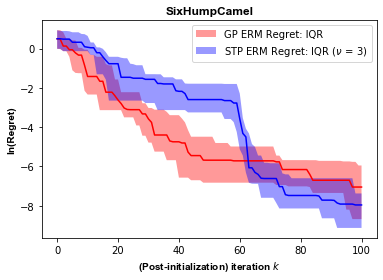

In [170]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_loser, color = 'Red')
plt.plot(median_winner, color = 'Blue')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_loser, upper_loser, facecolor = 'Red', alpha=0.4, label='GP ERM Regret: IQR')
plt.fill_between(xstar, lower_winner, upper_winner, facecolor = 'Blue', alpha=0.4, label='STP ERM Regret: IQR ' r'($\nu$' ' = {})'.format(df))

plt.title(title, weight = 'bold', family = 'Arial')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold', family = 'Arial') # x-axis label
plt.ylabel('ln(Regret)', weight = 'bold', family = 'Arial') # y-axis label
plt.legend(loc=0) # add plot legend

plt.show() #visualise
